In [1]:
import numpy as np 
import os
import matplotlib.pyplot as plt 
import pandas as pd 
import sys

In [2]:
import warnings 


In [3]:
from skimage.io import imshow,imread
from skimage.transform import resize

In [4]:
from tqdm import tqdm

In [5]:
from keras.models import Model,load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint

import random

Using TensorFlow backend.


In [17]:
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

In [18]:
img_width = 128
img_height = 128
img_channels = 3
train_path ="E:/U_NET/train/"
test_path="E:/U_NET/validation/"

In [19]:
train_ids=next(os.walk(train_path))[1]
test_ids=next(os.walk(test_path))[1]

In [20]:
test_ids

['0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5',
 '0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac',
 '0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732',
 '0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd47cf7b0e8b7d63f0925',
 '0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa07459e7afa39fb96c6',
 '0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c087d73380896f72c466',
 '1747f62148a919c8feb6d607faeebdf504b5e2ad42b6b1710b1189c37ebcdb2c',
 '17b9bf4356db24967c4677b8376ac38f826de73a88b93a8d73a8b452e399cdff',
 '1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c3e216a69653495153b',
 '191b2b2205f2f5cc9da04702c5d422bc249faf8bca1107af792da63cccfba829',
 '1962d0c5faf3e85cda80e0578e0cb7aca50826d781620e5c1c4cc586bc69f81a',
 '1cdbfee1951356e7b0a215073828695fe1ead5f8b1add119b6645d2fdc8d844e',
 '1d9eacb3161f1e2b45550389ecf7c535c7199c6b44b1c6a46303f7b965e508f1',
 '1ef68e93964c2d9230100c1347c328f6385a7bc027879dc3d4c055e6fe80cb3c',
 '259b35151d4a7a5ffdd7ab7f171b142d

In [21]:
x_train=np.zeros((len(train_ids),img_height,img_width,img_channels),dtype=np.uint8)

In [22]:
x_train.shape

(670, 128, 128, 3)

In [23]:
y_train=np.zeros((len(train_ids),img_height,img_width,1),dtype=np.bool)

In [24]:
y_train.shape

(670, 128, 128, 1)

In [25]:
for n,id_ in tqdm(enumerate(train_ids),total=len(train_ids)):
    path=train_path + id_
    img=imread(path + "/images/" + id_ + ".png")[:,:,:img_channels]
    img=resize(img,(img_height,img_width), mode='constant', preserve_range=True)
    x_train[n]=img
    
    mask=np.zeros((img_height,img_width,1),dtype=np.bool)
    
    for mask_file in next(os.walk(path + "/masks"))[2]:
        mask_=imread(path + "/masks/" + mask_file)
        mask_=np.expand_dims(resize(mask_,(img_height,img_width),mode="constant",preserve_range=True)
                             ,axis=-1)
        mask=np.maximum(mask,mask_)
    
    y_train[n]=mask
    


    

100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [13:01<00:00,  2.19it/s]


In [26]:
x_train.shape


(670, 128, 128, 3)

In [27]:
x_train[0,:,:,:]

array([[[3, 3, 3],
        [4, 4, 4],
        [3, 3, 3],
        ...,
        [5, 5, 5],
        [3, 3, 3],
        [1, 1, 1]],

       [[5, 5, 5],
        [4, 4, 4],
        [4, 4, 4],
        ...,
        [6, 6, 6],
        [3, 3, 3],
        [1, 1, 1]],

       [[6, 6, 6],
        [5, 5, 5],
        [5, 5, 5],
        ...,
        [6, 6, 6],
        [3, 3, 3],
        [1, 1, 1]],

       ...,

       [[1, 1, 1],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [1, 1, 1],
        [2, 2, 2],
        [1, 1, 1]],

       [[1, 1, 1],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [2, 2, 2],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [0, 0, 0]]], dtype=uint8)

In [28]:
y_train.shape

(670, 128, 128, 1)

In [29]:
y_train[0]

array([[[False],
        [False],
        [False],
        ...,
        [ True],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [ True],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [ True],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])

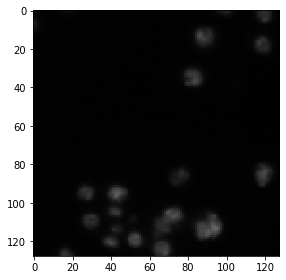

In [30]:
imshow(x_train[0,:,:,:])

In [31]:
y_train[0].shape

(128, 128, 1)

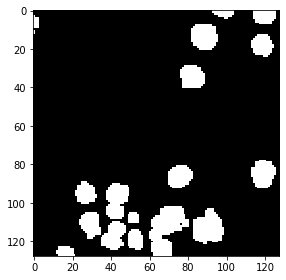

In [32]:
imshow(np.squeeze(y_train[0]))

In [33]:
x_test = np.zeros((len(test_ids), img_height, img_width, img_channels), dtype=np.uint8)
sizes_test = []

sys.stdout.flush()

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path =test_path + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:img_channels]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (img_height,img_width), mode='constant', preserve_range=True)
    x_test[n] = img
    
print("!DONE")

100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:04<00:00, 15.21it/s]


!DONE


In [34]:
x_test.shape

(65, 128, 128, 3)

In [35]:
x_test[0].shape


(128, 128, 3)

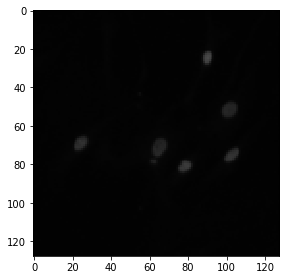

In [36]:
imshow(x_test[0])

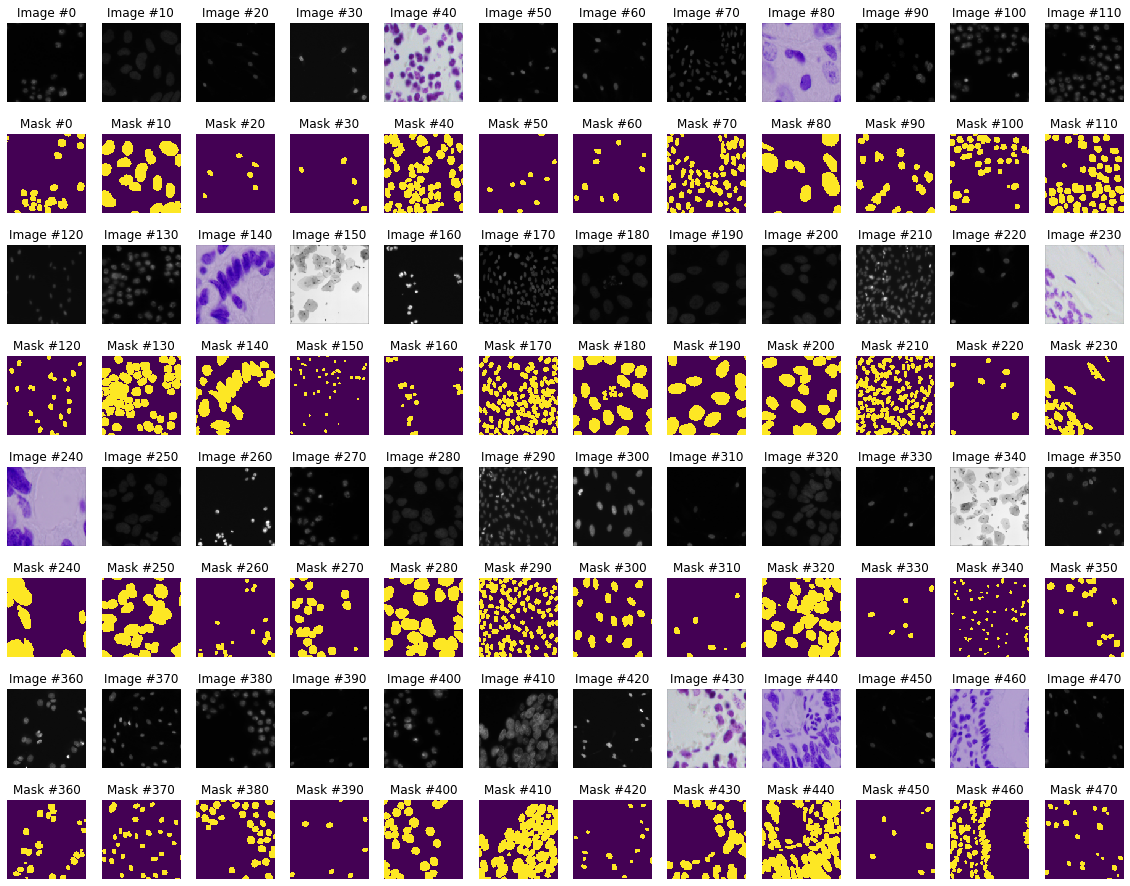

In [37]:
plt.figure(figsize=(20,16))
x, y = 12,4
for i in range(y):  
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*120 + j*10
        plt.imshow(x_train[pos])
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        
        #We display the associated mask we just generated above with the training image
        plt.imshow(np.squeeze(y_train[pos]))
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
        
plt.show()

In [10]:
import tensorflow as tf

In [11]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

In [15]:
inputs = Input((128, 128,3))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1])
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[my_iou_metric])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 128, 128, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_89 (Conv2D)              (None, 128, 128, 16) 448         lambda_6[0][0]                   
__________________________________________________________________________________________________
dropout_43 (Dropout)            (None, 128, 128, 16) 0           conv2d_89[0][0]                  
__________________________________________________________________________________________________
conv2d_90 

__________________________________________________________________________________________________
conv2d_105 (Conv2D)             (None, 128, 128, 16) 4624        concatenate_22[0][0]             
__________________________________________________________________________________________________
dropout_51 (Dropout)            (None, 128, 128, 16) 0           conv2d_105[0][0]                 
__________________________________________________________________________________________________
conv2d_106 (Conv2D)             (None, 128, 128, 16) 2320        dropout_51[0][0]                 
__________________________________________________________________________________________________
conv2d_107 (Conv2D)             (None, 128, 128, 1)  17          conv2d_106[0][0]                 
Total params: 1,941,105
Trainable params: 1,941,105
Non-trainable params: 0
__________________________________________________________________________________________________


In [104]:
model_path="C:/Users/Gurdeep Singh/nuclei_finder_unet_1.h5"

checkpoint=ModelCheckpoint(model_path,
                          monitor="val_loss",
                          mode="min",
                          save_best_only=True)

earlystop=EarlyStopping(monitor="val_loss",
                       min_delta=0,
                       patience=5,
                       restore_best_weights=True)

In [105]:
results = model.fit(x_train, y_train, validation_split=0.1,
                    batch_size=32, epochs=10, 
                    callbacks=[earlystop, checkpoint])

Train on 603 samples, validate on 67 samples
Epoch 1/10
603/603 [==============================] - ETA: 1:44 - loss: 0.8467 - my_iou_metric: 0.0000e+0 - ETA: 1:09 - loss: 0.7556 - my_iou_metric: 1.8539e-0 - ETA: 57s - loss: 0.7069 - my_iou_metric: 1.3826e-0 - ETA: 51s - loss: 0.6812 - my_iou_metric: 1.0370e- - ETA: 45s - loss: 0.6636 - my_iou_metric: 8.2957e- - ETA: 40s - loss: 0.6392 - my_iou_metric: 2.4796e- - ETA: 36s - loss: 0.6188 - my_iou_metric: 4.6644e- - ETA: 32s - loss: 0.6022 - my_iou_metric: 6.9716e- - ETA: 28s - loss: 0.5911 - my_iou_metric: 1.1594e- - ETA: 25s - loss: 0.5687 - my_iou_metric: 0.0019   - ETA: 22s - loss: 0.5475 - my_iou_metric: 0.00 - ETA: 19s - loss: 0.5406 - my_iou_metric: 0.00 - ETA: 16s - loss: 0.5322 - my_iou_metric: 0.00 - ETA: 13s - loss: 0.5156 - my_iou_metric: 0.01 - ETA: 10s - loss: 0.5068 - my_iou_metric: 0.01 - ETA: 7s - loss: 0.4951 - my_iou_metric: 0.0173 - ETA: 5s - loss: 0.4846 - my_iou_metric: 0.021 - ETA: 2s - loss: 0.4778 - my_iou_metric:

Epoch 9/10
603/603 [==============================] - ETA: 44s - loss: 0.0956 - my_iou_metric: 0.47 - ETA: 42s - loss: 0.1124 - my_iou_metric: 0.44 - ETA: 39s - loss: 0.1119 - my_iou_metric: 0.43 - ETA: 37s - loss: 0.1182 - my_iou_metric: 0.43 - ETA: 35s - loss: 0.1131 - my_iou_metric: 0.43 - ETA: 32s - loss: 0.1113 - my_iou_metric: 0.43 - ETA: 30s - loss: 0.1137 - my_iou_metric: 0.44 - ETA: 28s - loss: 0.1139 - my_iou_metric: 0.44 - ETA: 25s - loss: 0.1126 - my_iou_metric: 0.45 - ETA: 22s - loss: 0.1152 - my_iou_metric: 0.45 - ETA: 20s - loss: 0.1159 - my_iou_metric: 0.45 - ETA: 17s - loss: 0.1179 - my_iou_metric: 0.44 - ETA: 15s - loss: 0.1161 - my_iou_metric: 0.45 - ETA: 12s - loss: 0.1163 - my_iou_metric: 0.45 - ETA: 10s - loss: 0.1174 - my_iou_metric: 0.44 - ETA: 7s - loss: 0.1195 - my_iou_metric: 0.4446 - ETA: 4s - loss: 0.1203 - my_iou_metric: 0.444 - ETA: 2s - loss: 0.1207 - my_iou_metric: 0.441 - 54s 89ms/step - loss: 0.1197 - my_iou_metric: 0.4436 - val_loss: 0.1167 - val_my_

In [40]:

model = load_model("C:/Users/Gurdeep Singh/nuclei_finder_unet_1.h5",
                  custom_objects={'my_iou_metric': my_iou_metric})

preds_train = model.predict(x_train)

preds_test = model.predict(x_test)

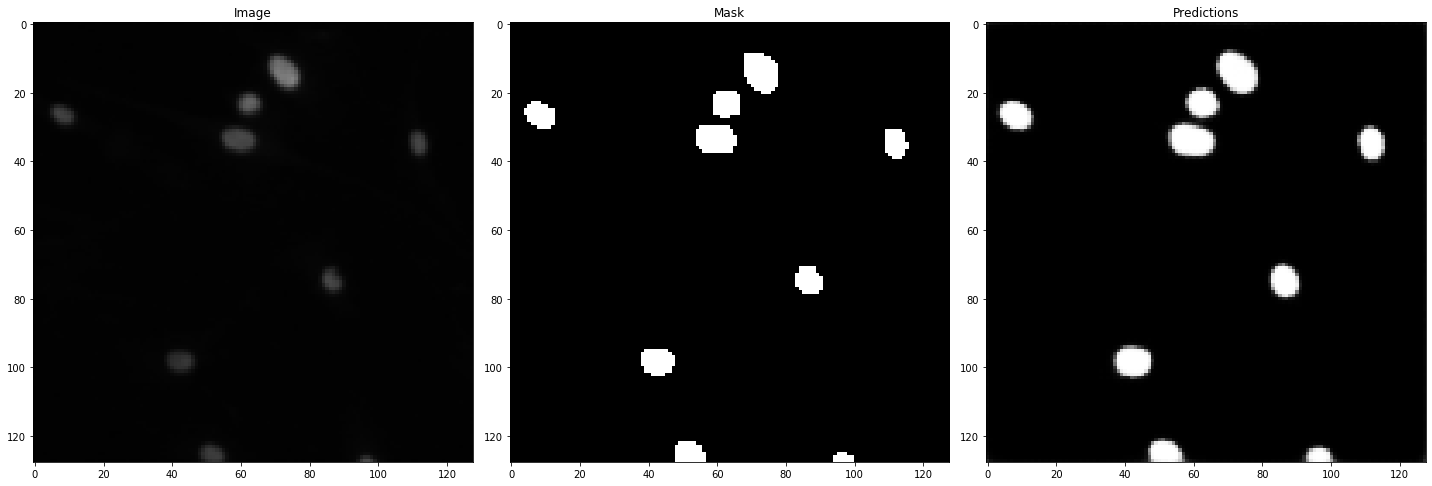

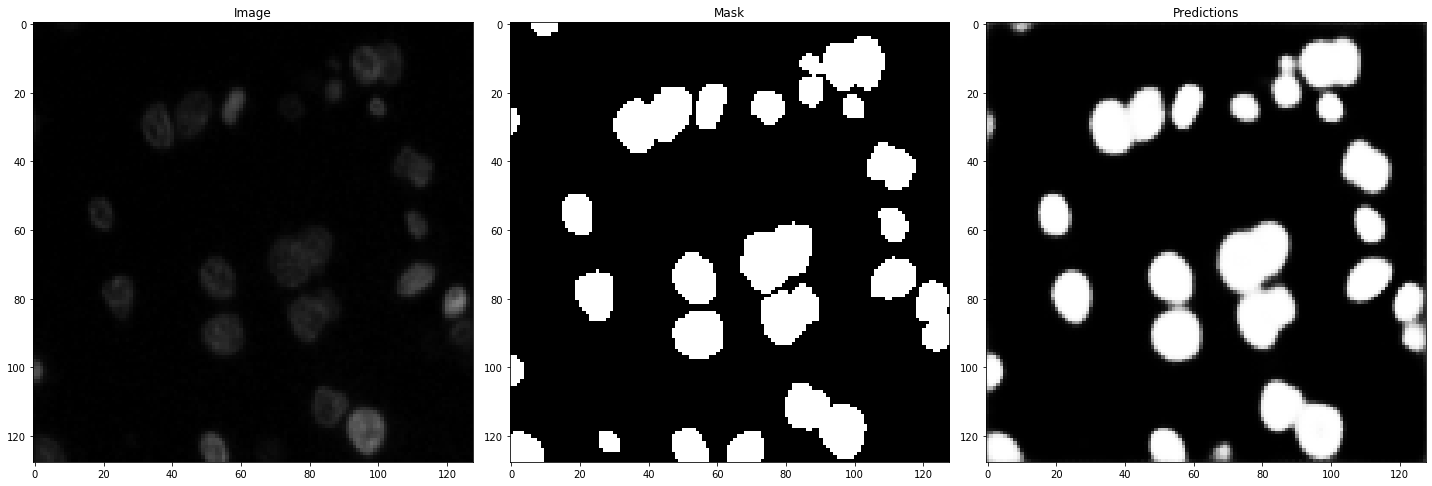

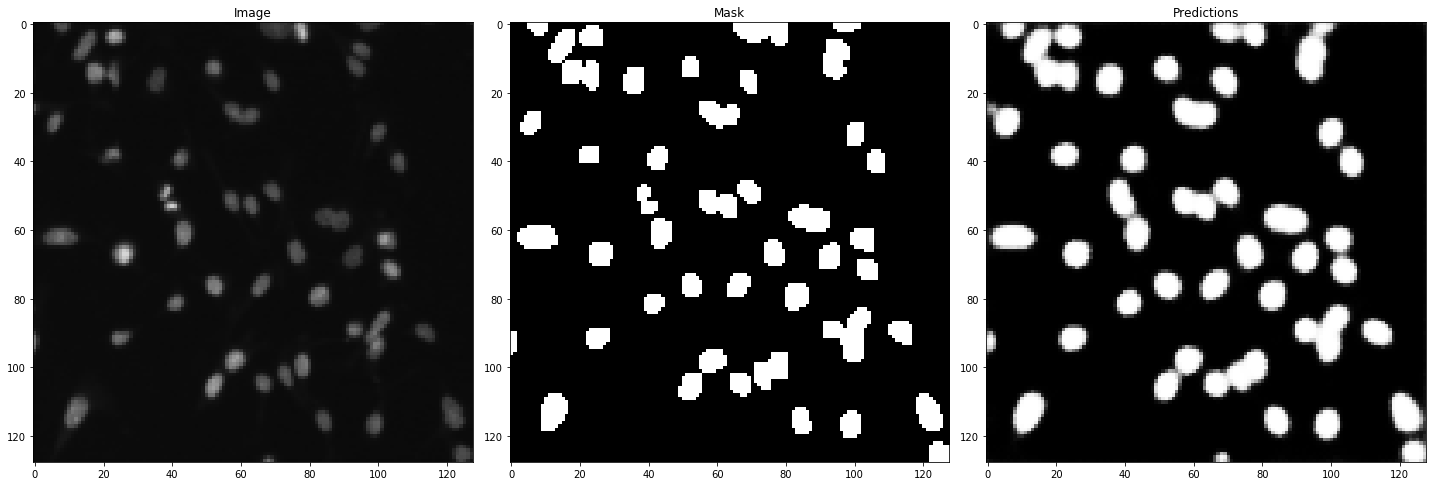

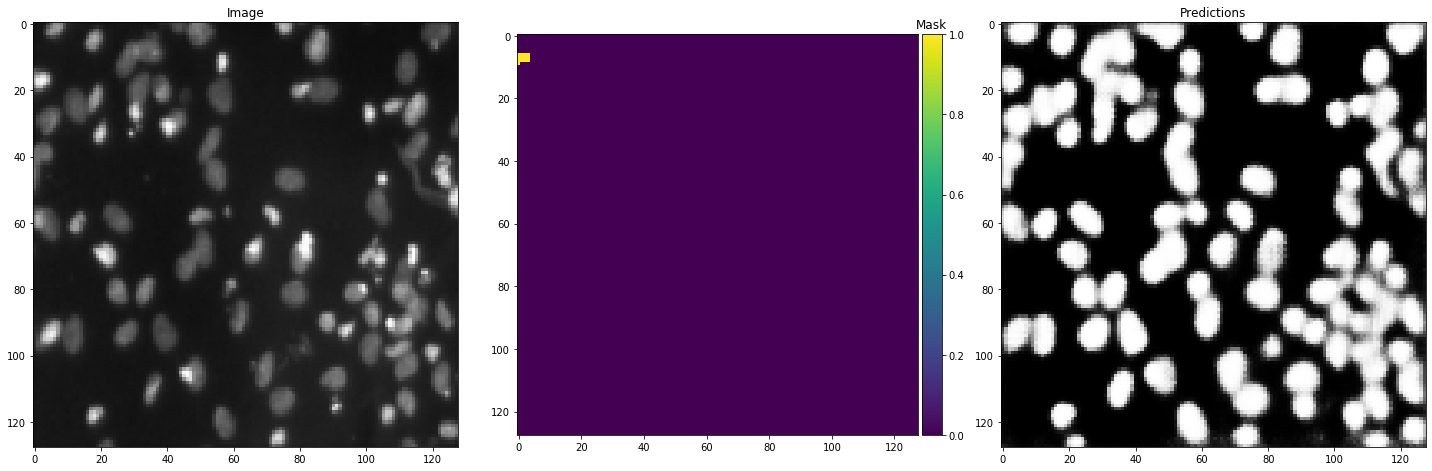

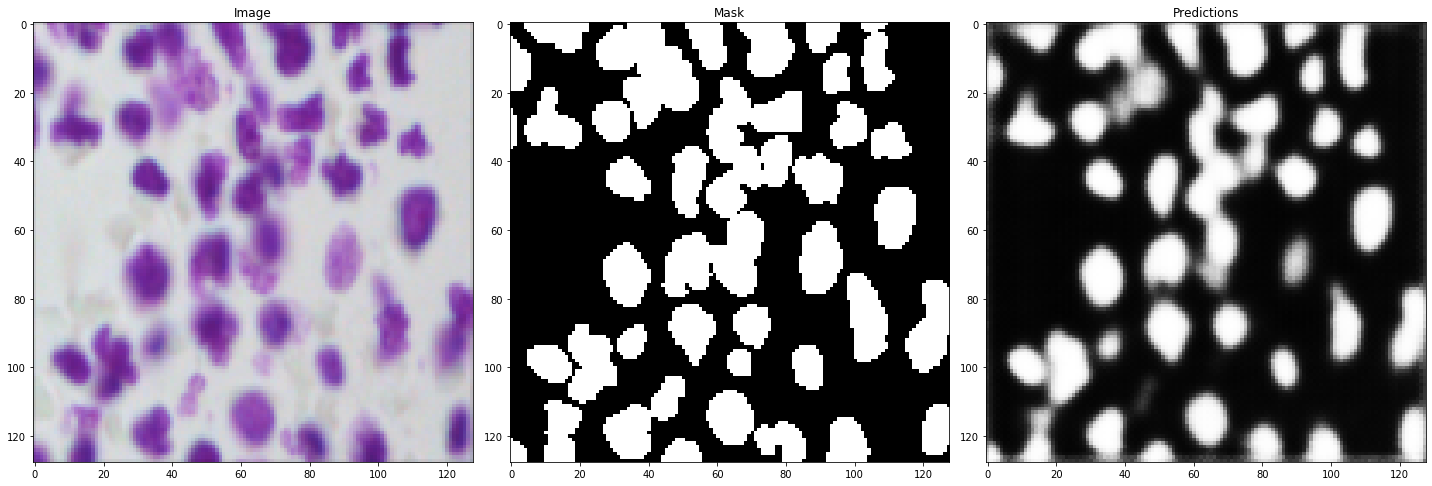

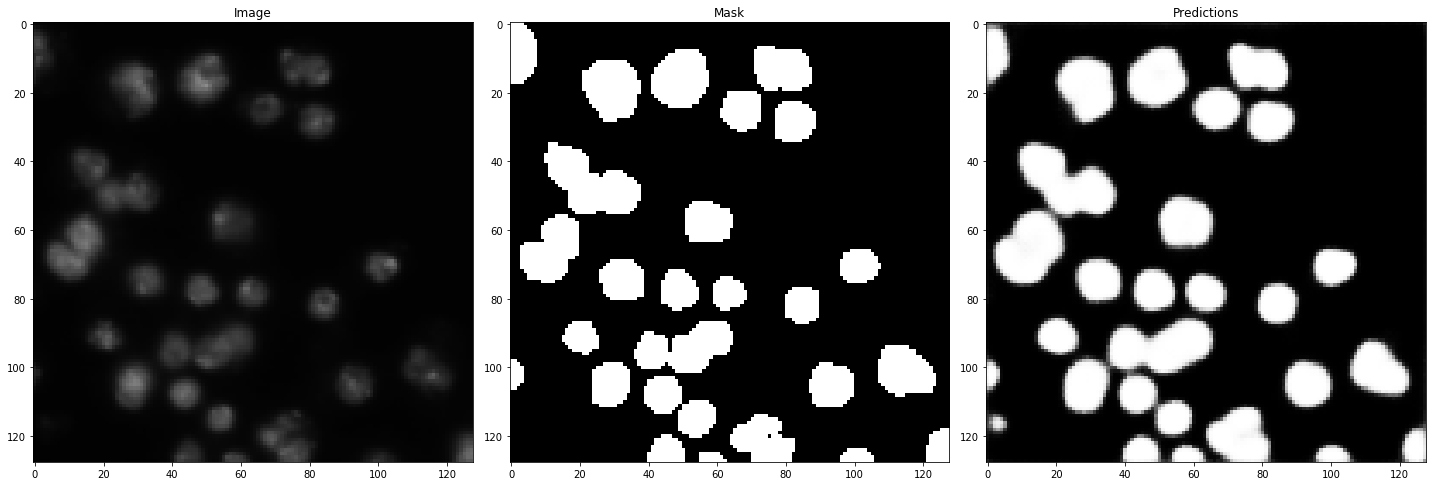

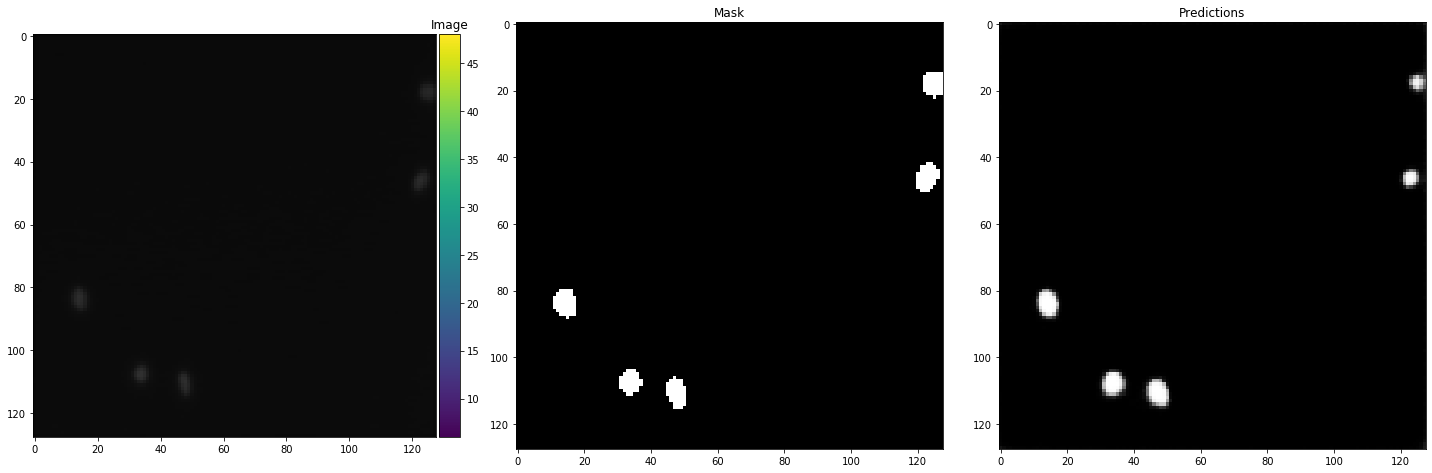

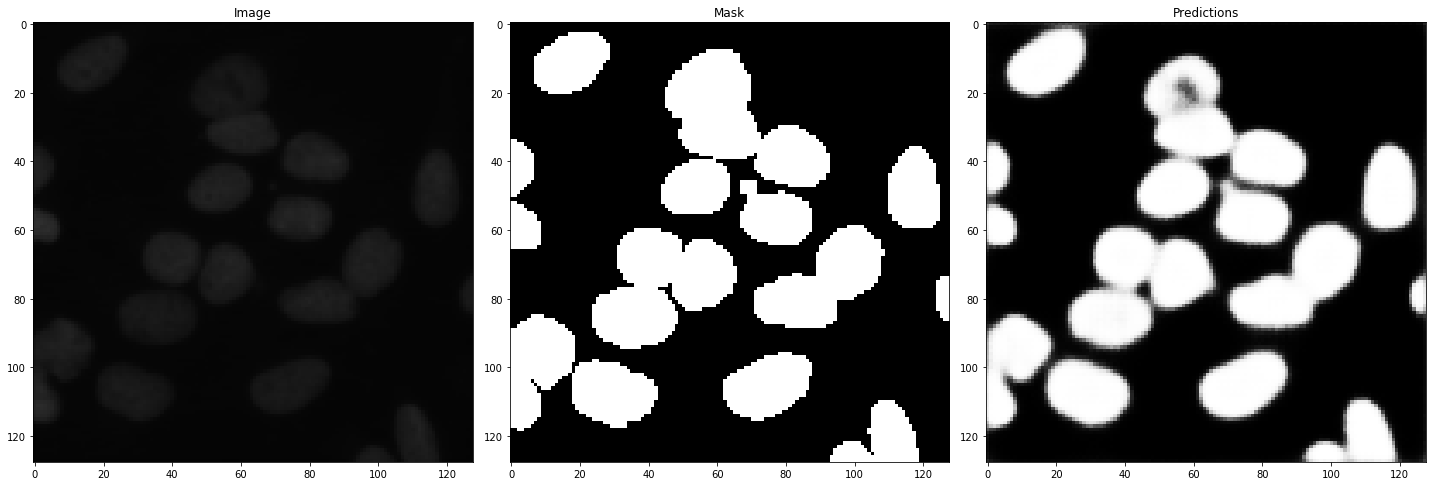

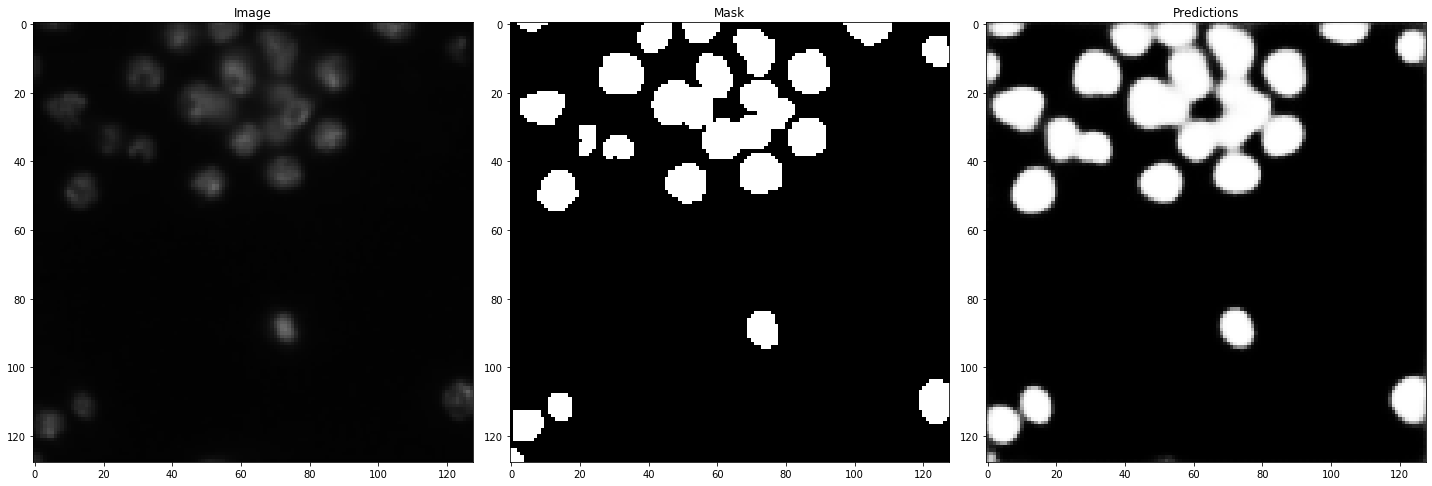

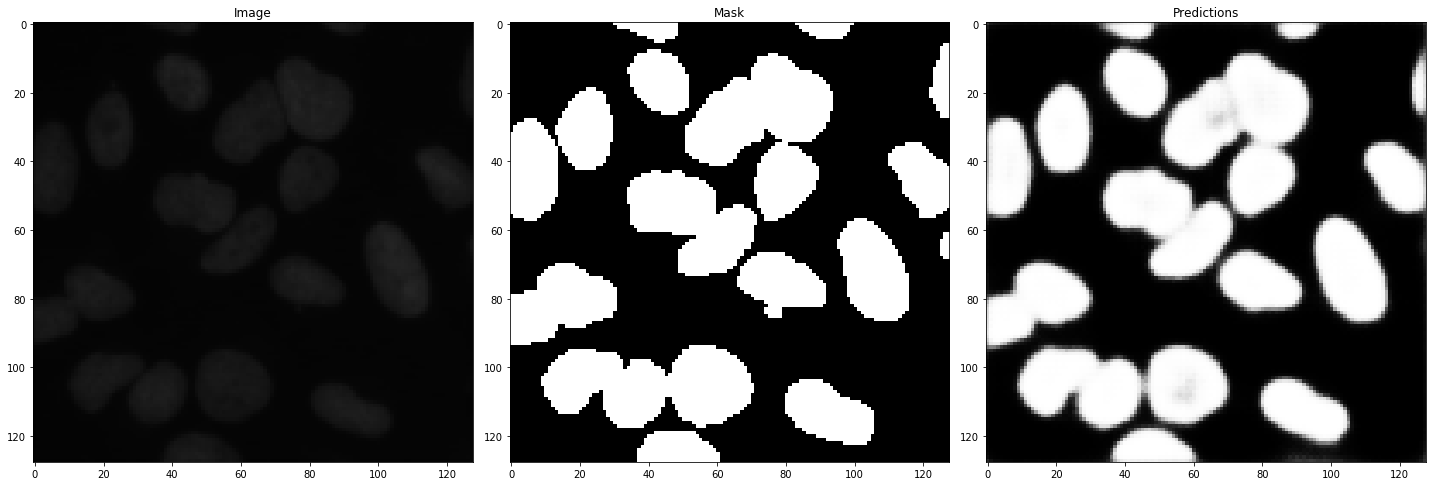

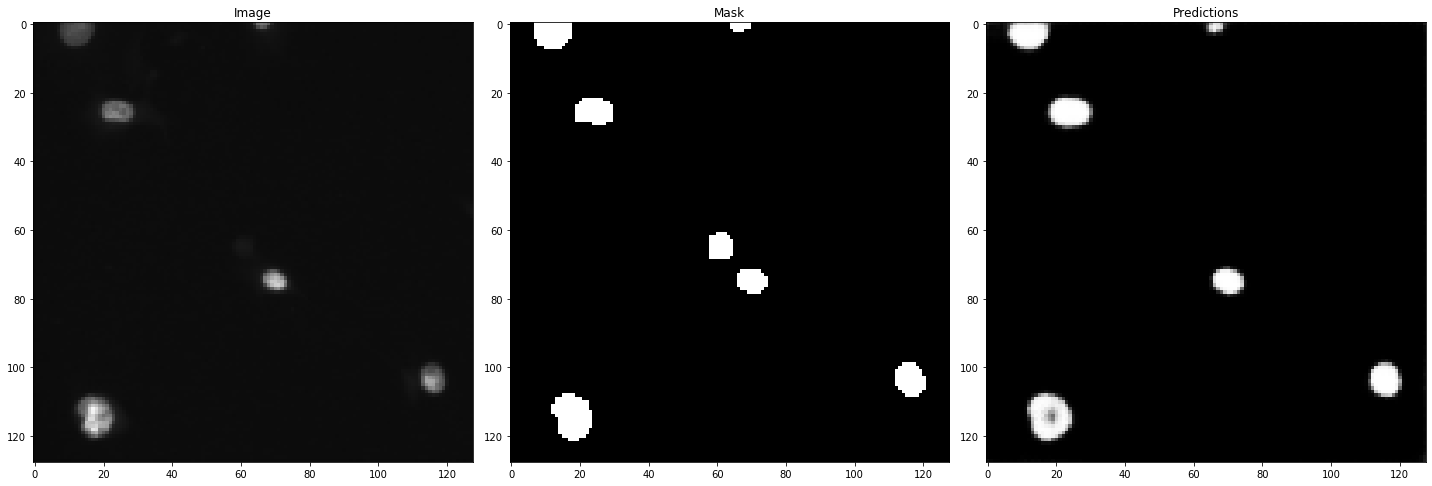

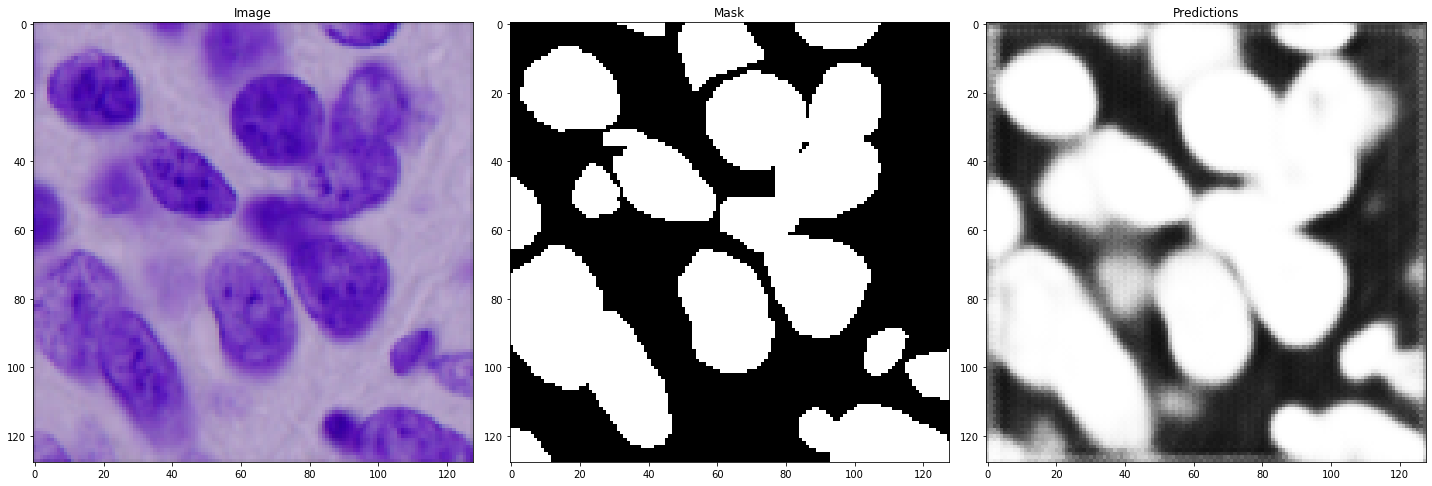

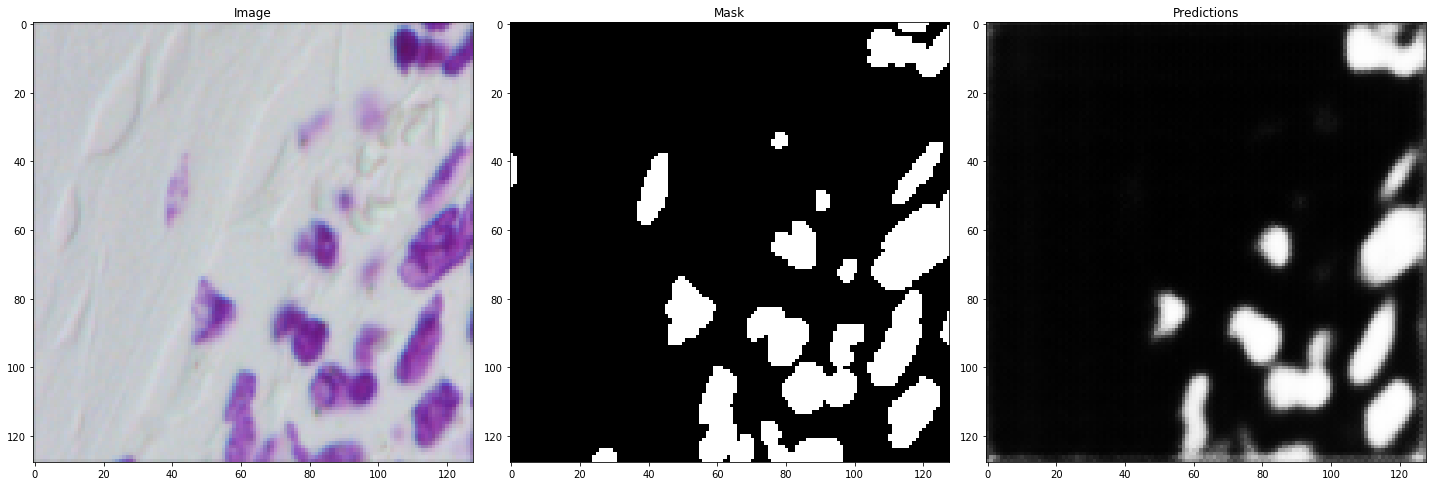

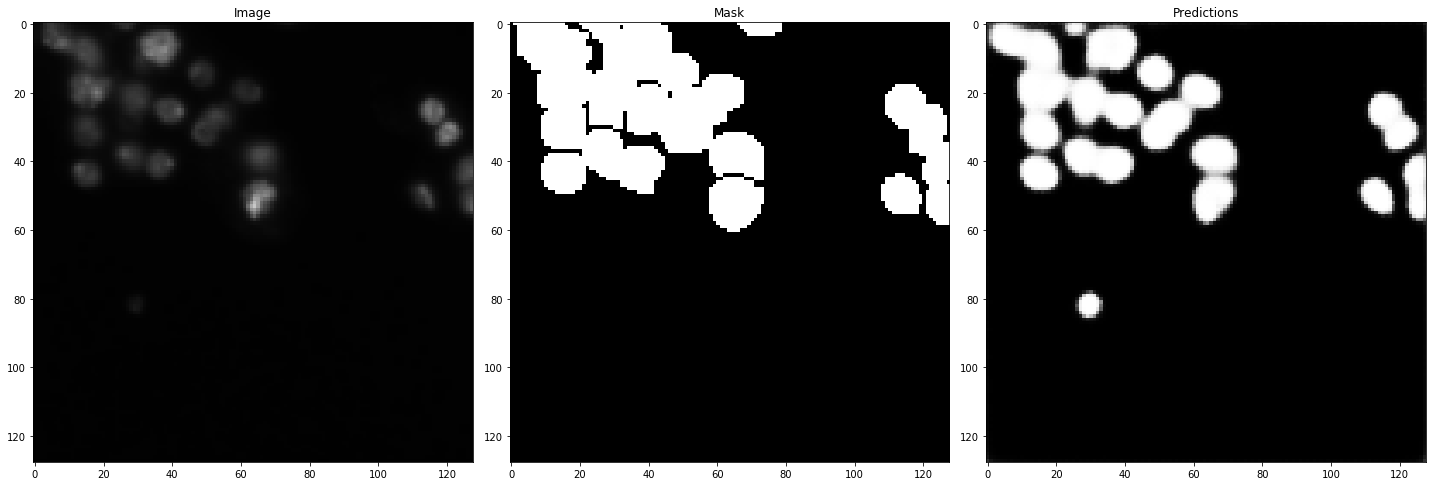

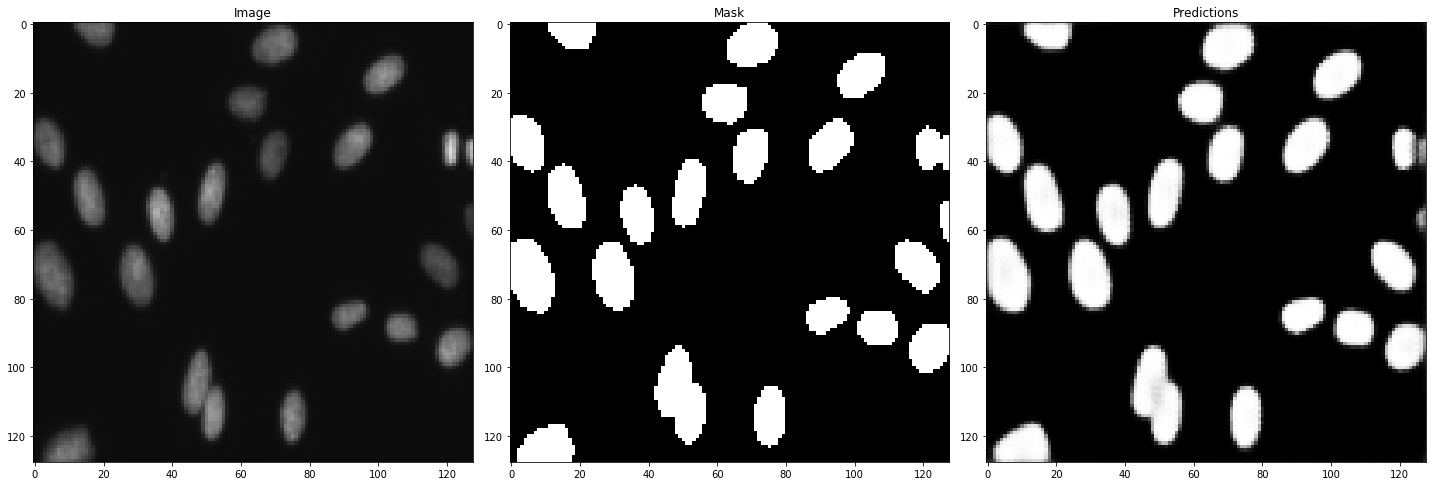

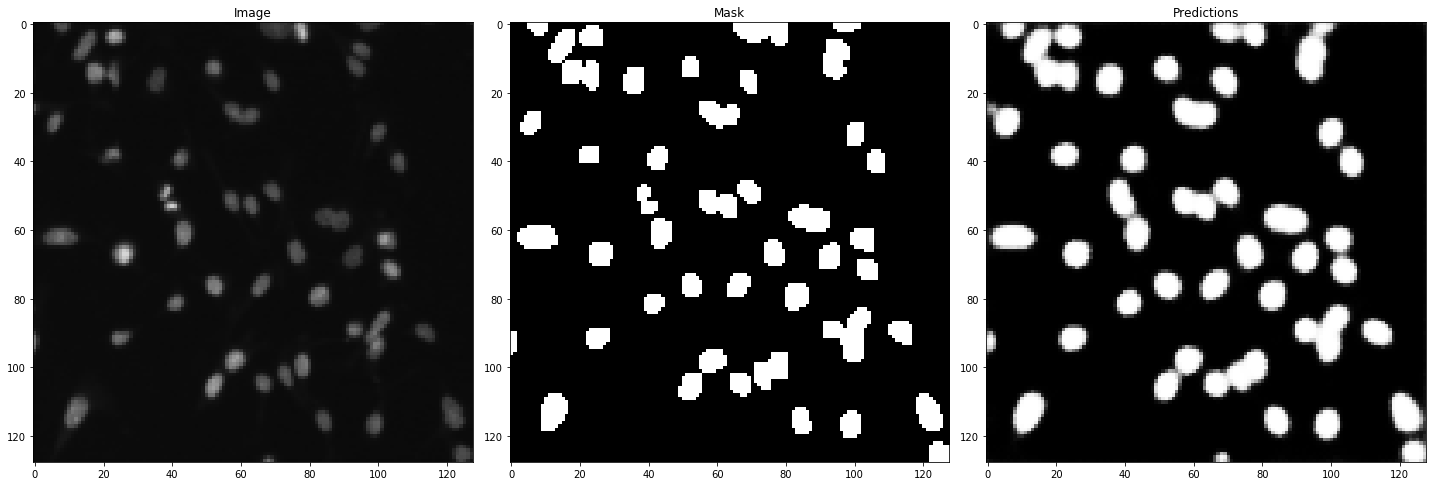

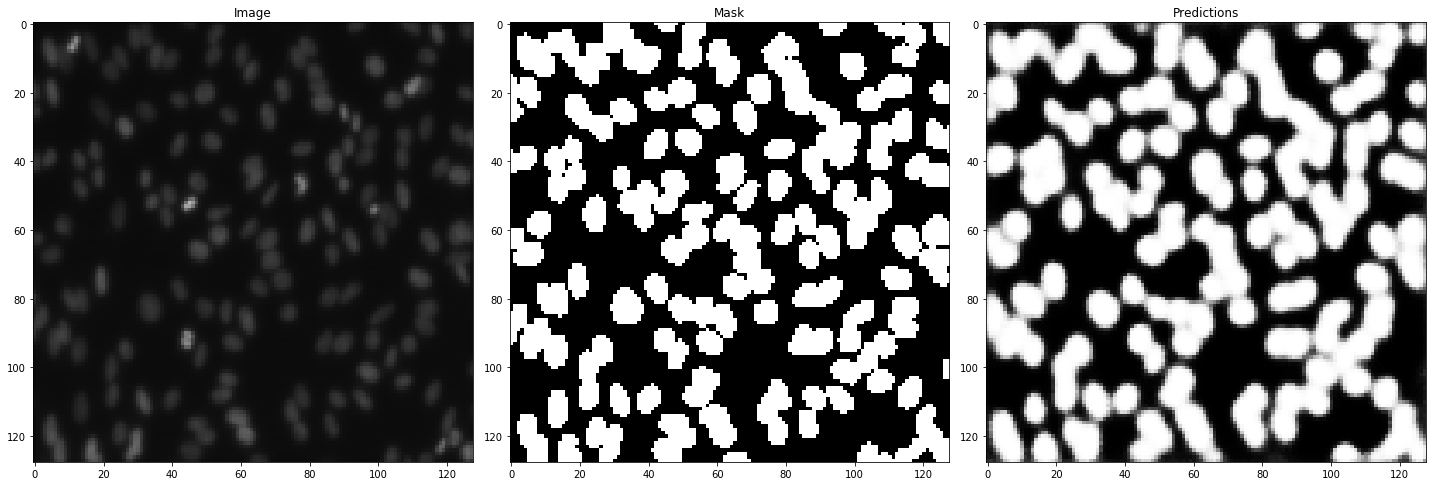

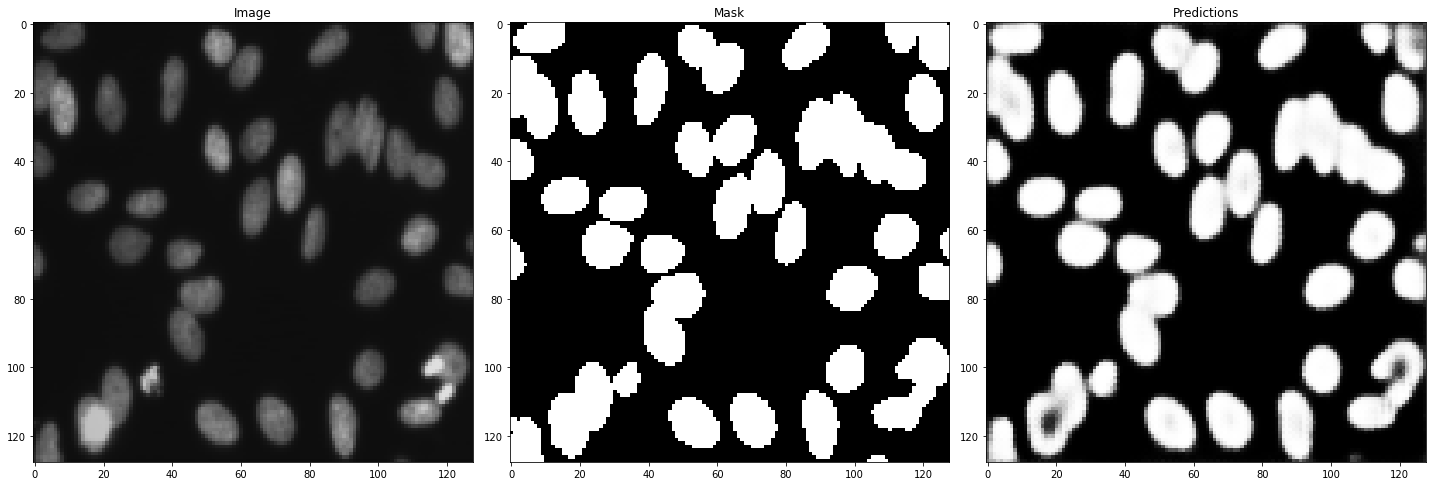

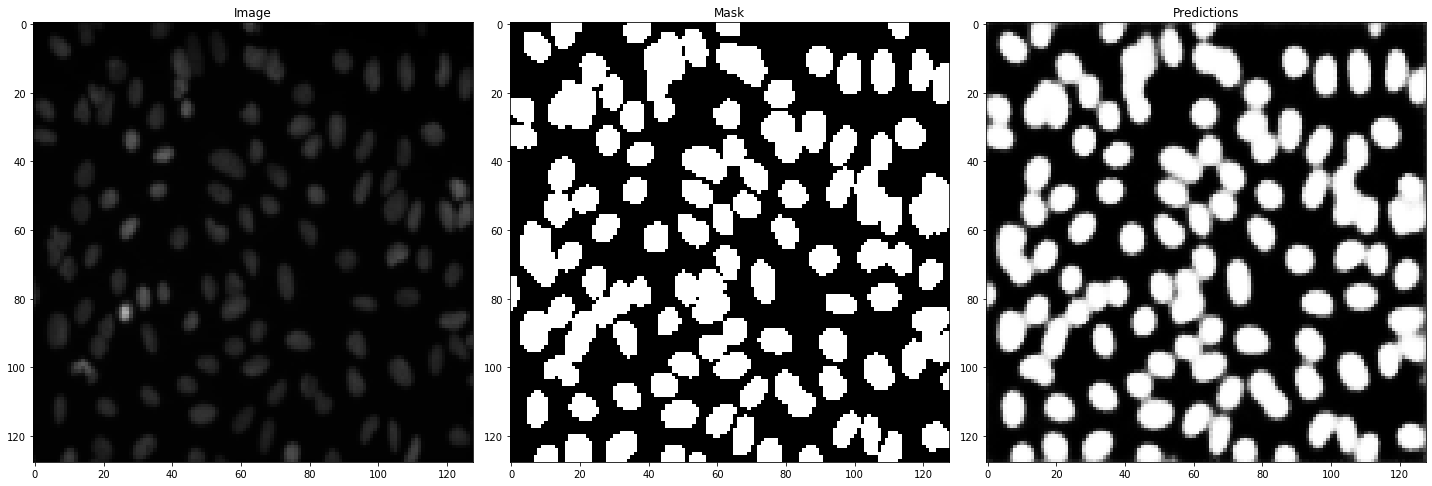

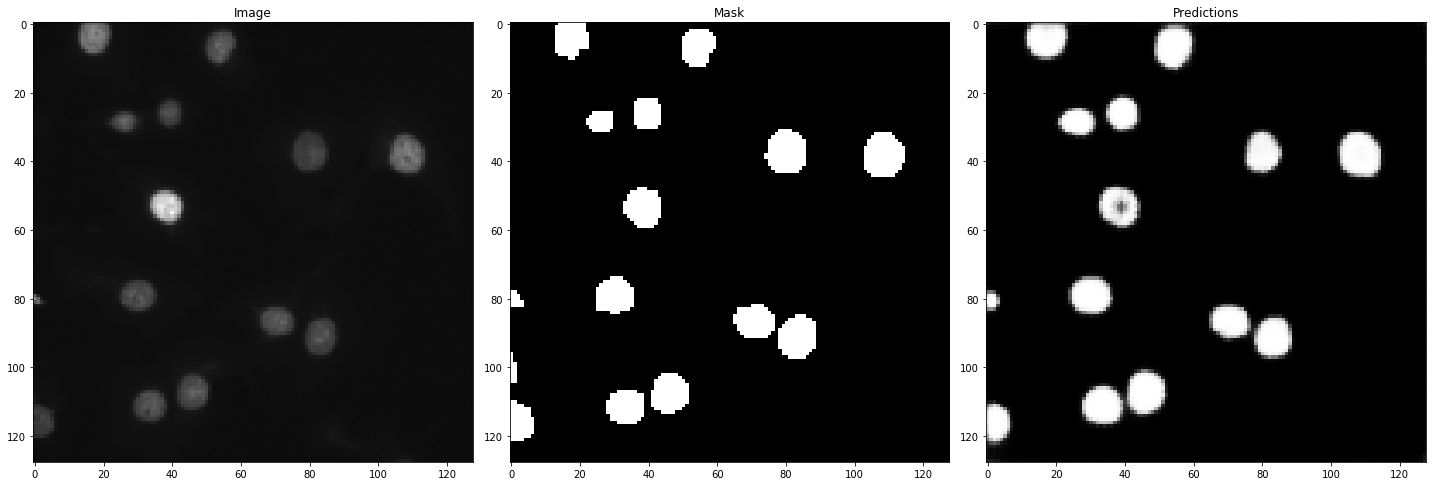

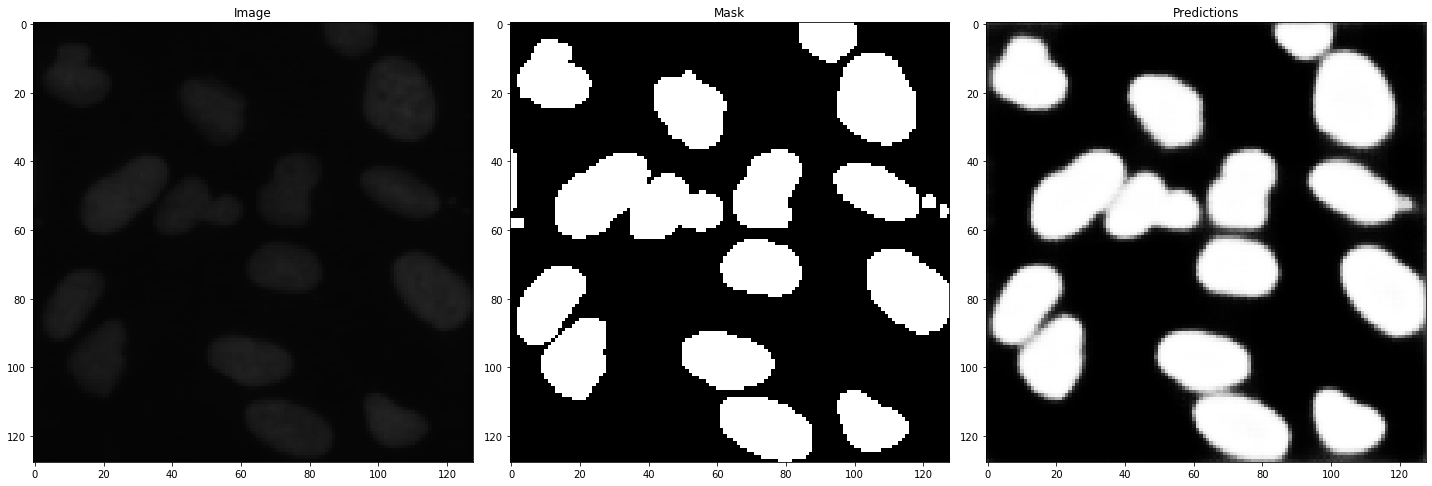

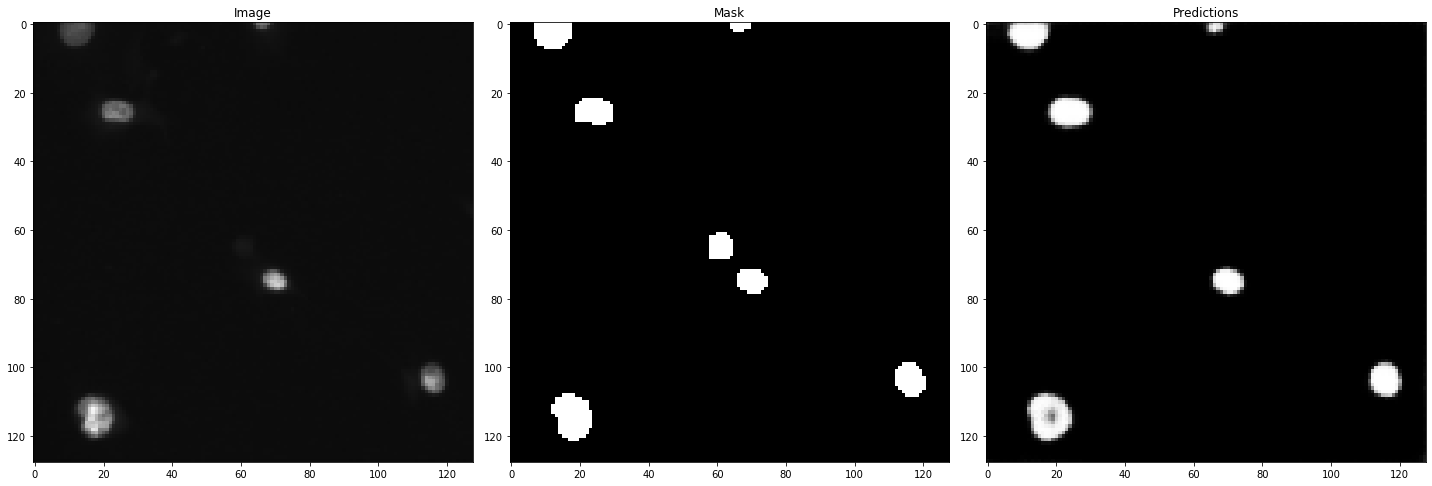

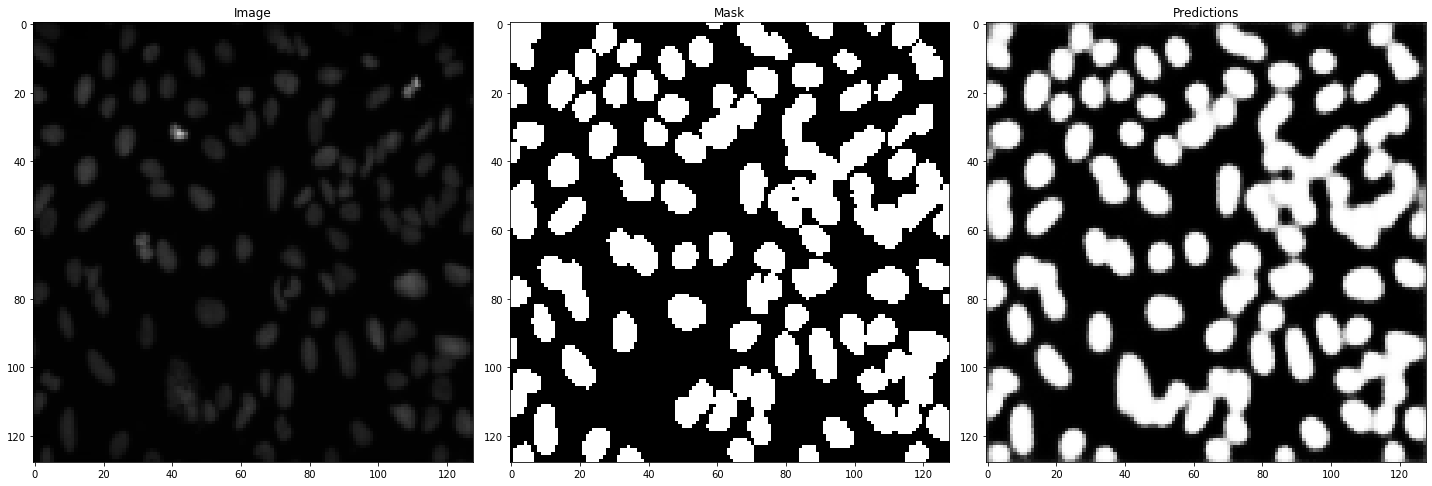

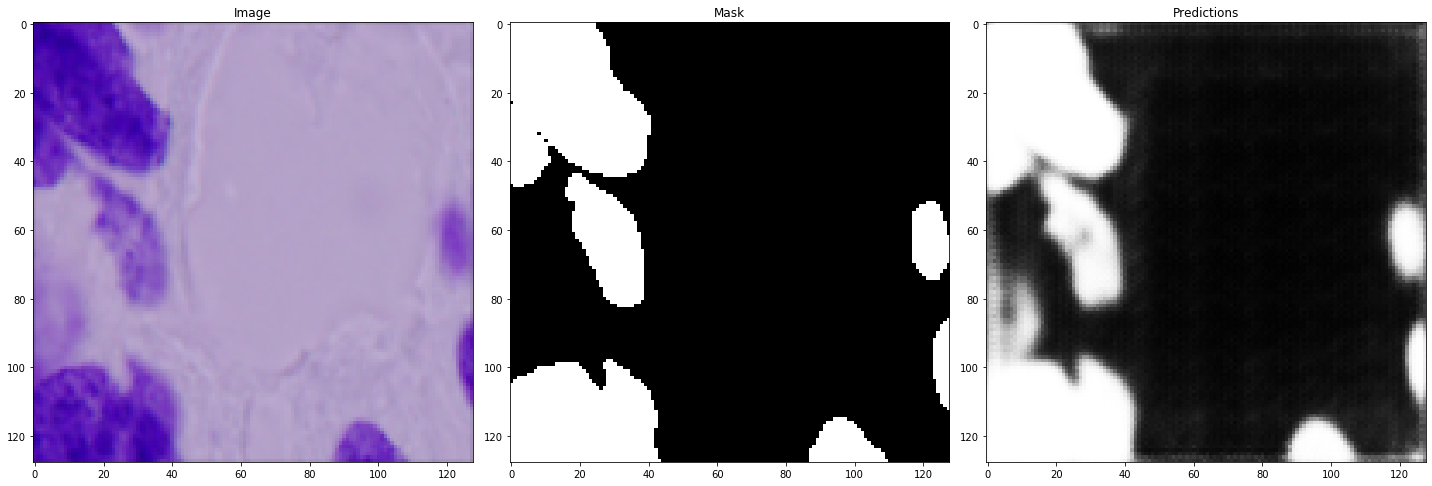

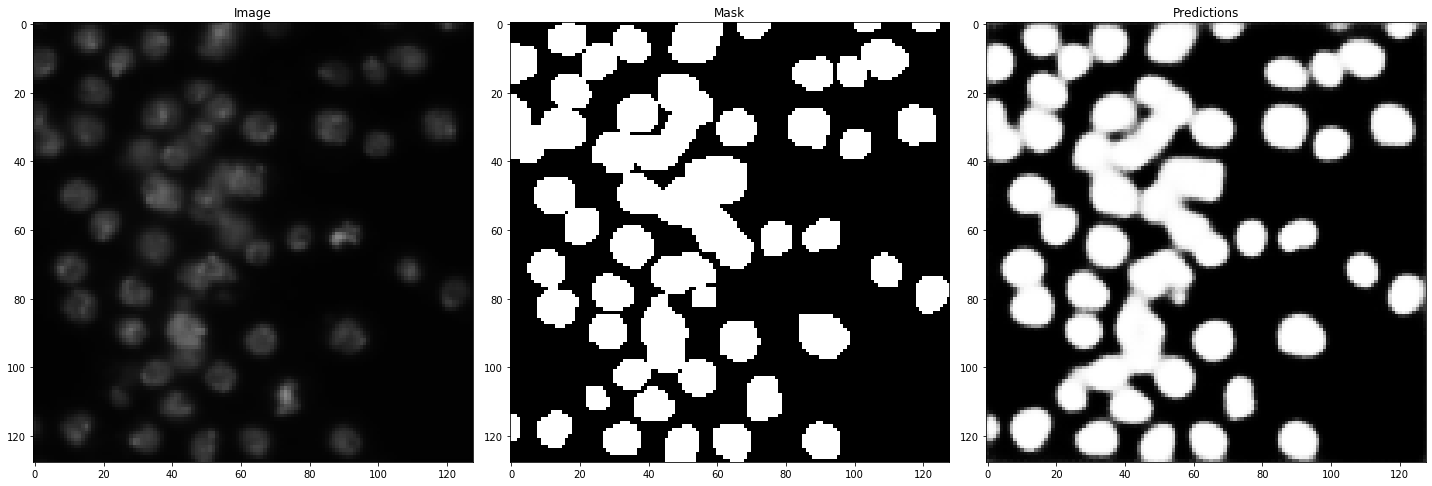

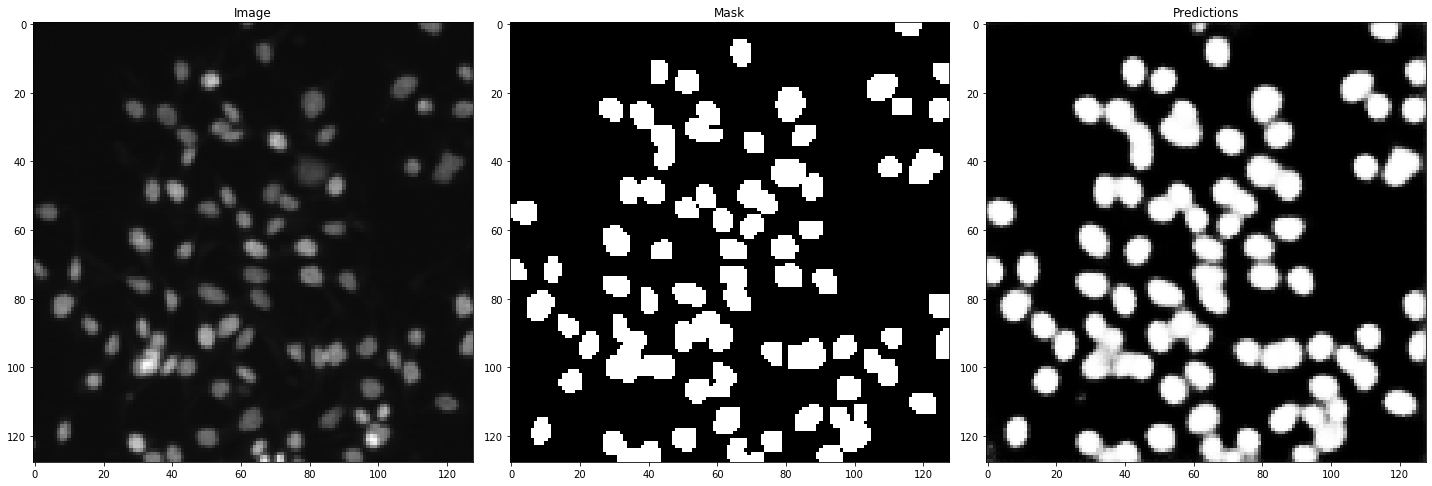

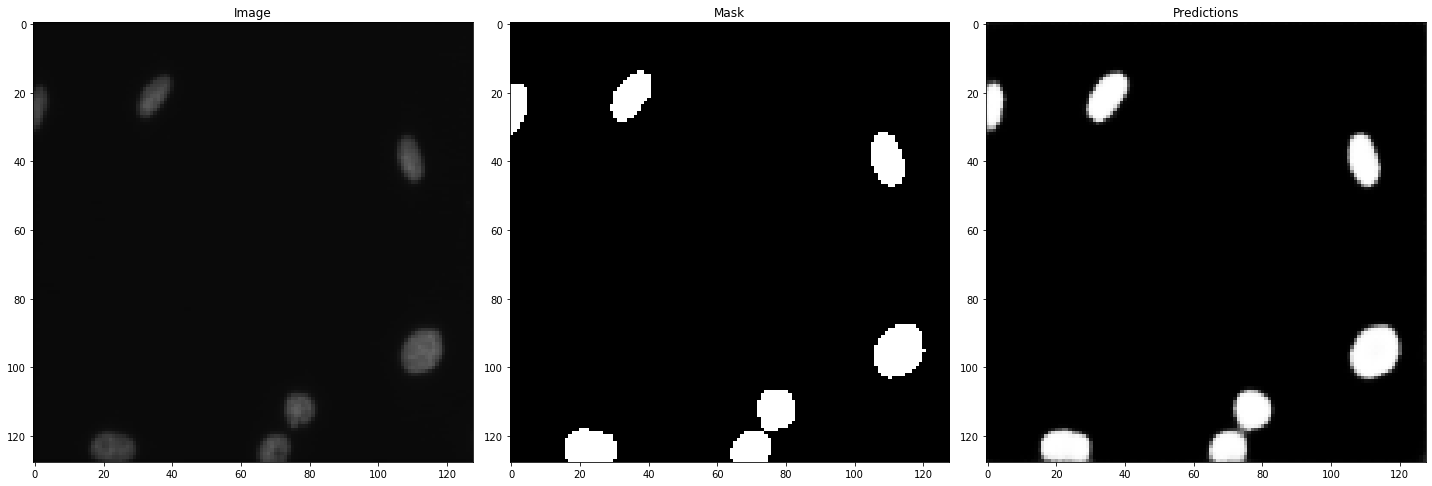

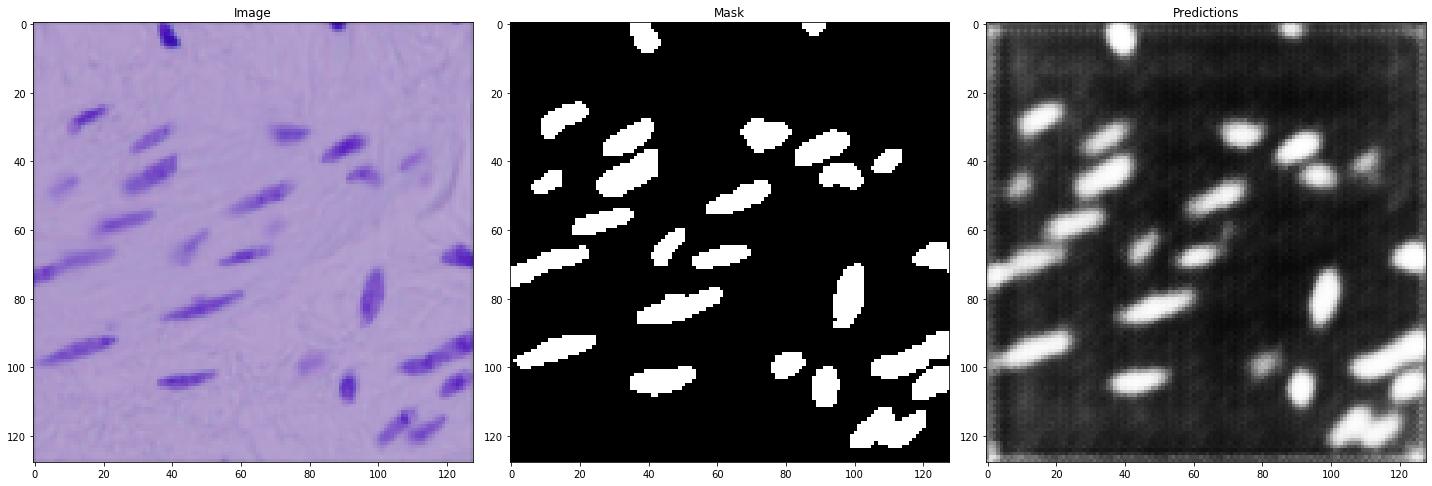

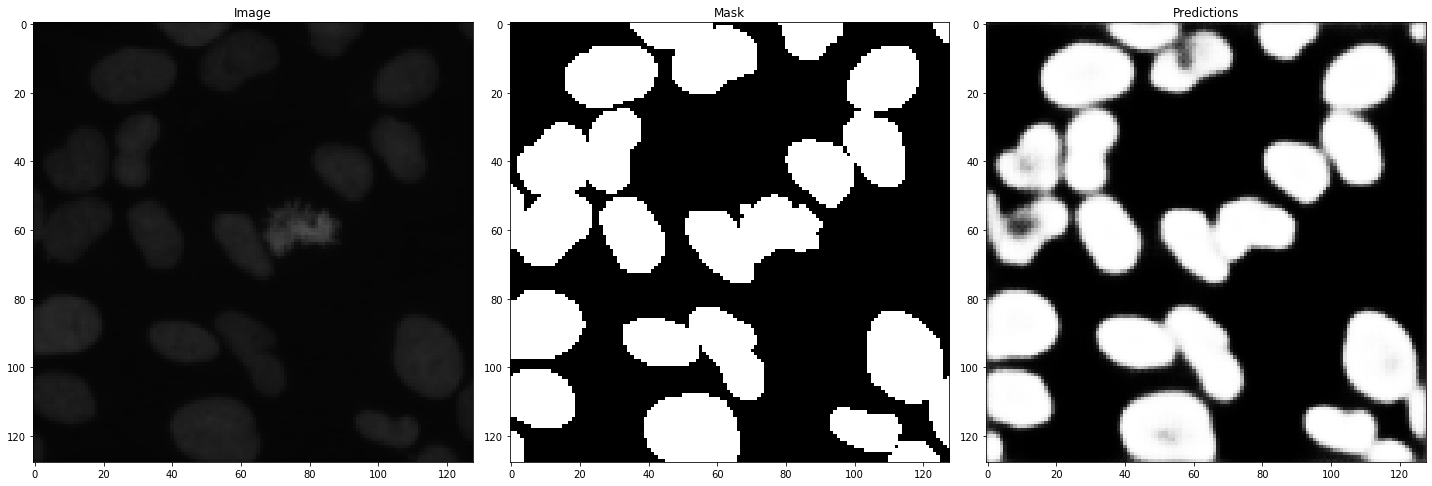

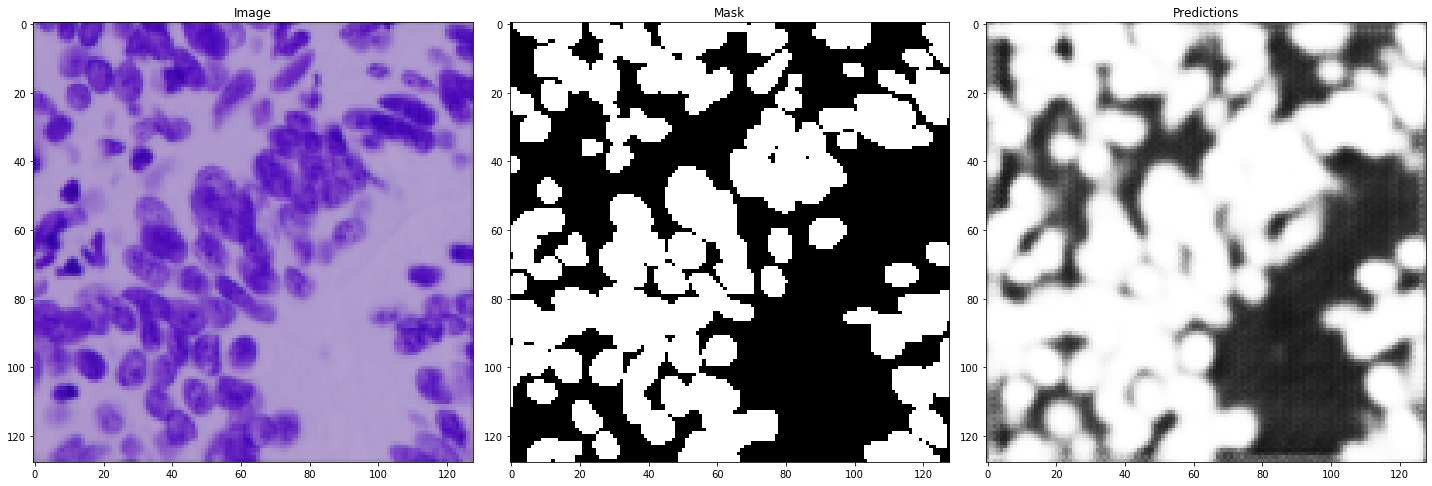

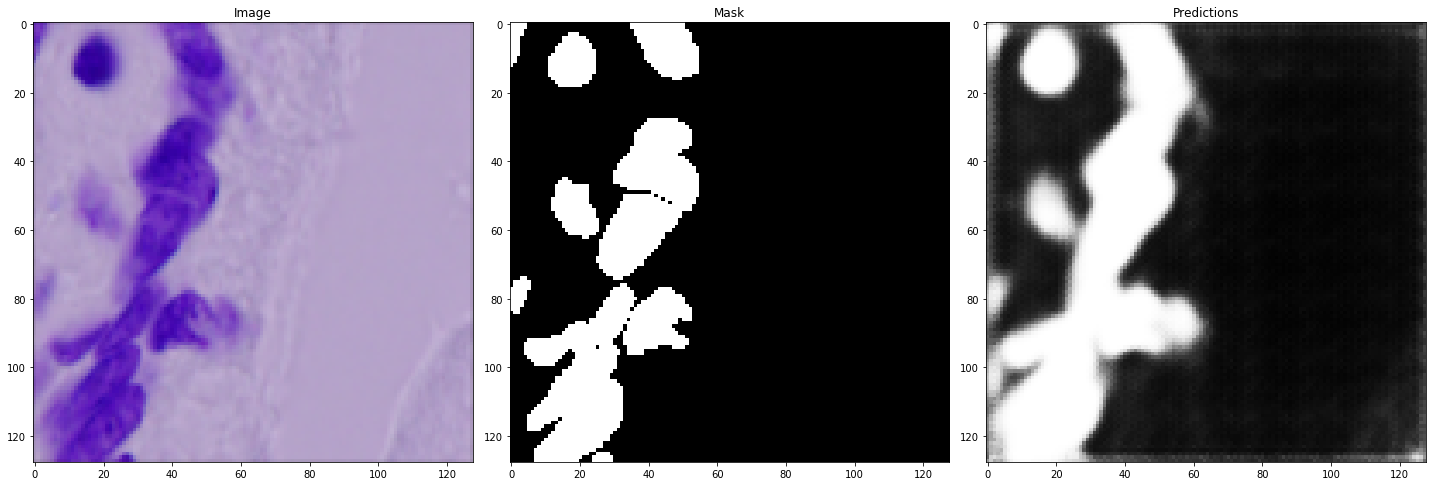

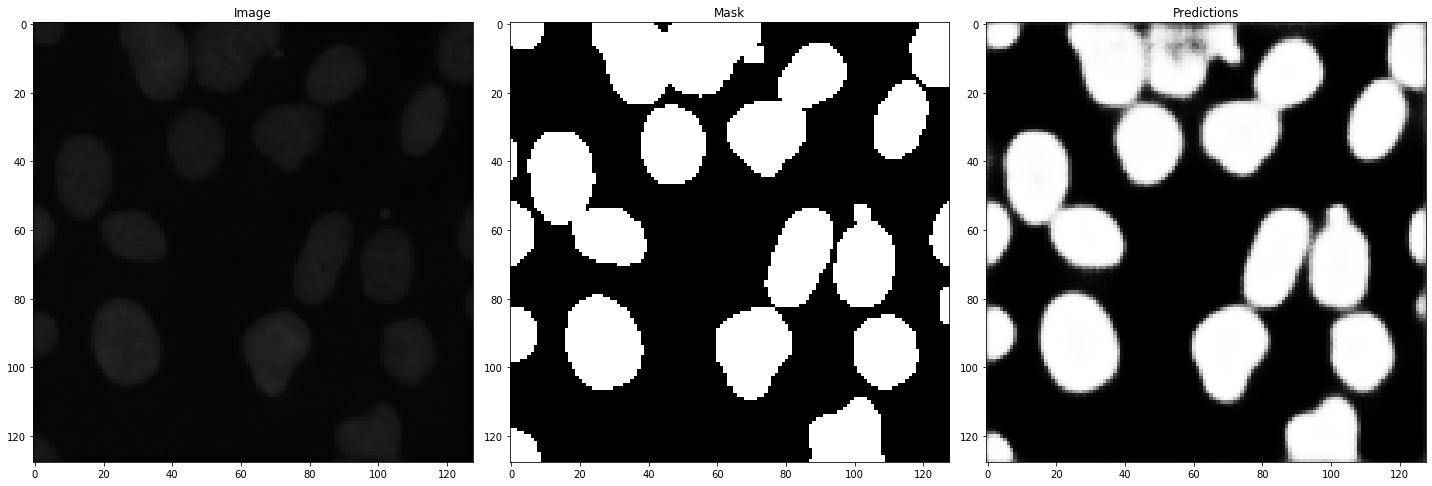

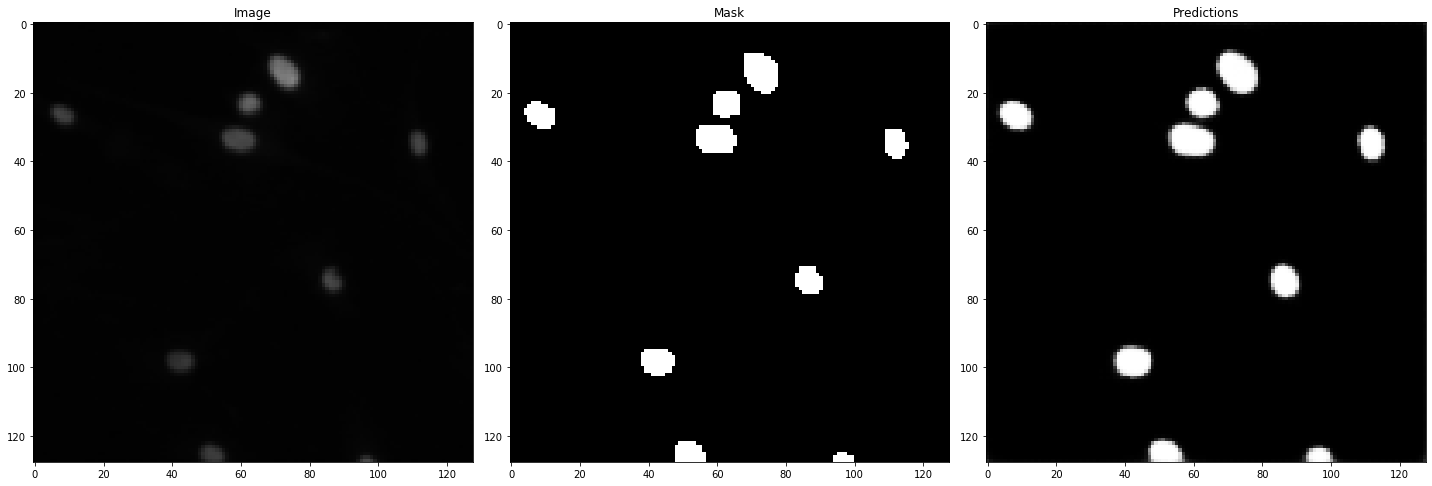

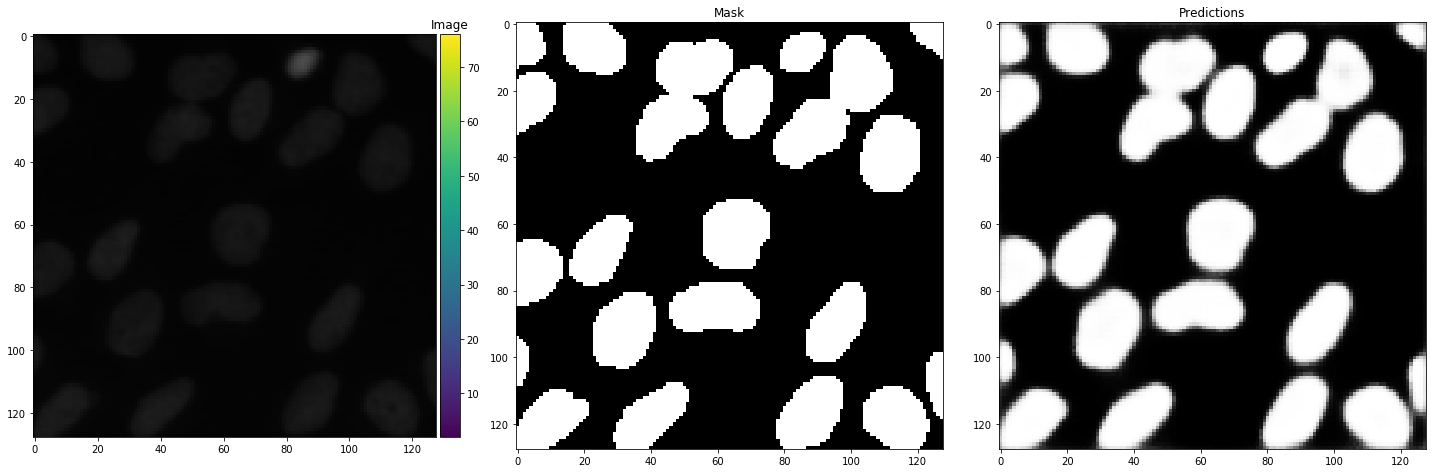

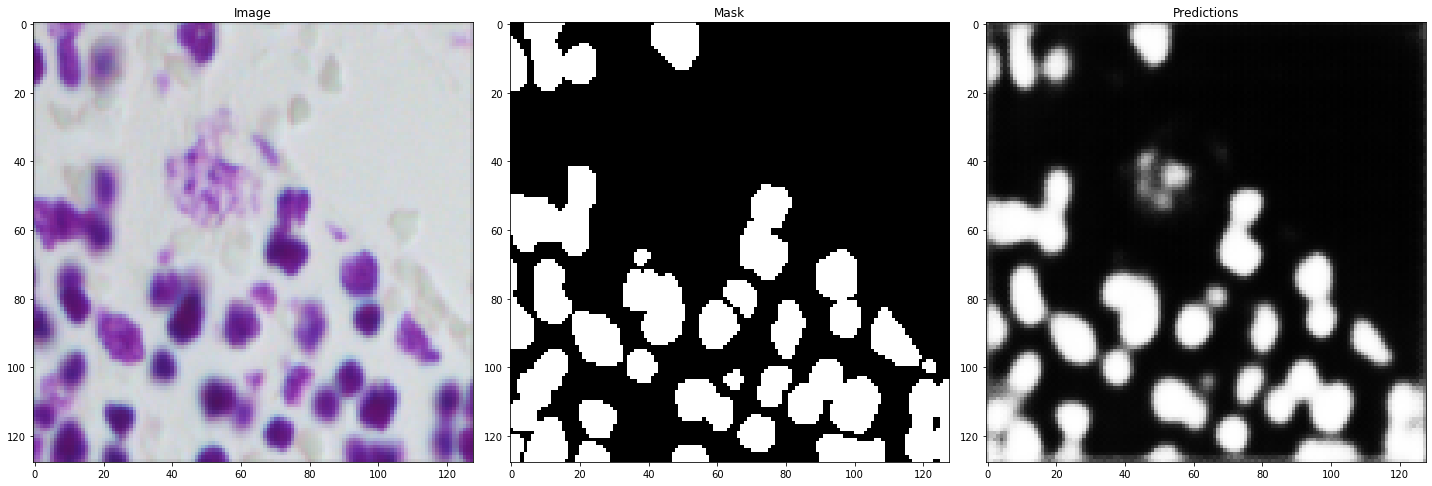

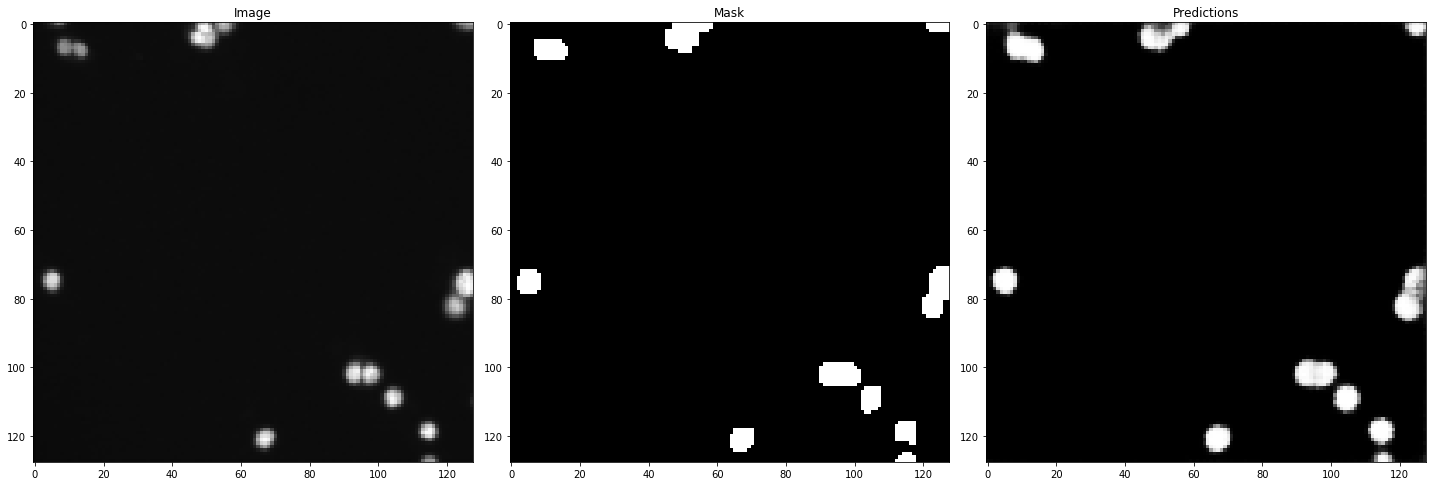

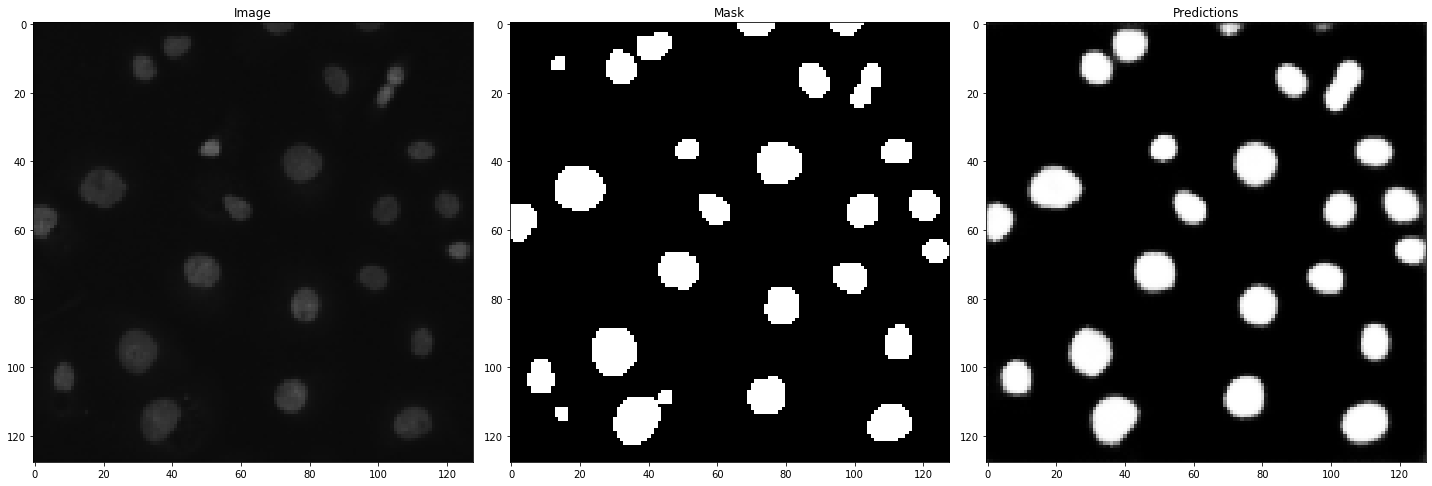

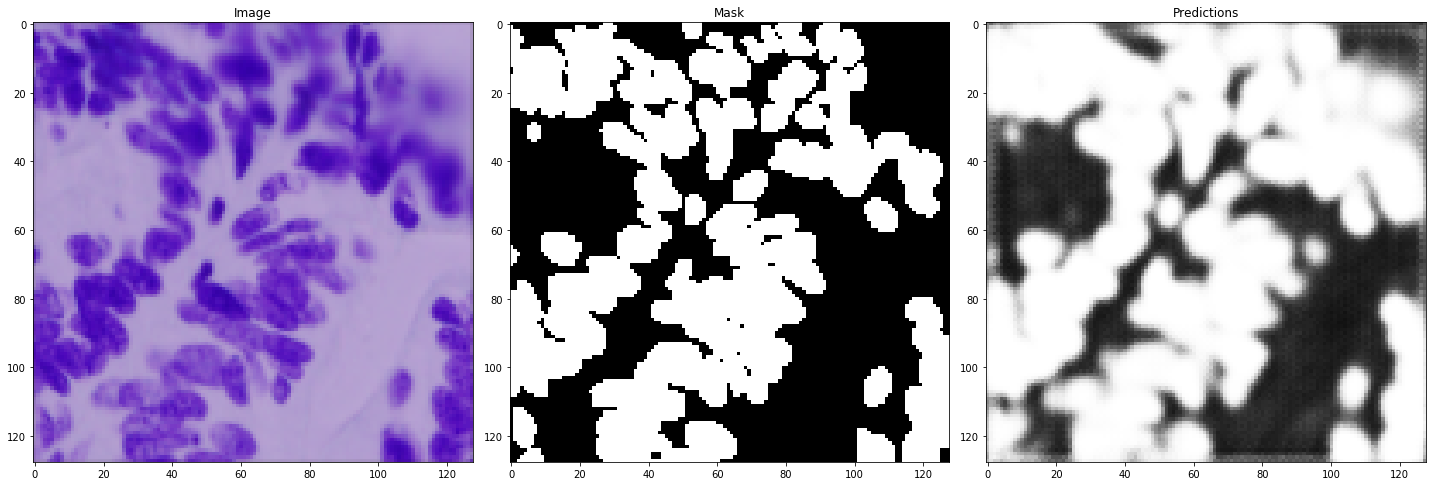

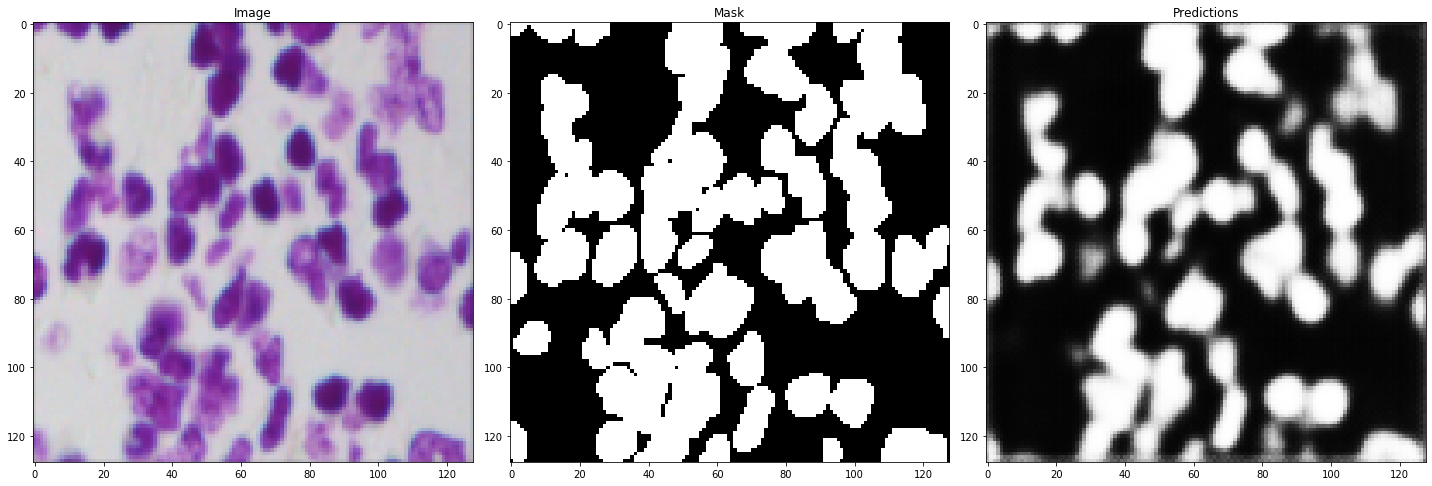

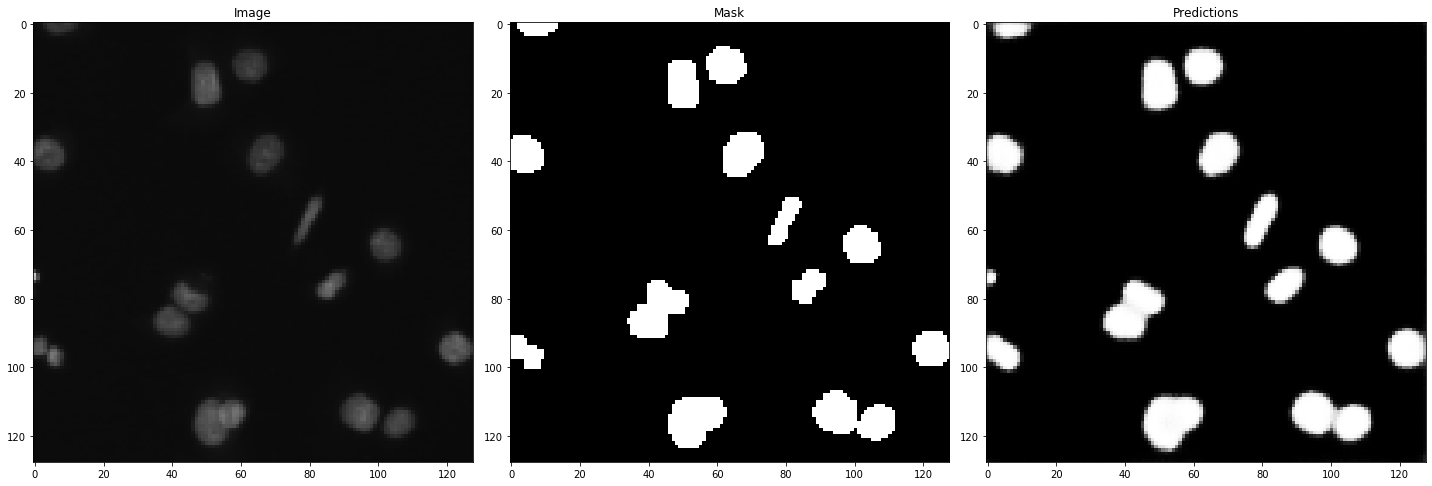

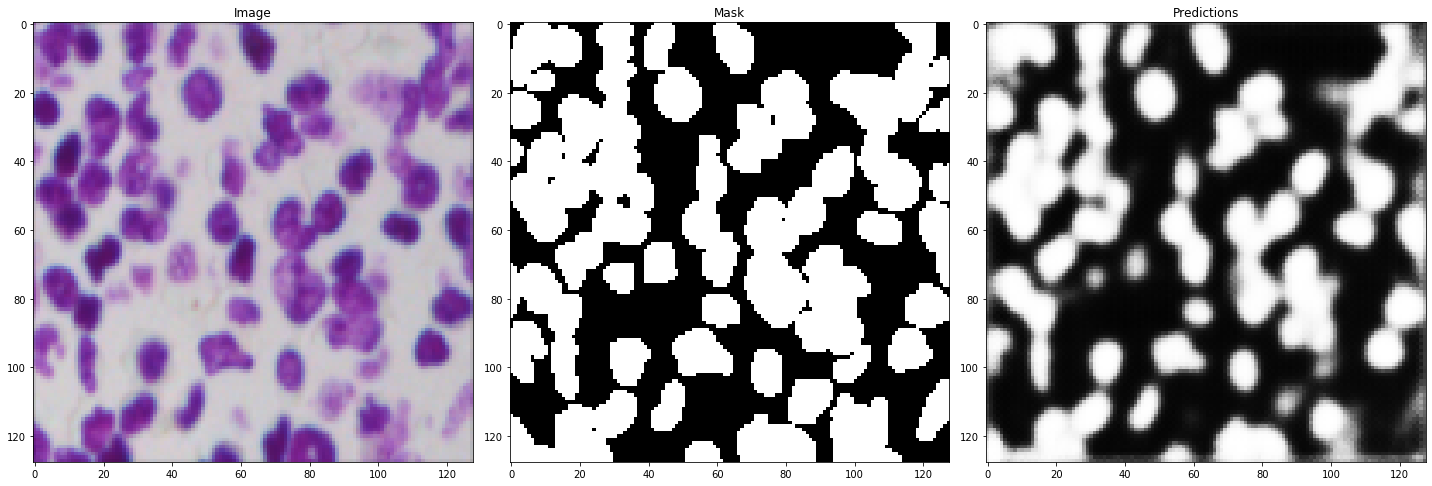

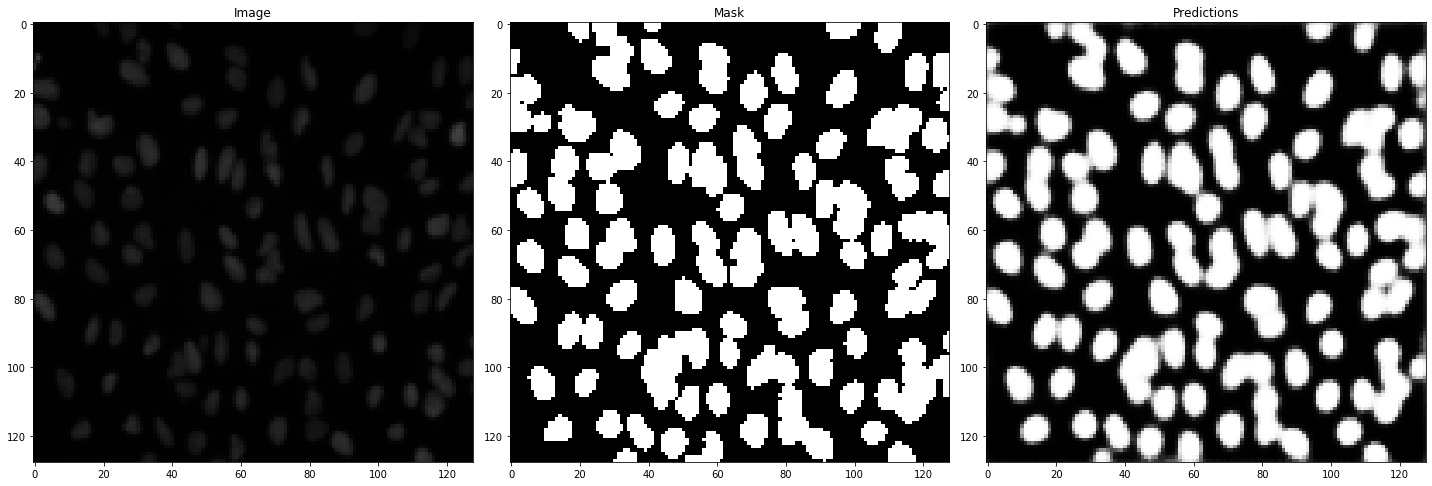

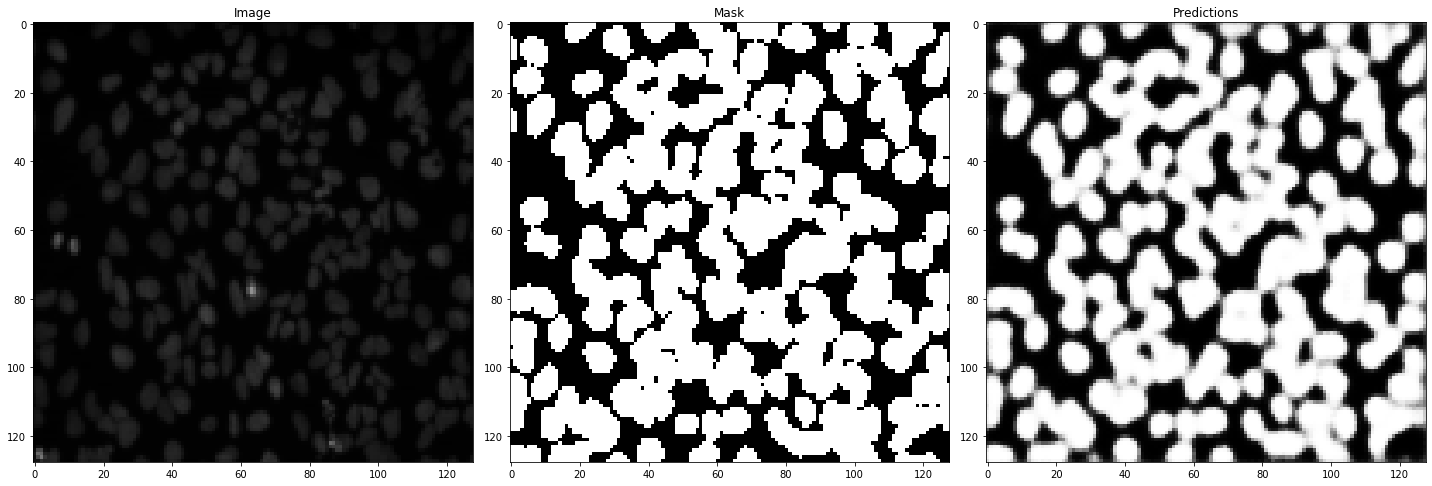

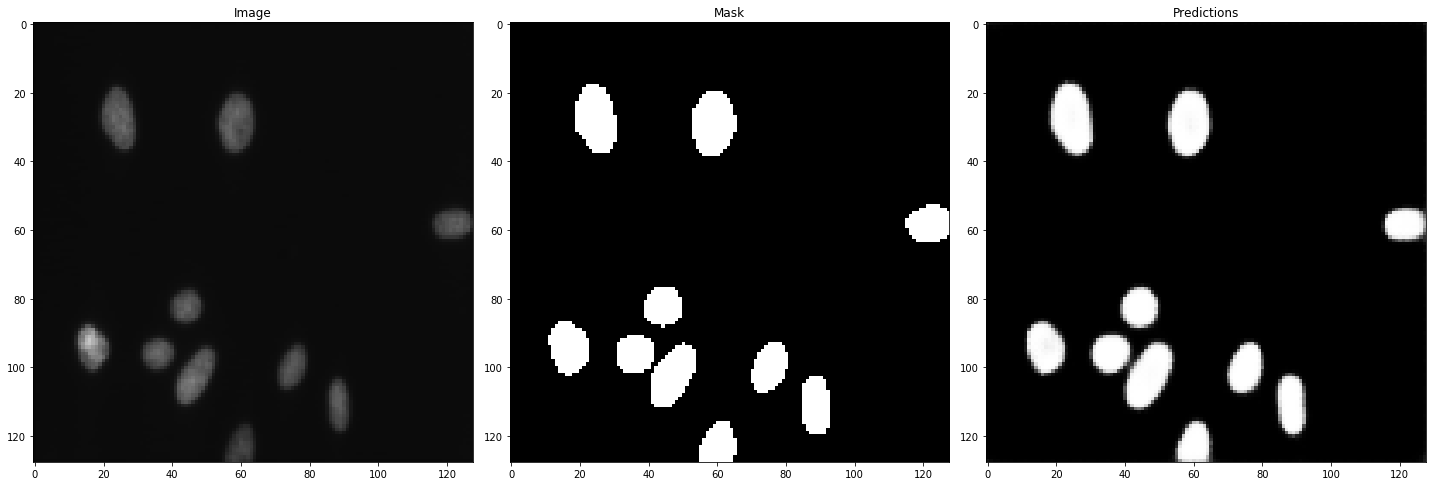

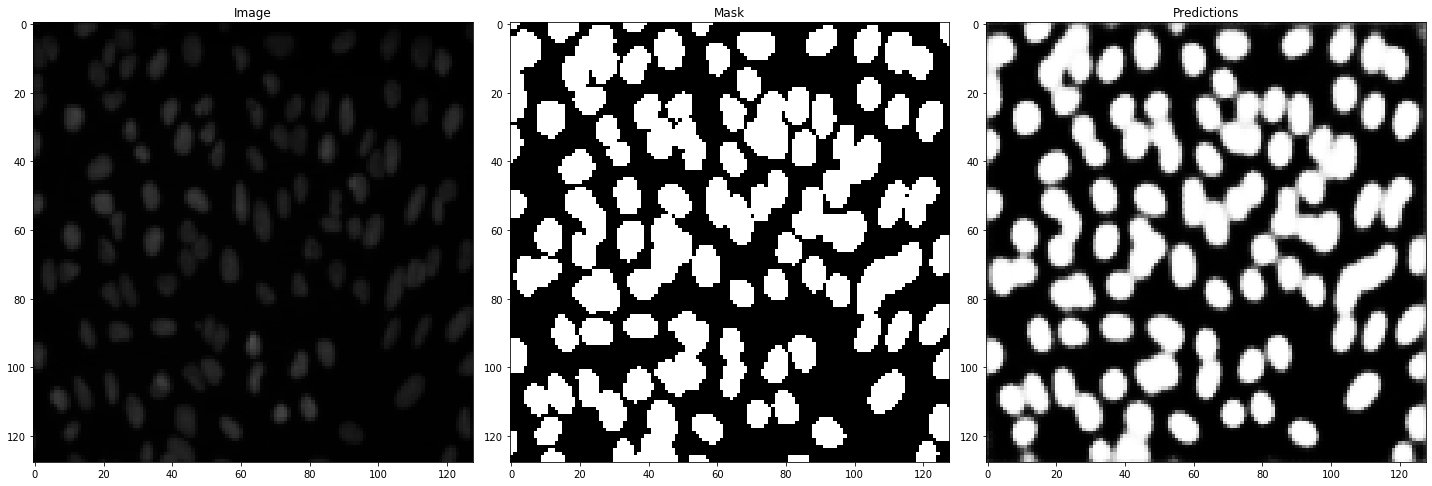

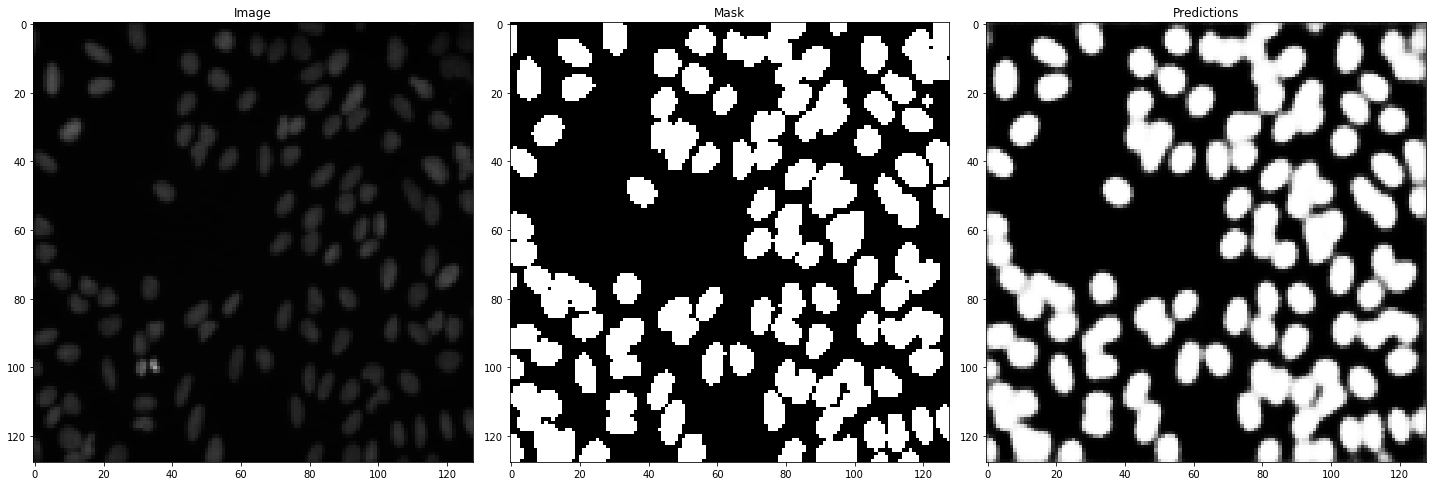

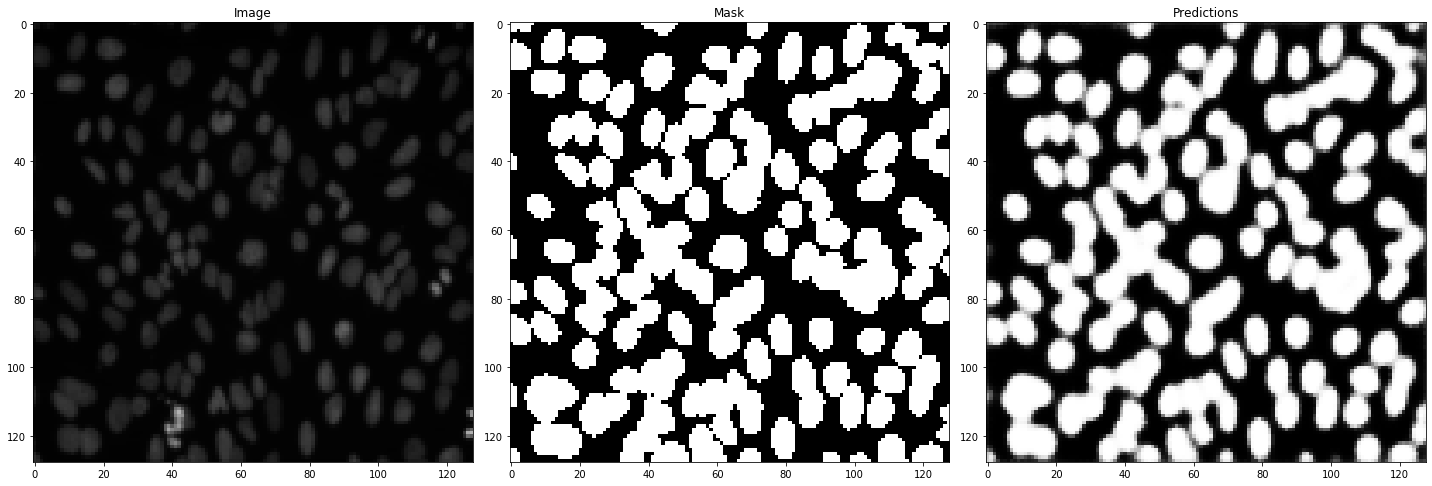

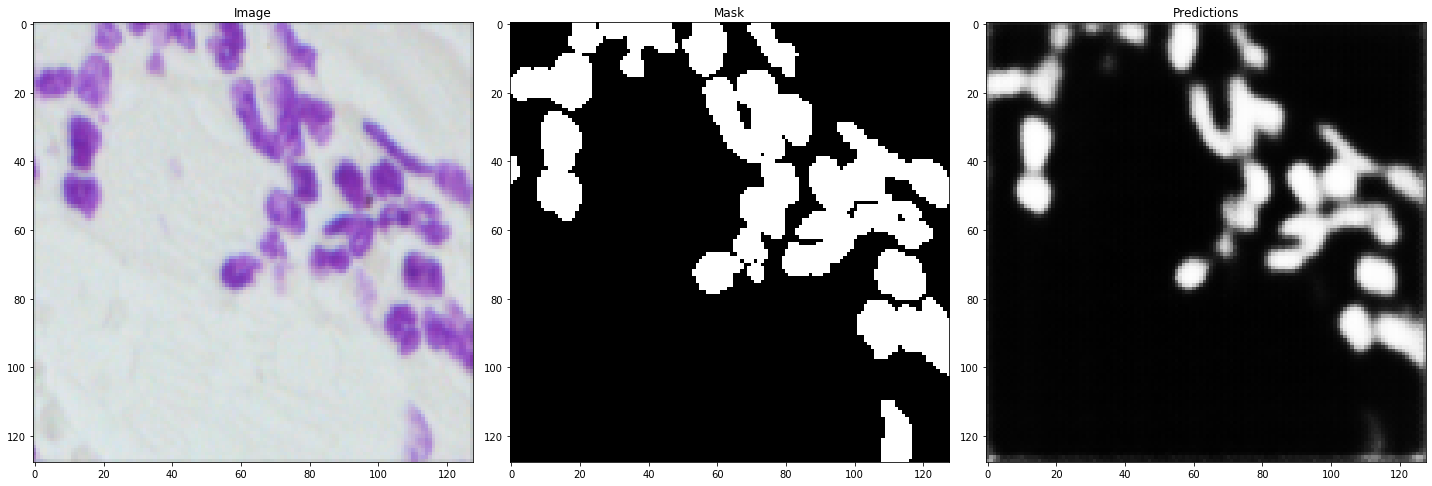

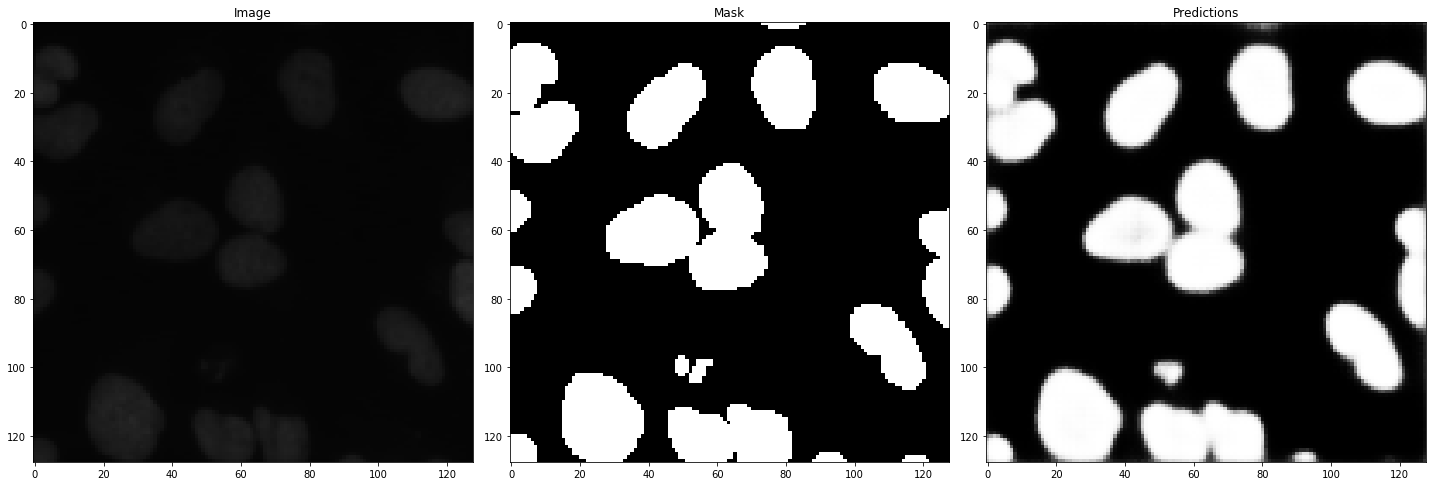

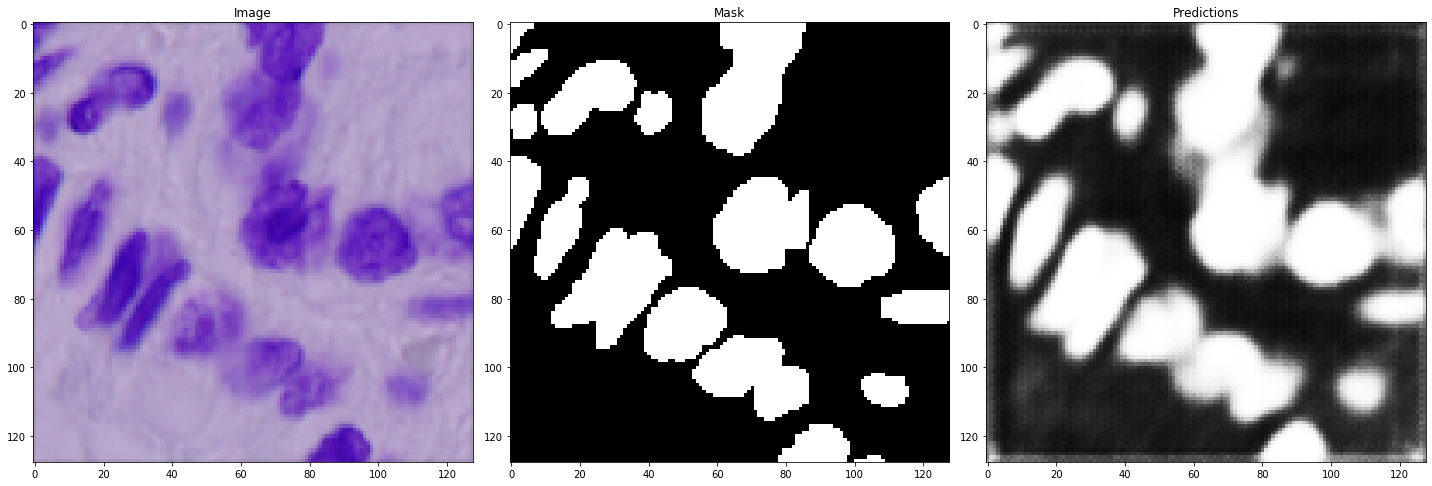

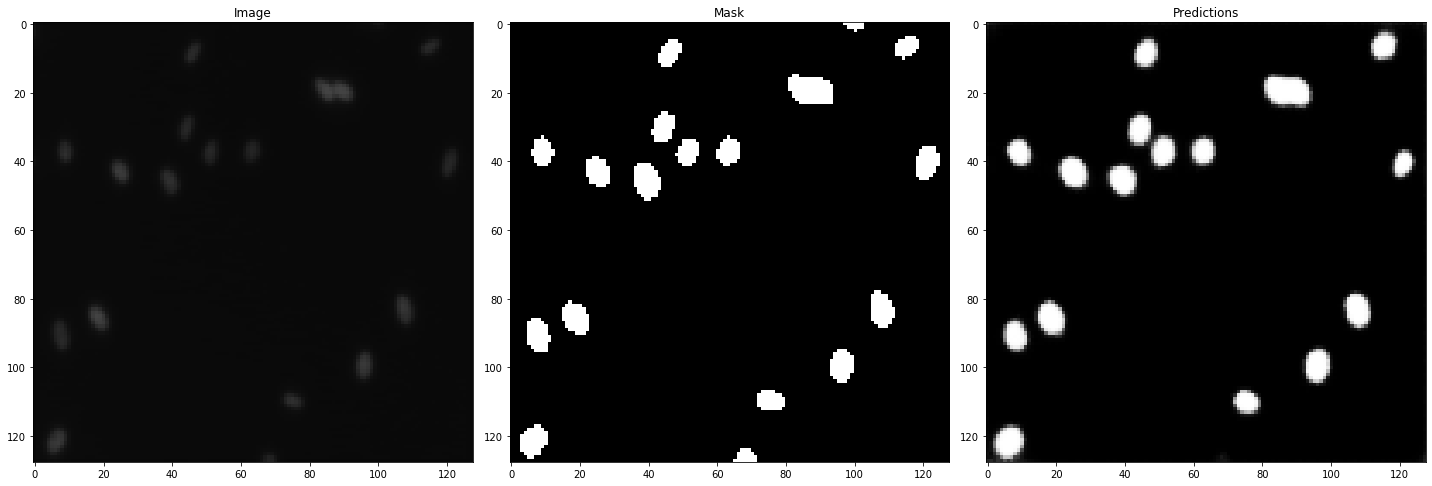

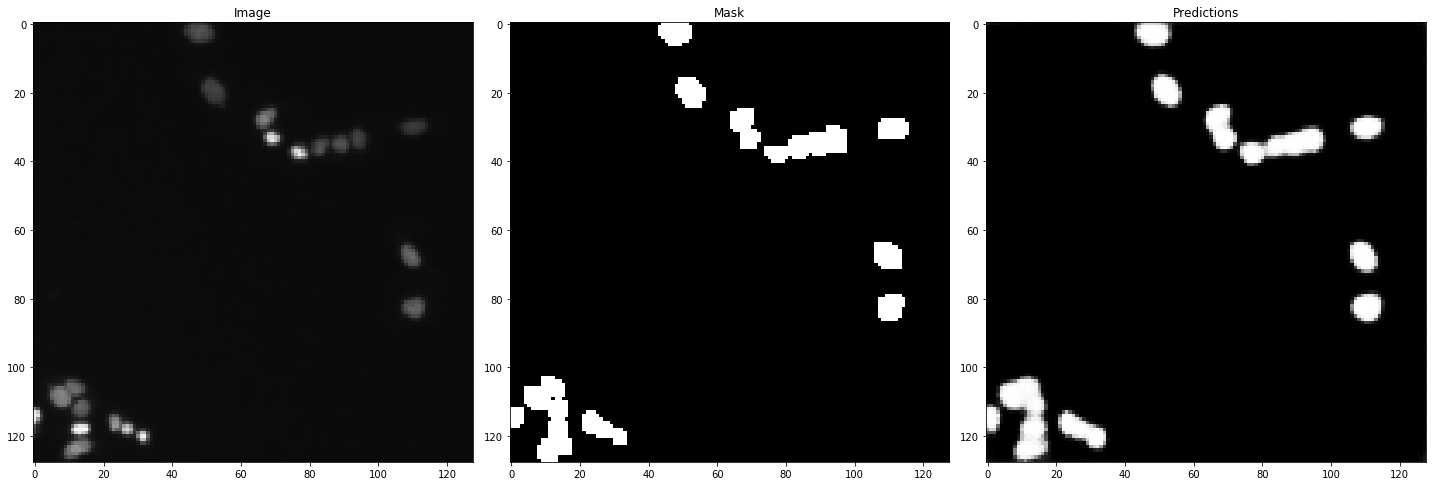

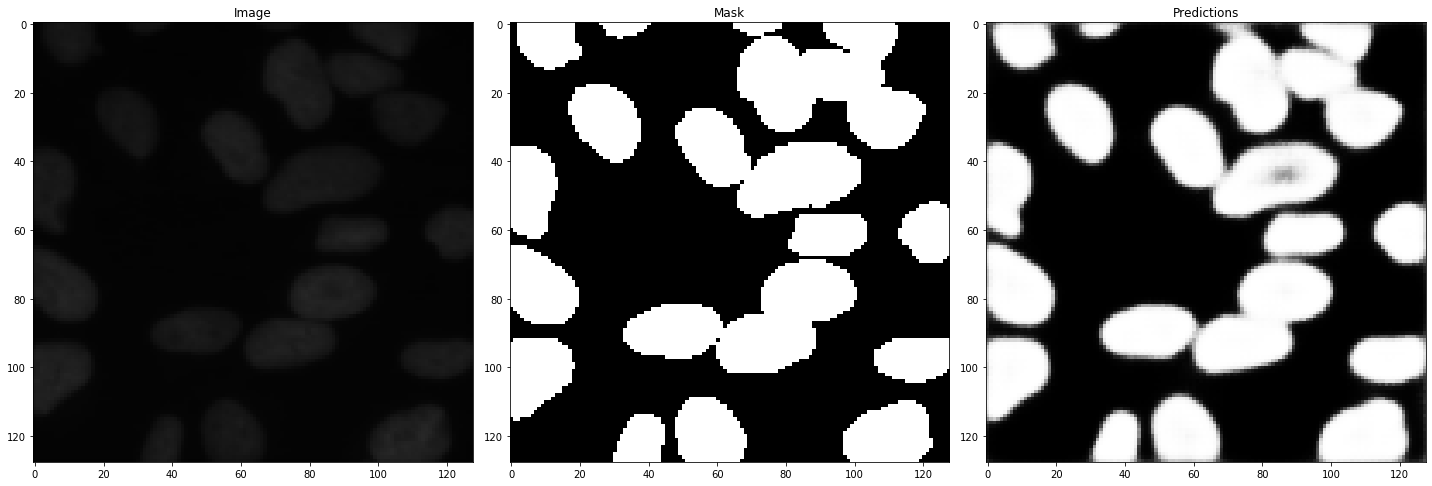

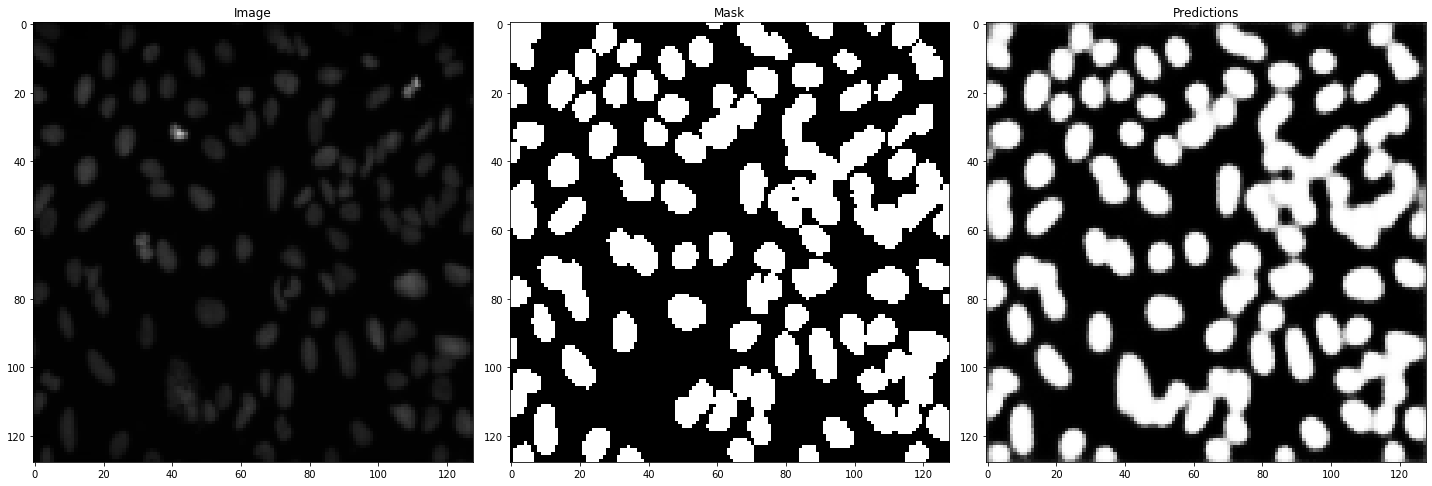

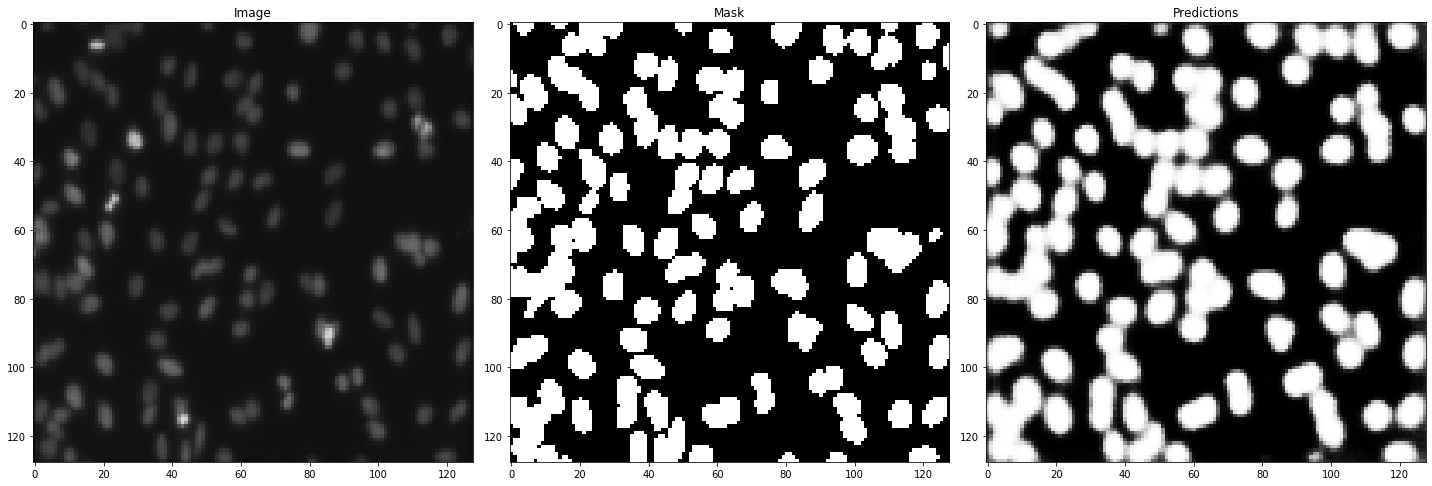

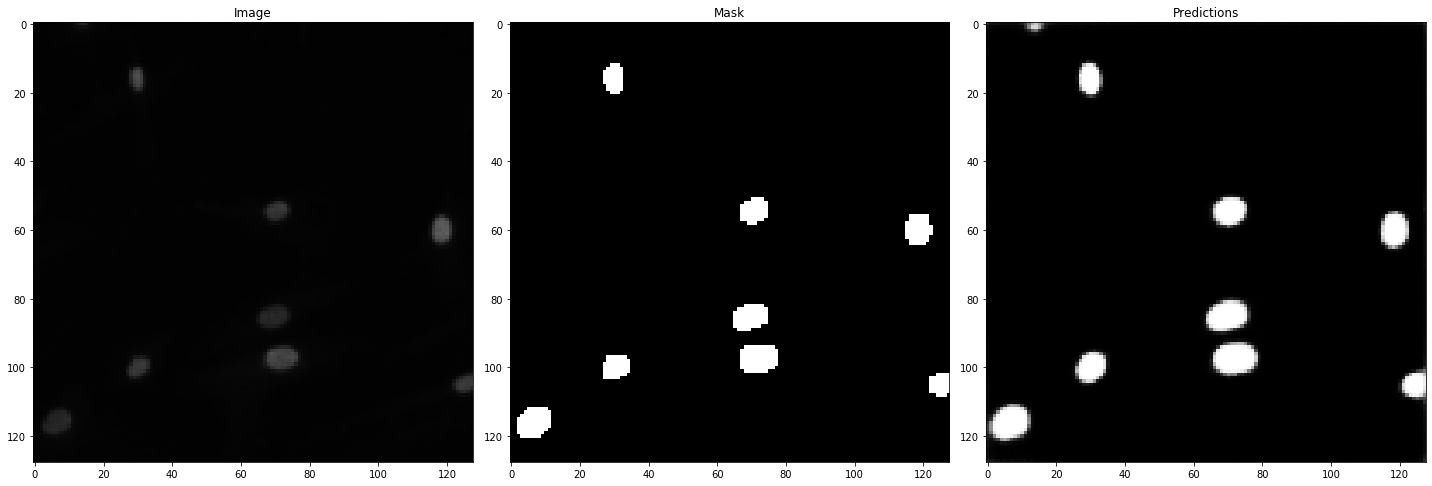

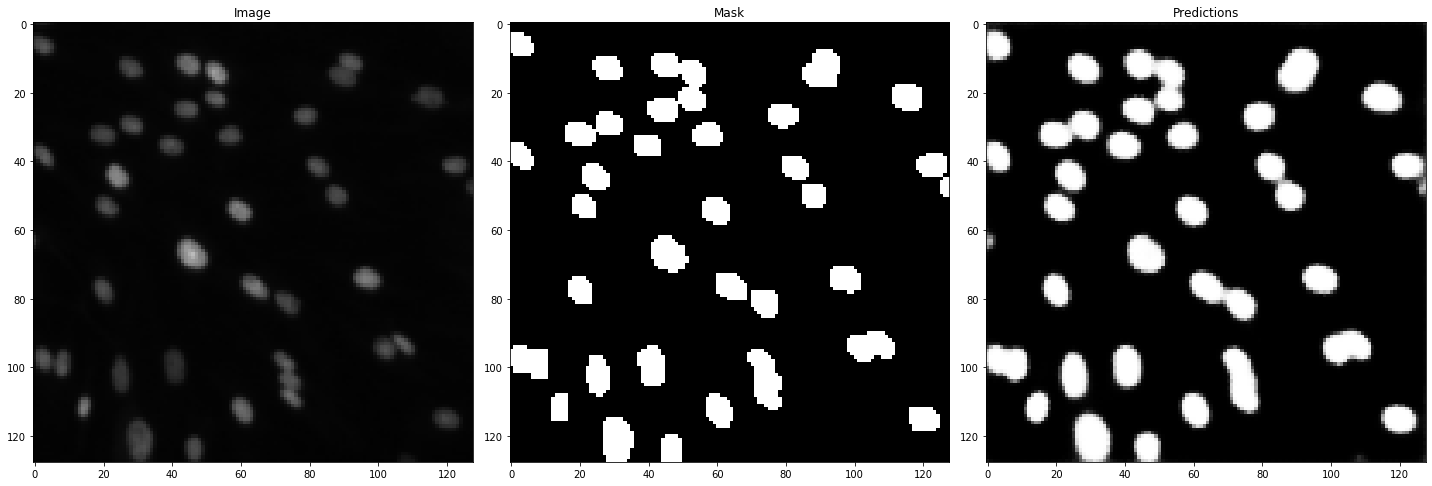

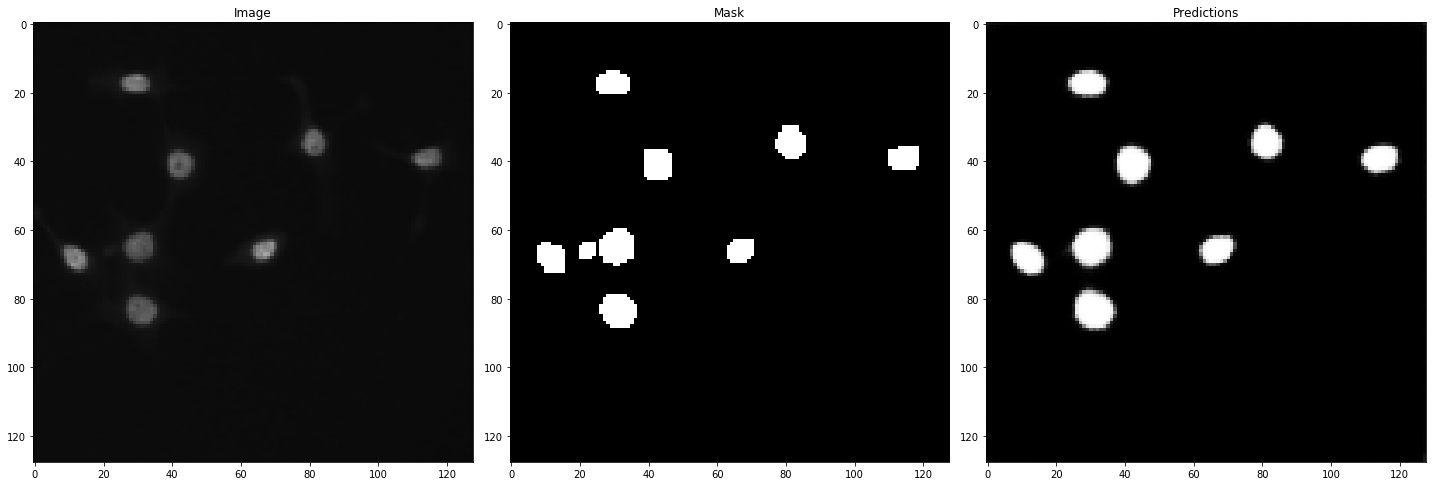

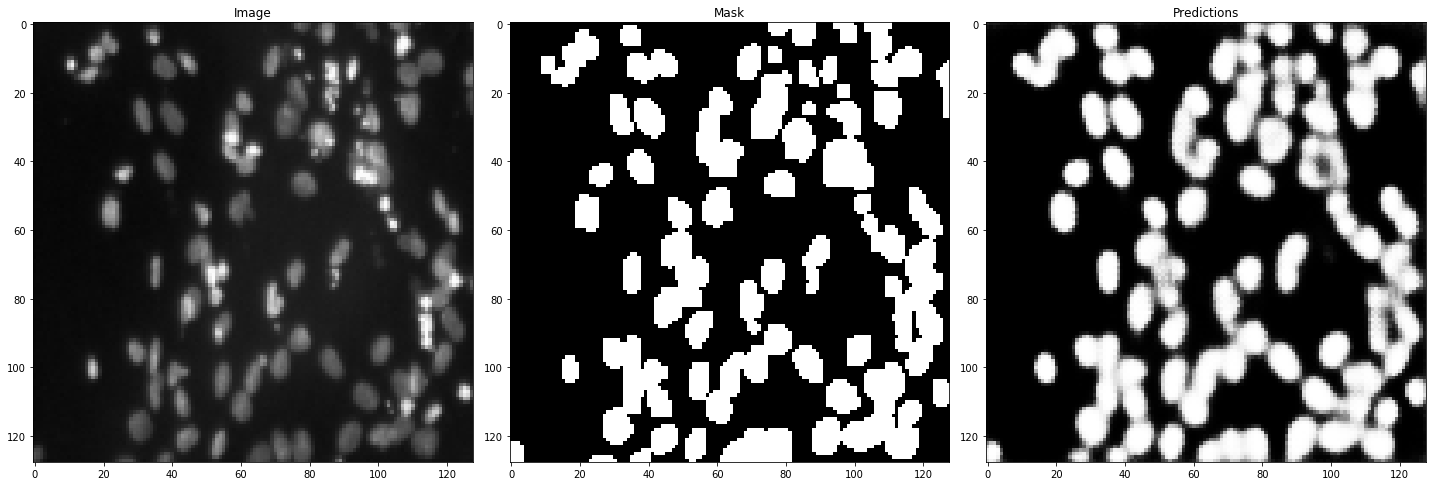

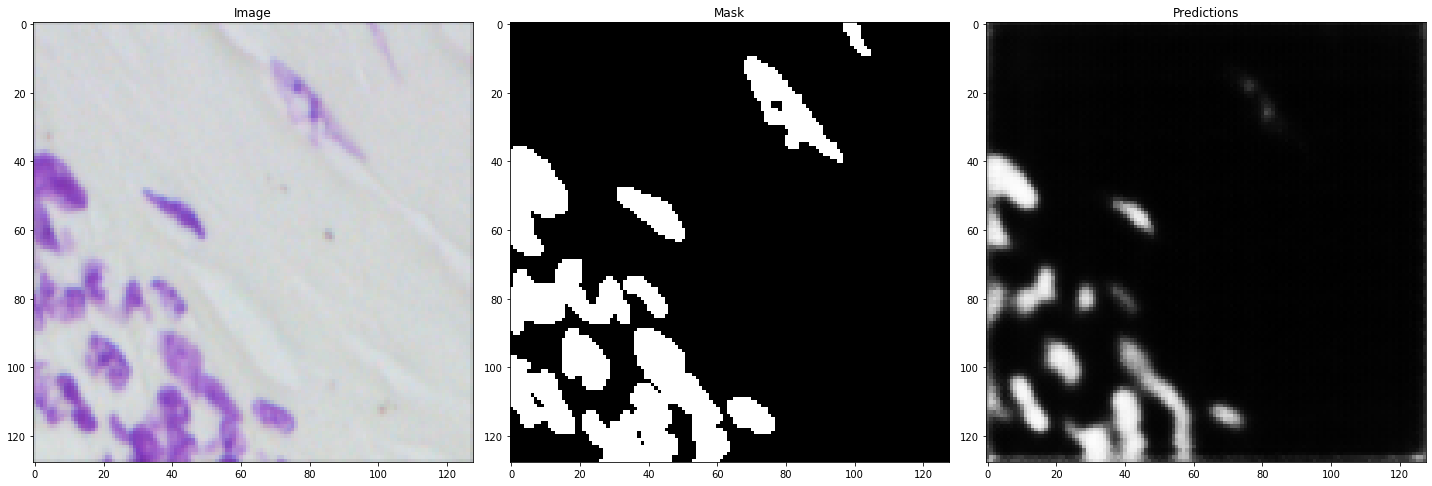

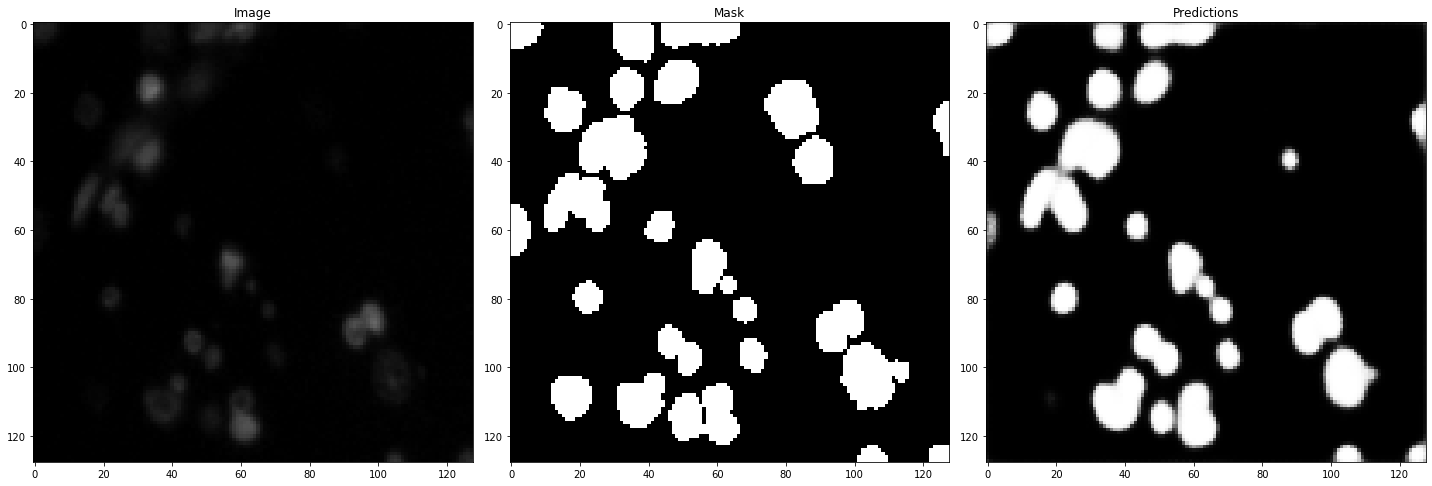

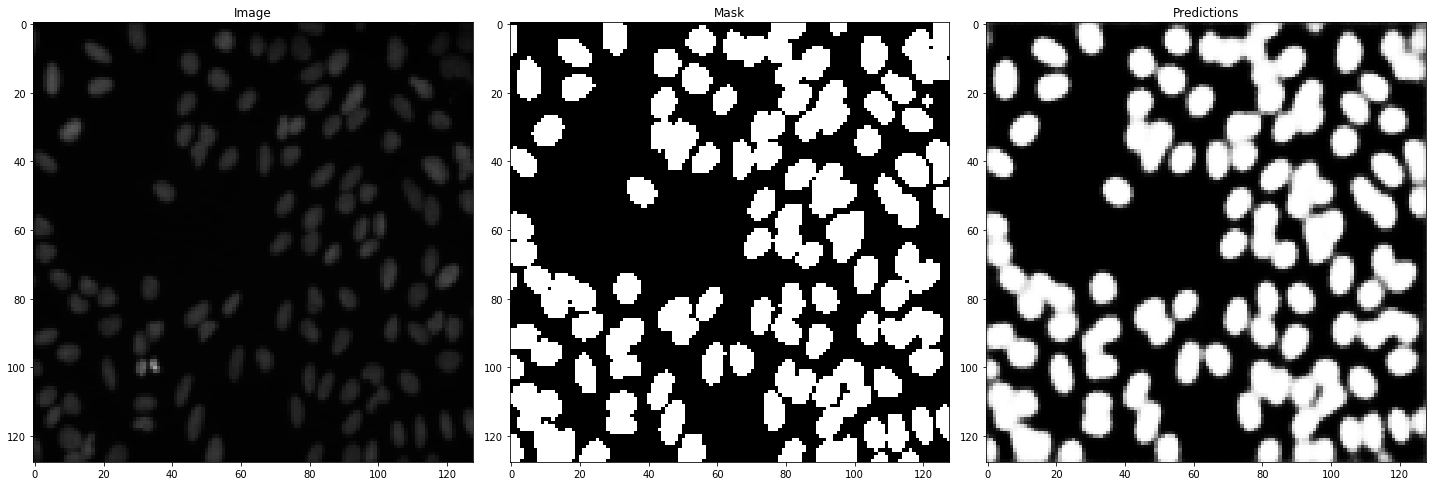

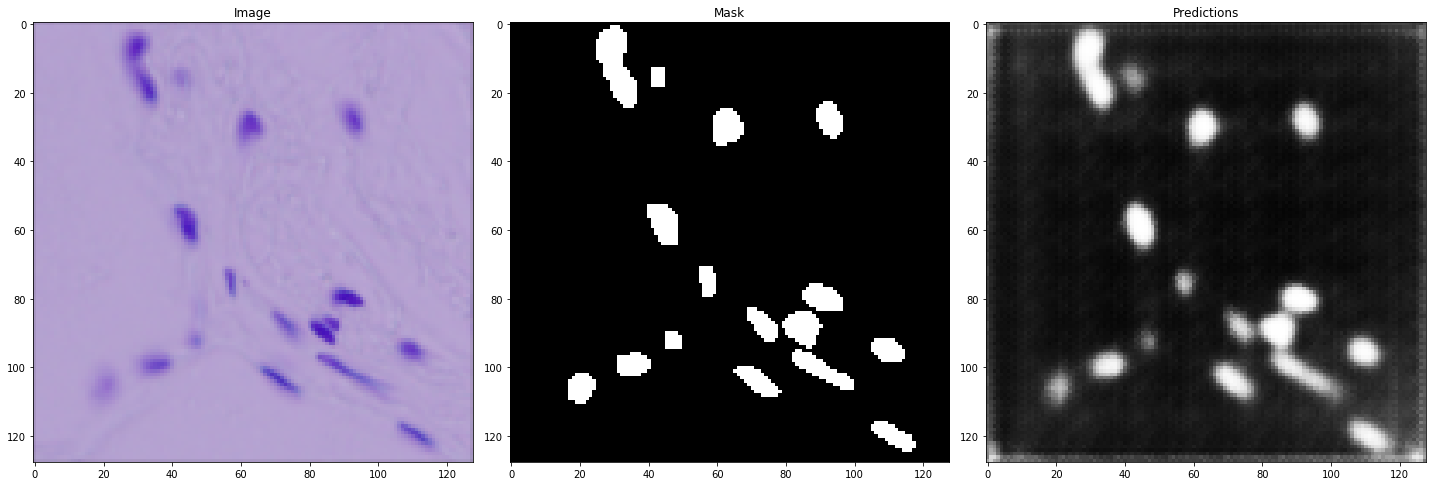

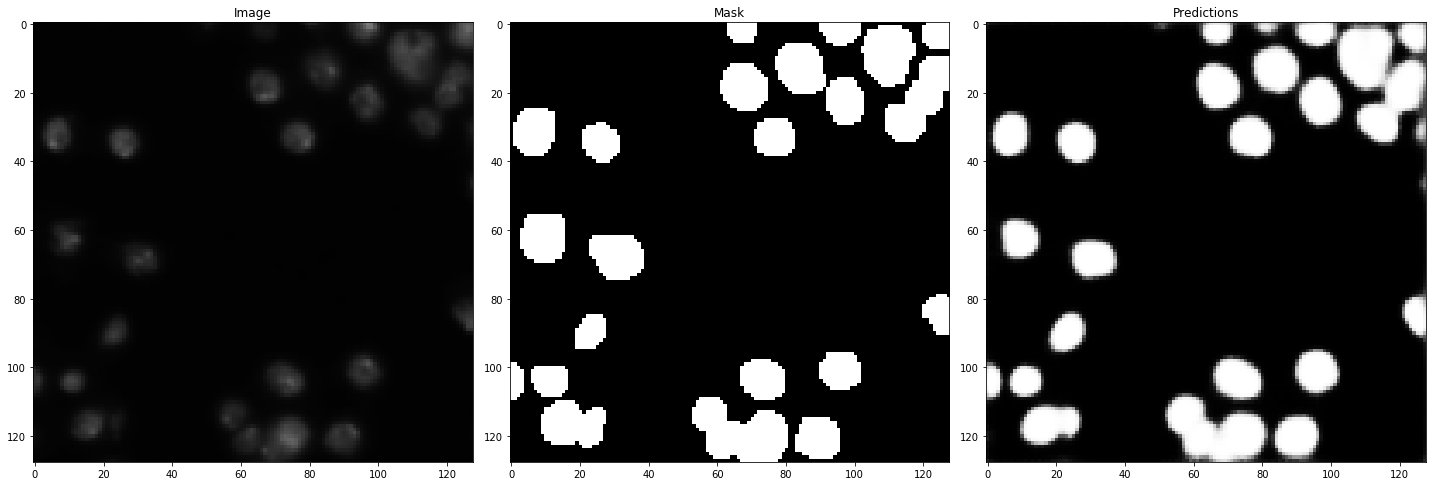

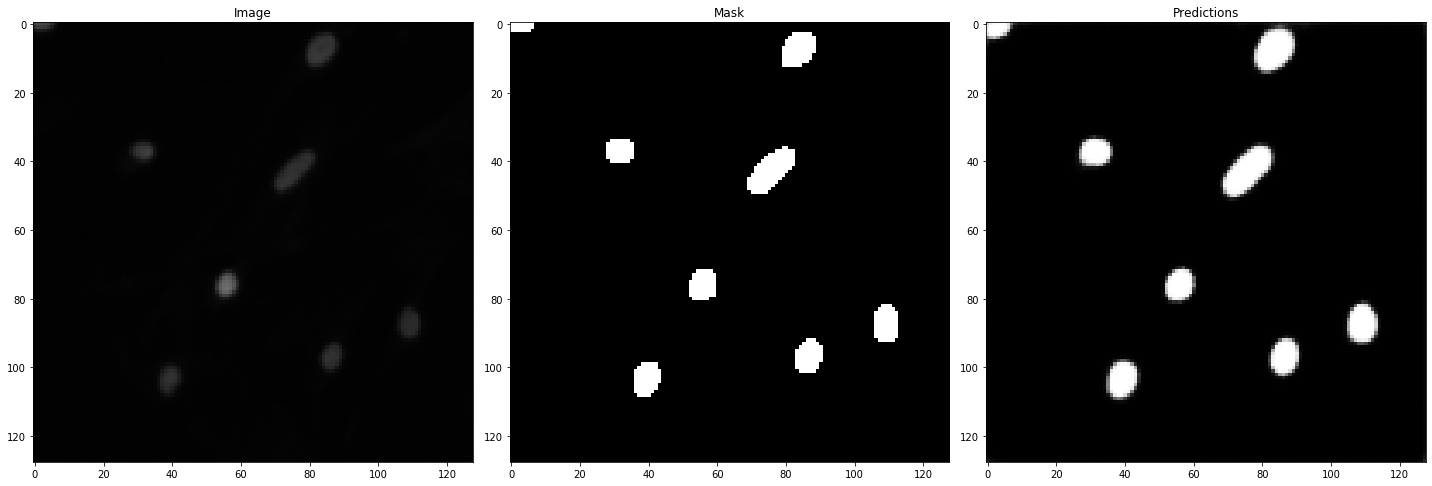

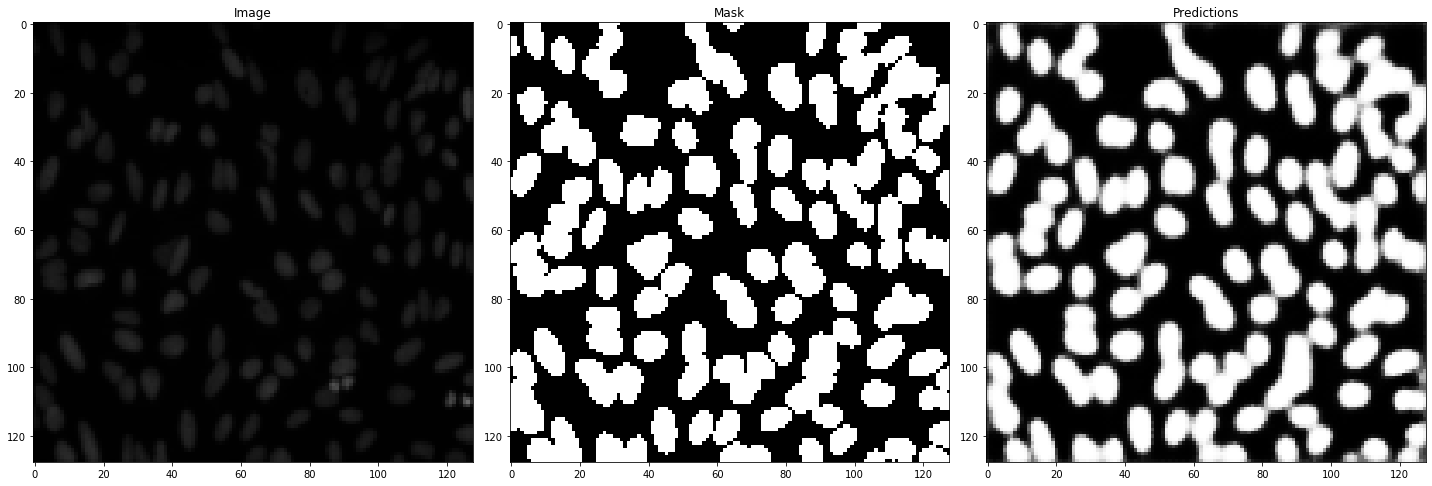

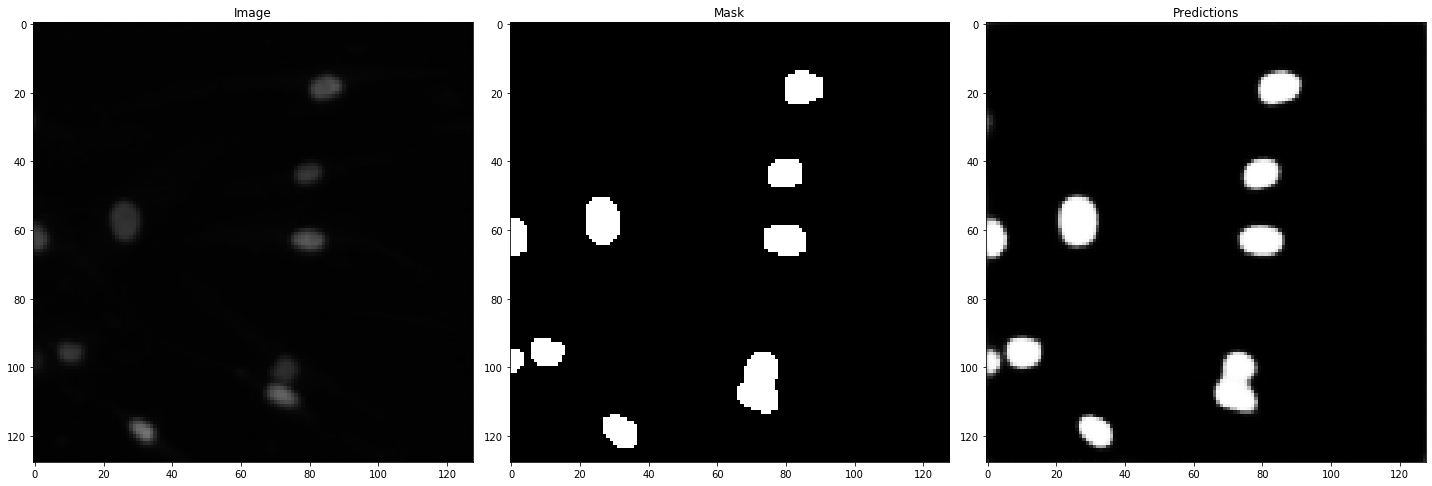

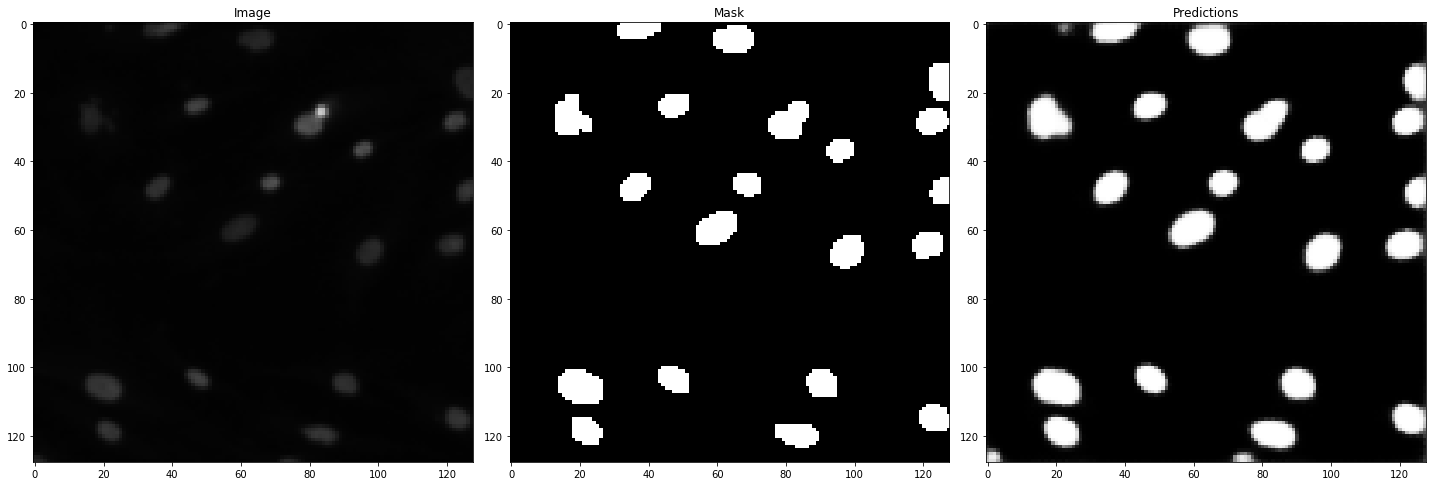

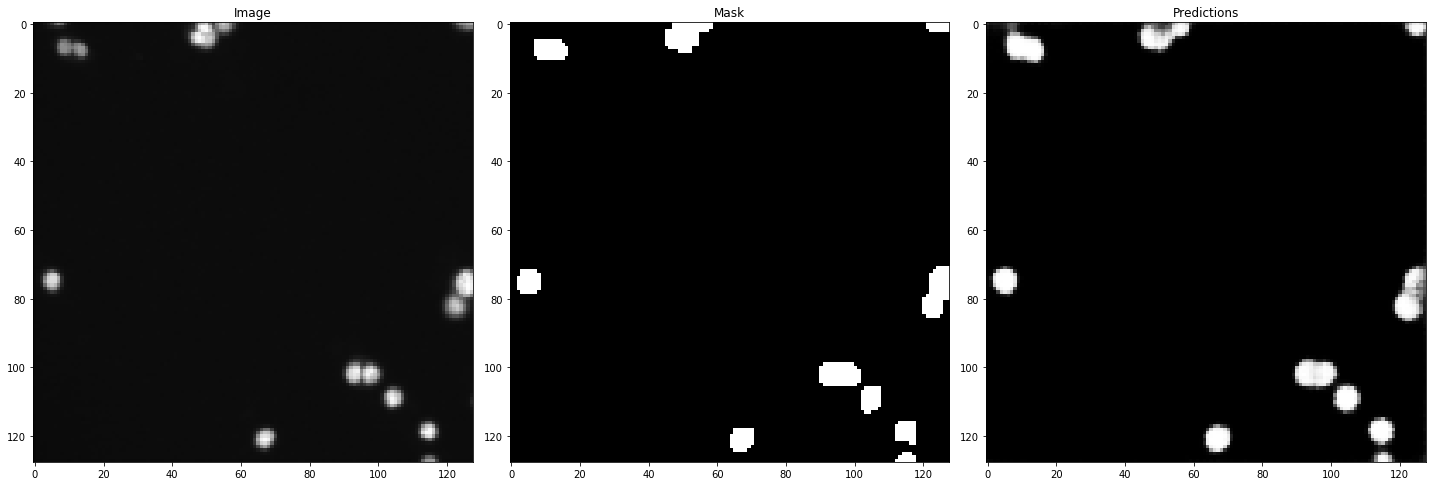

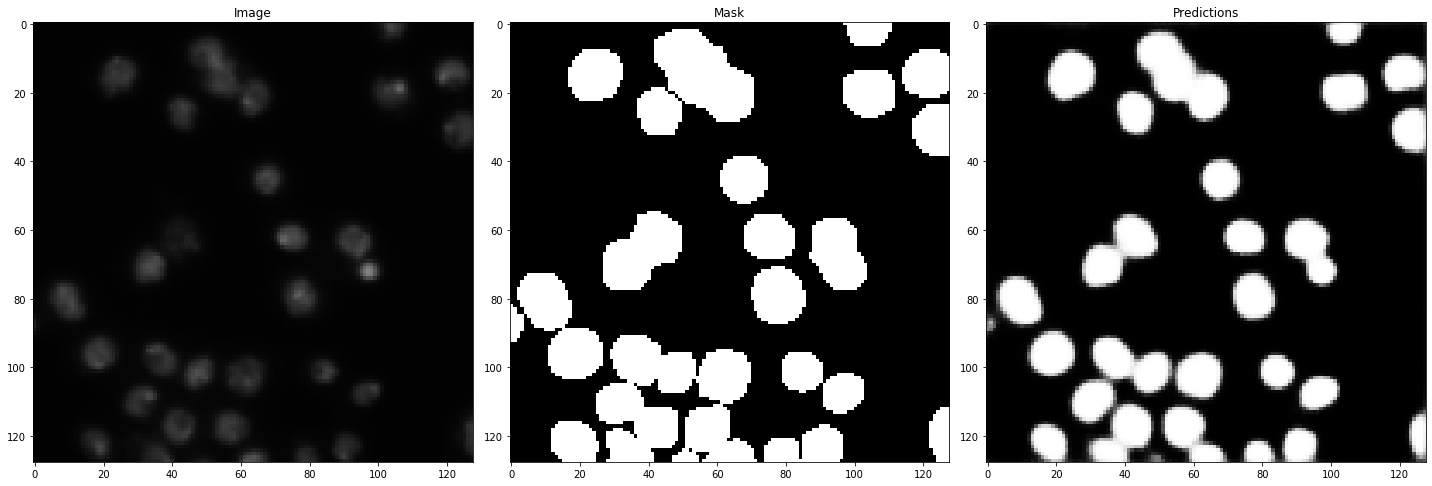

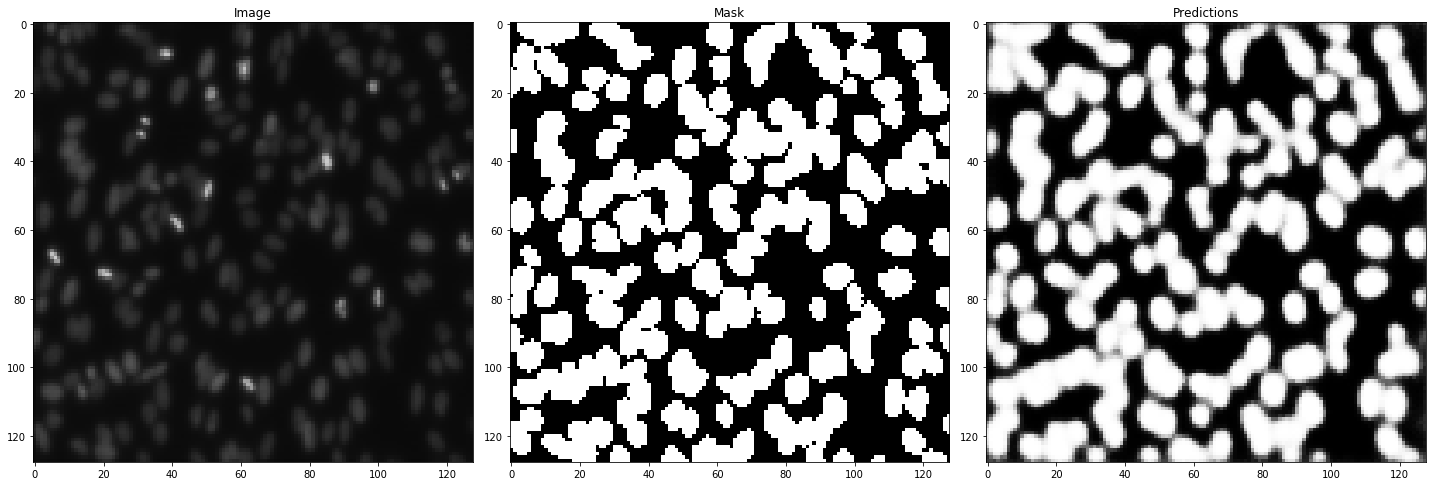

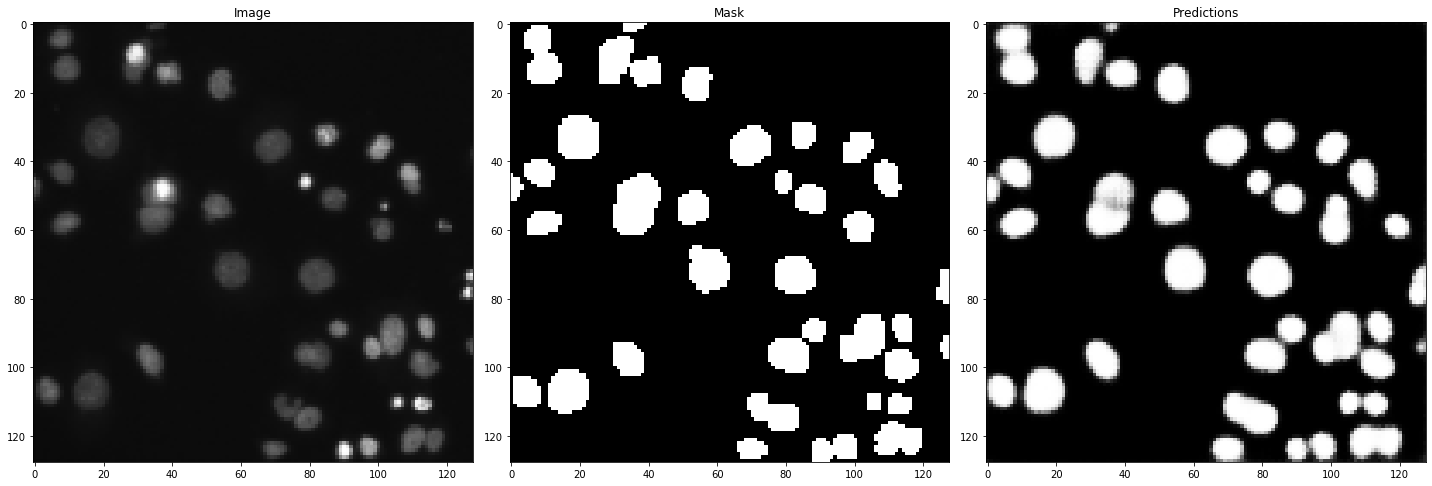

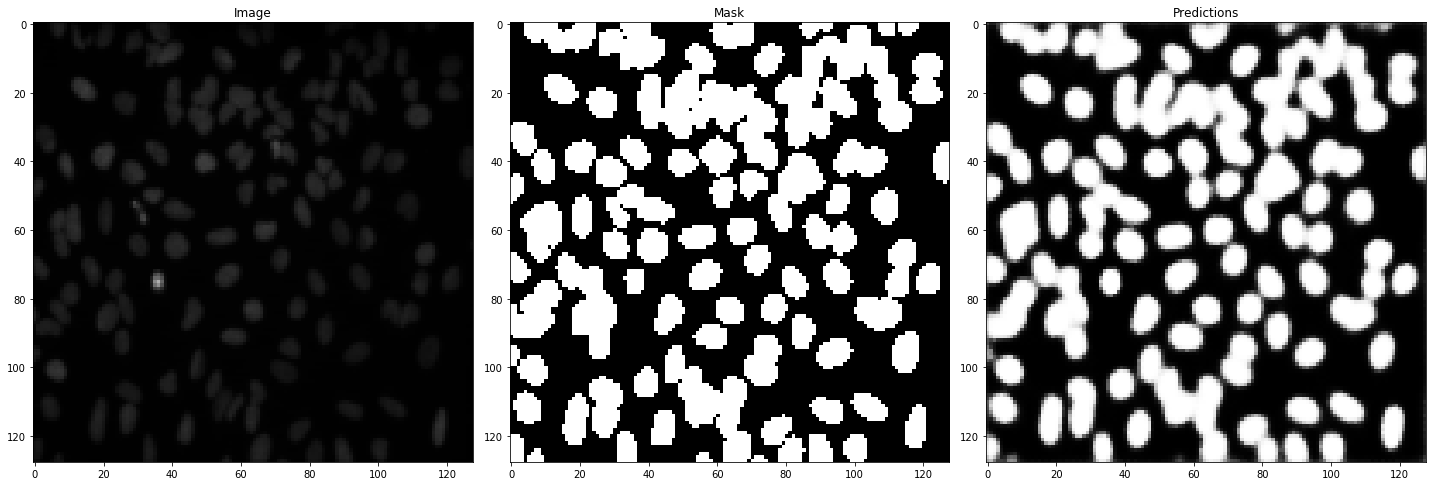

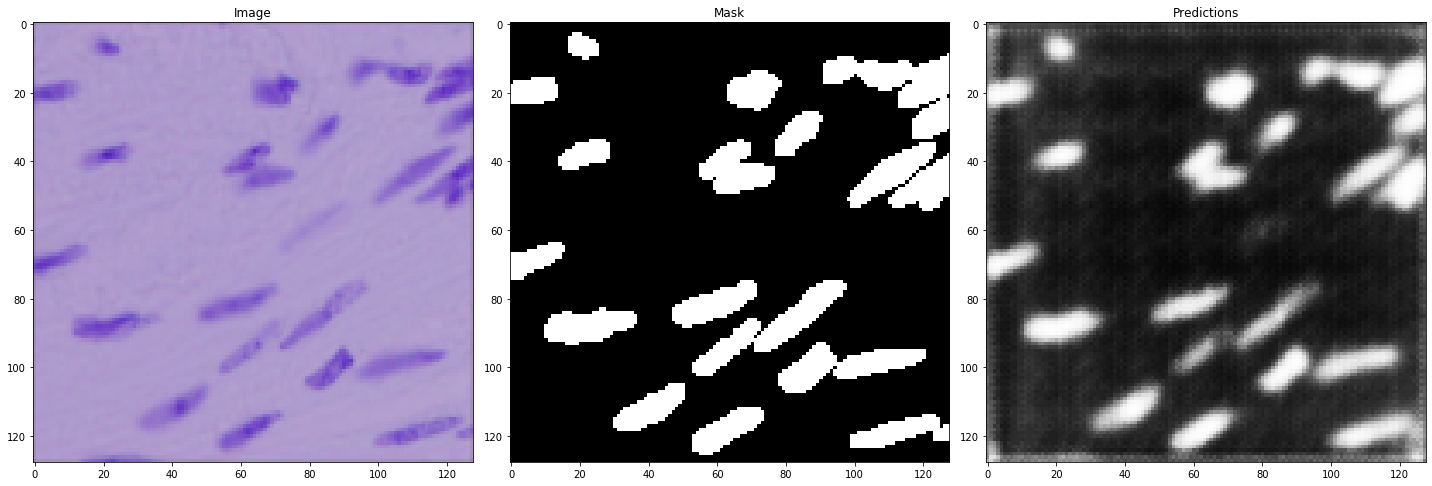

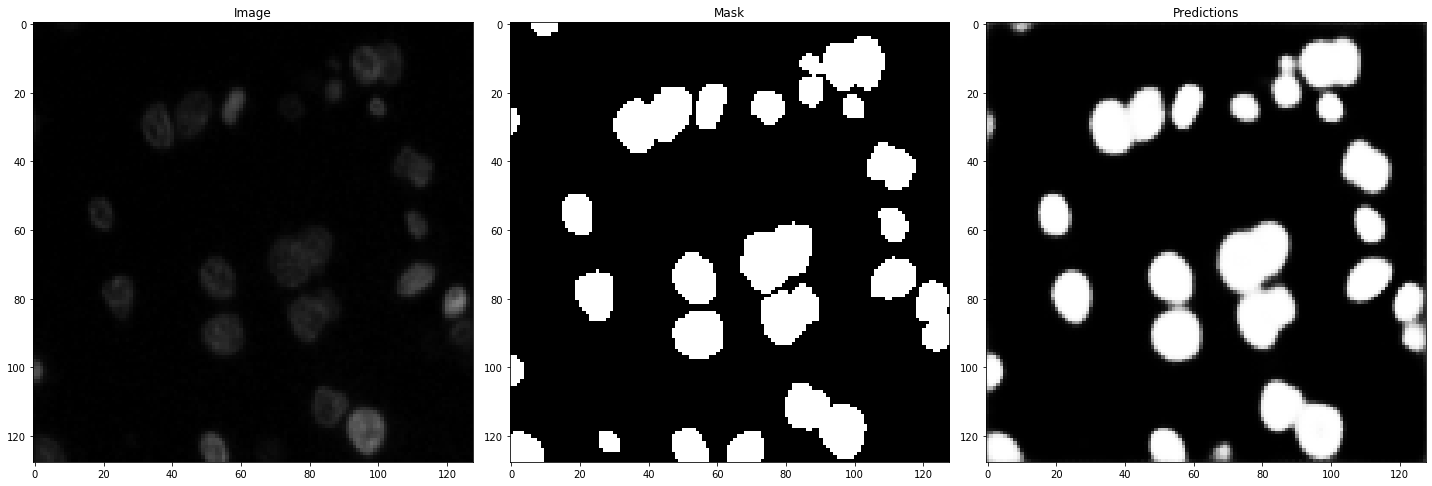

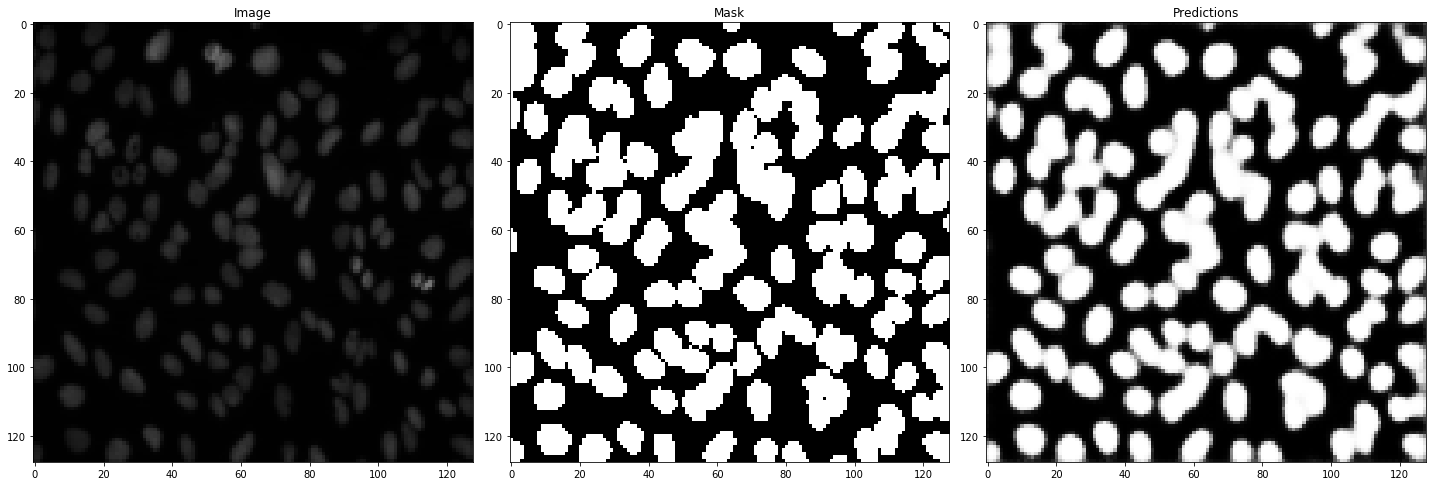

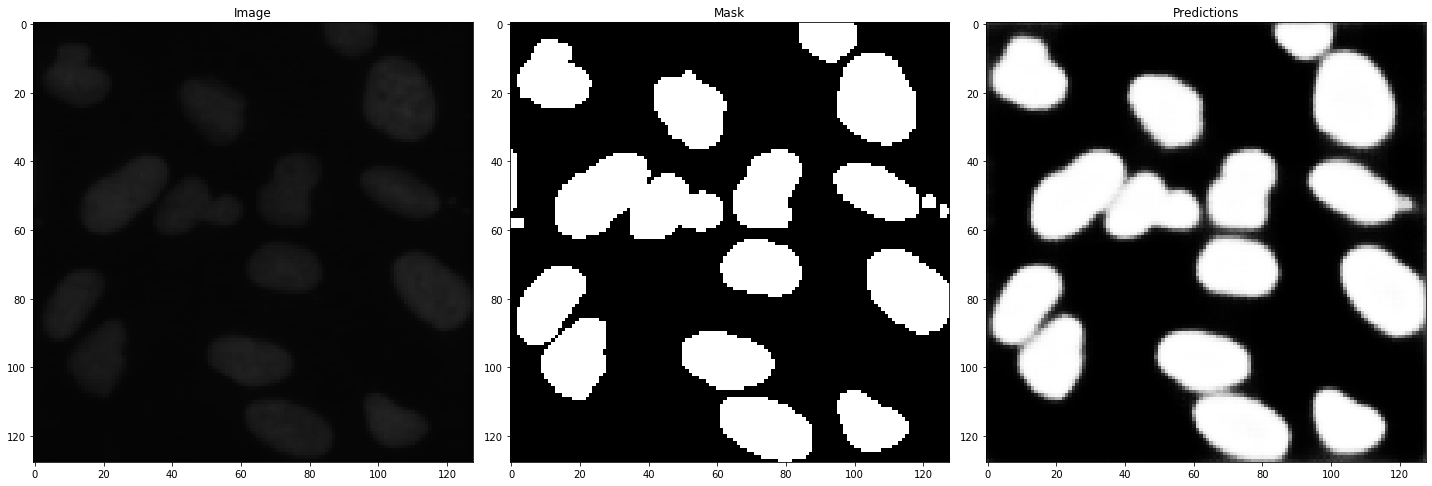

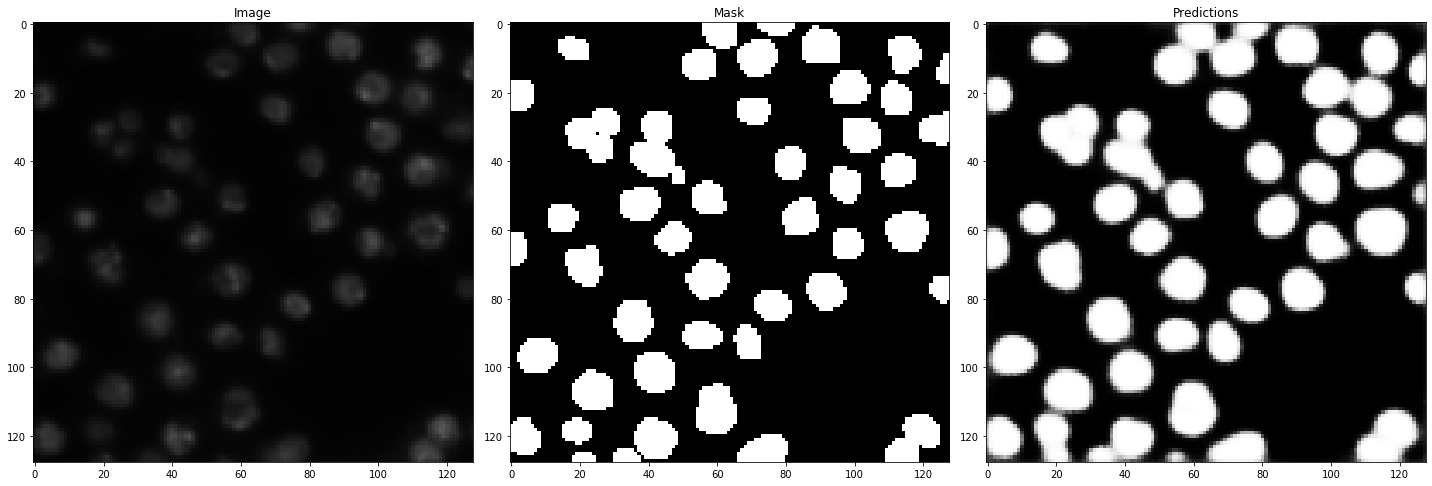

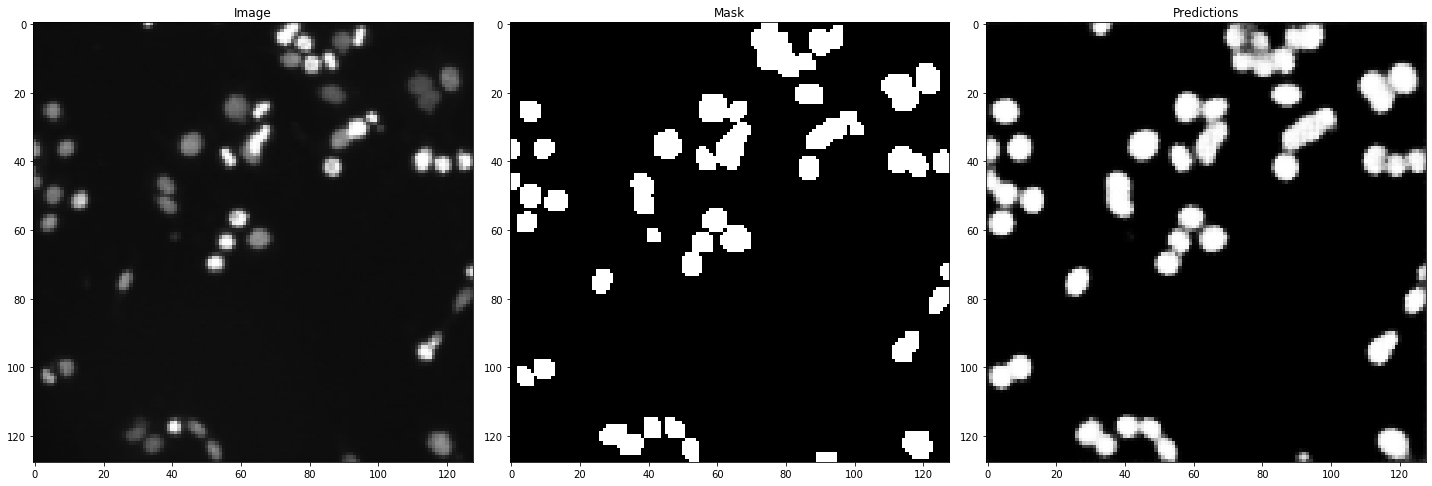

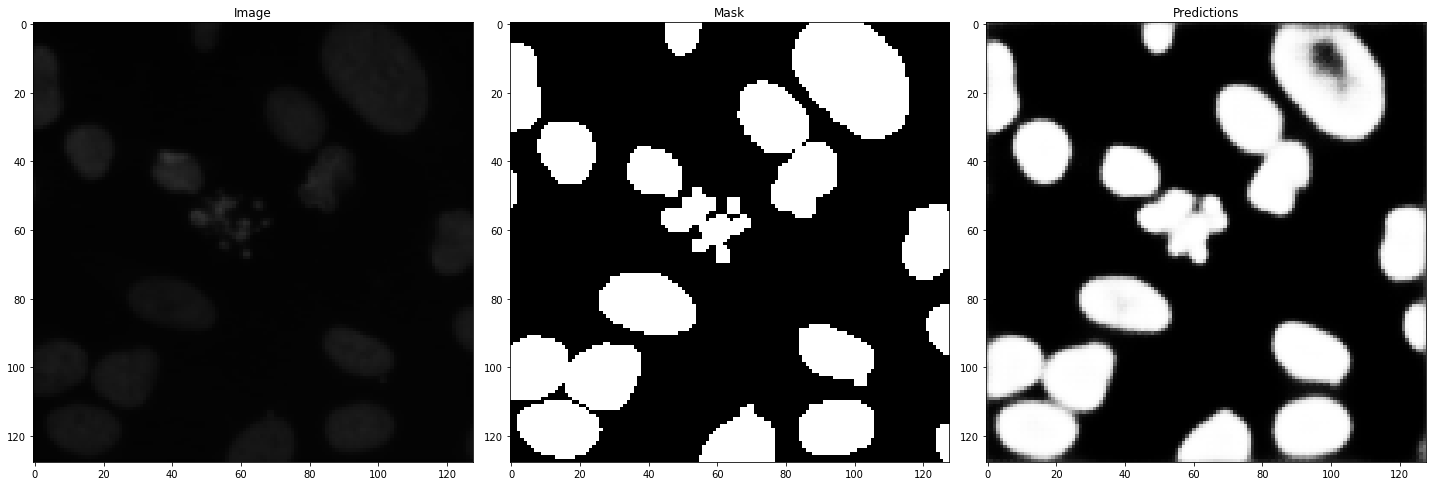

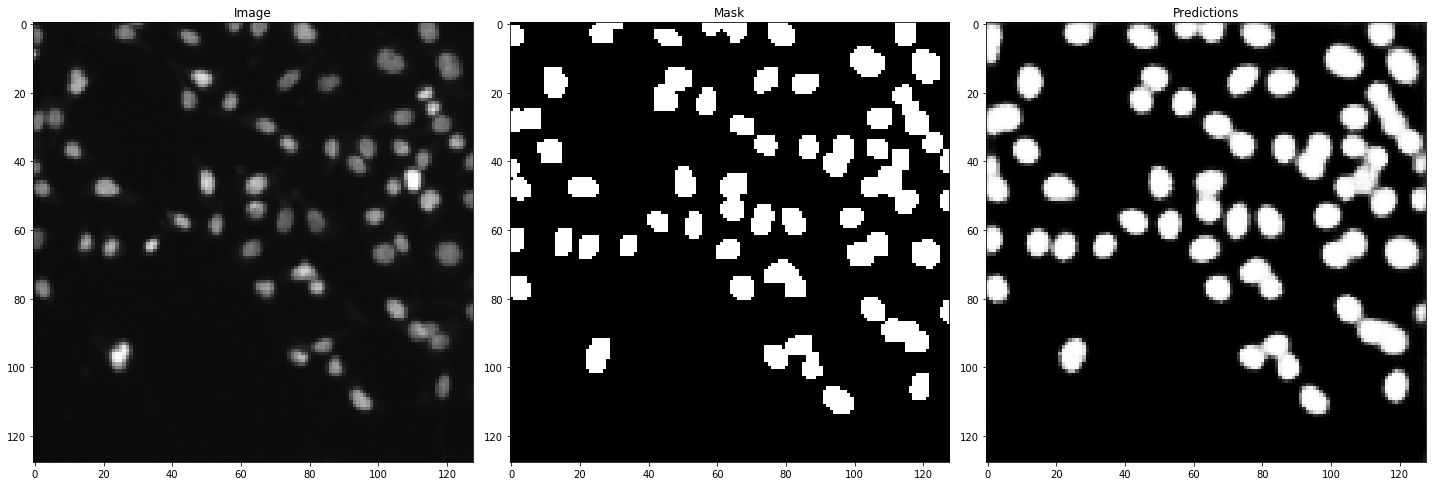

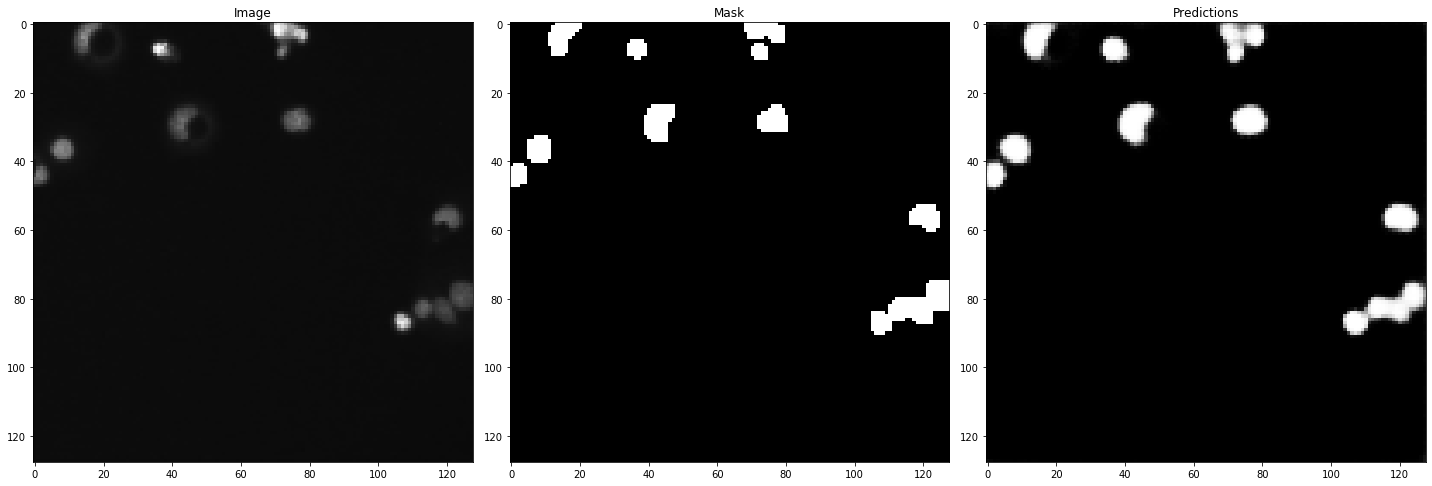

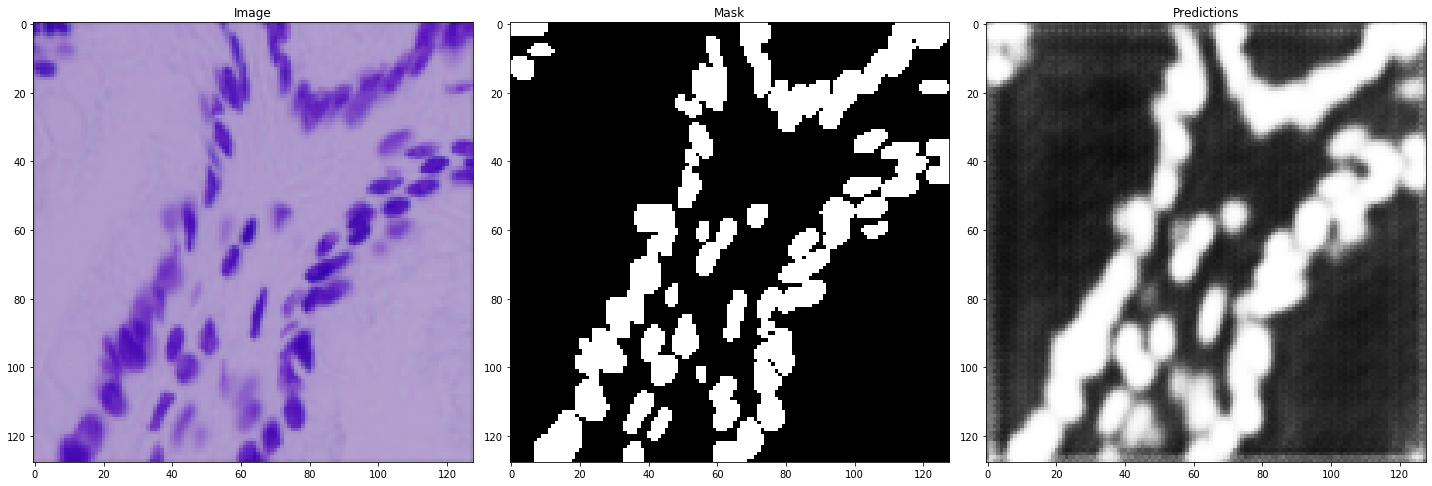

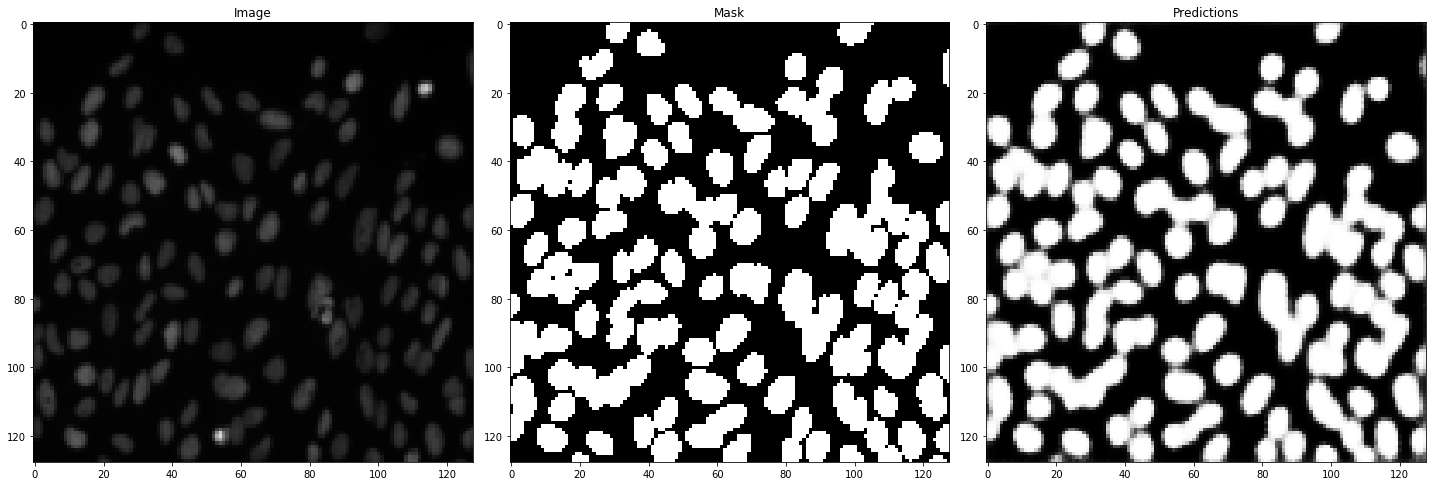

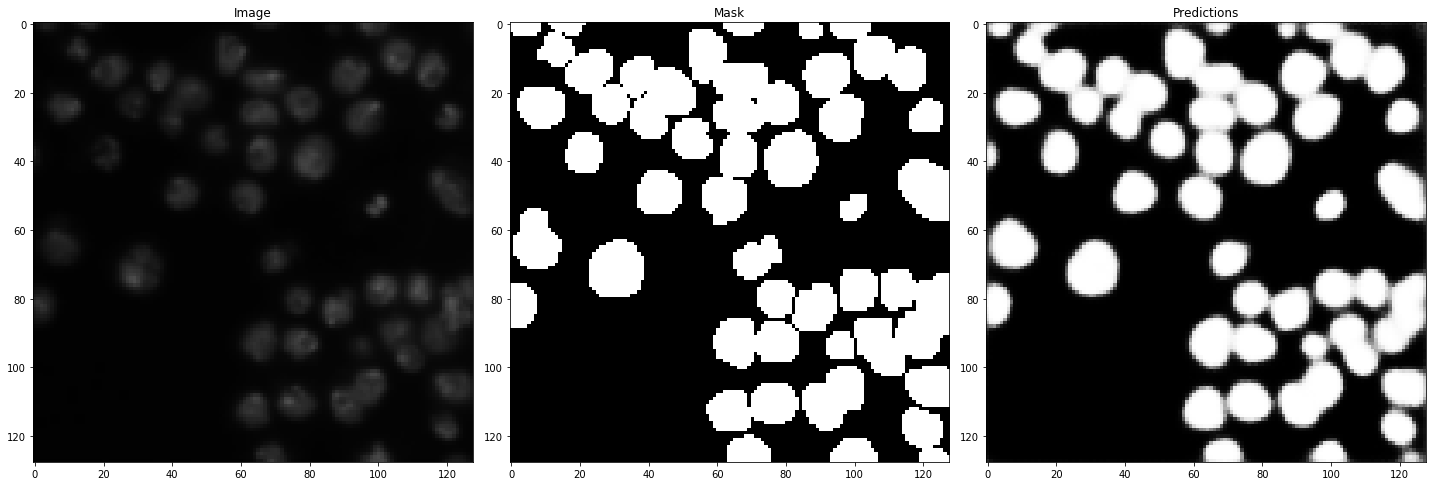

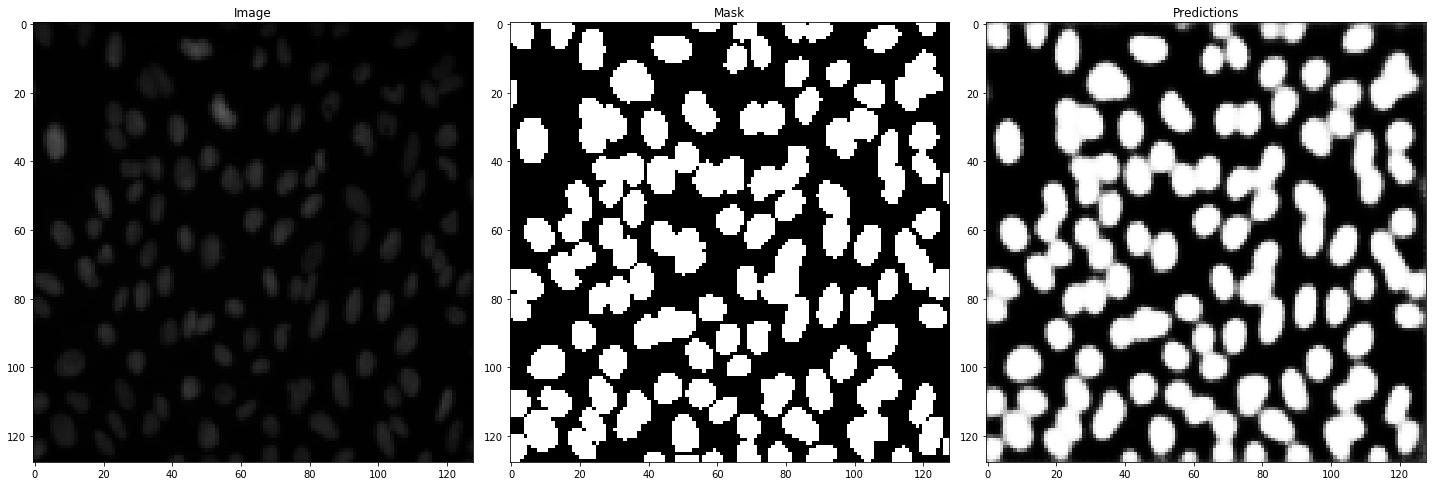

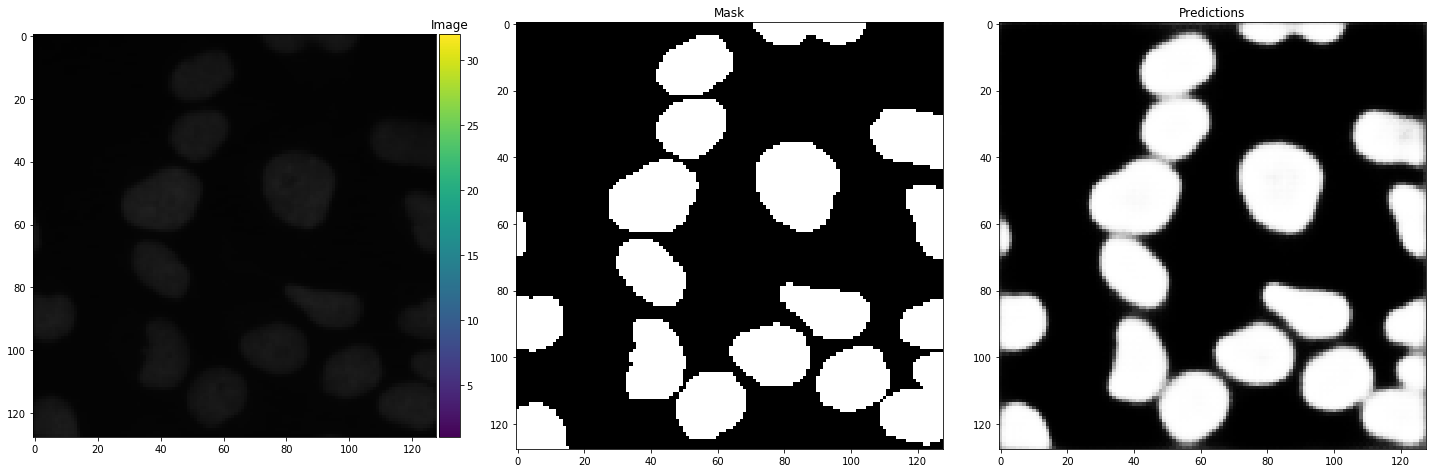

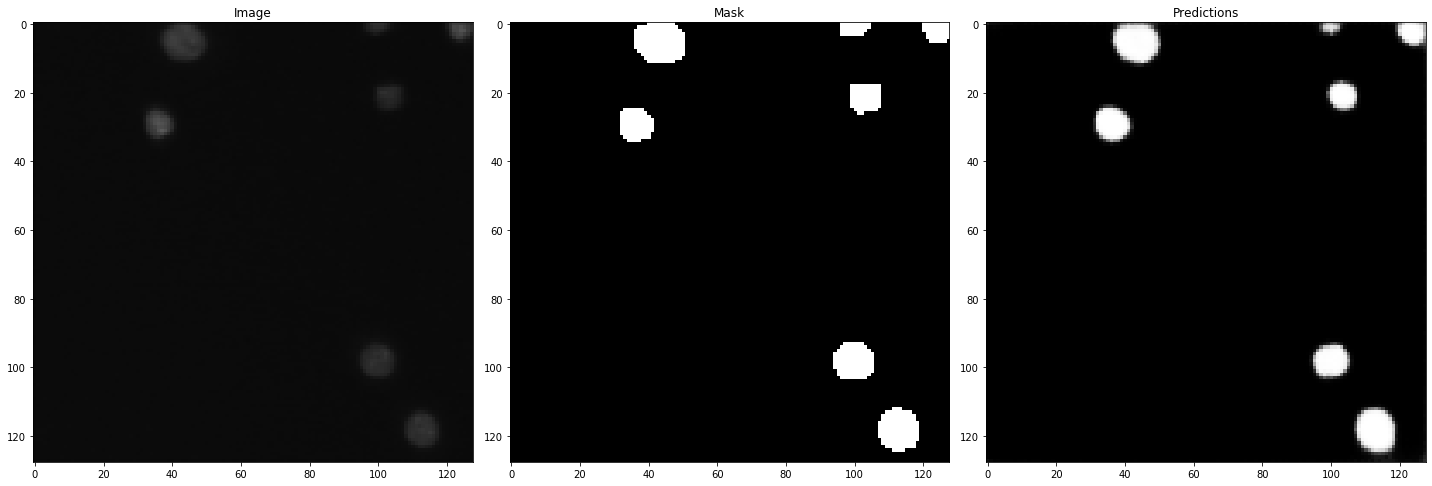

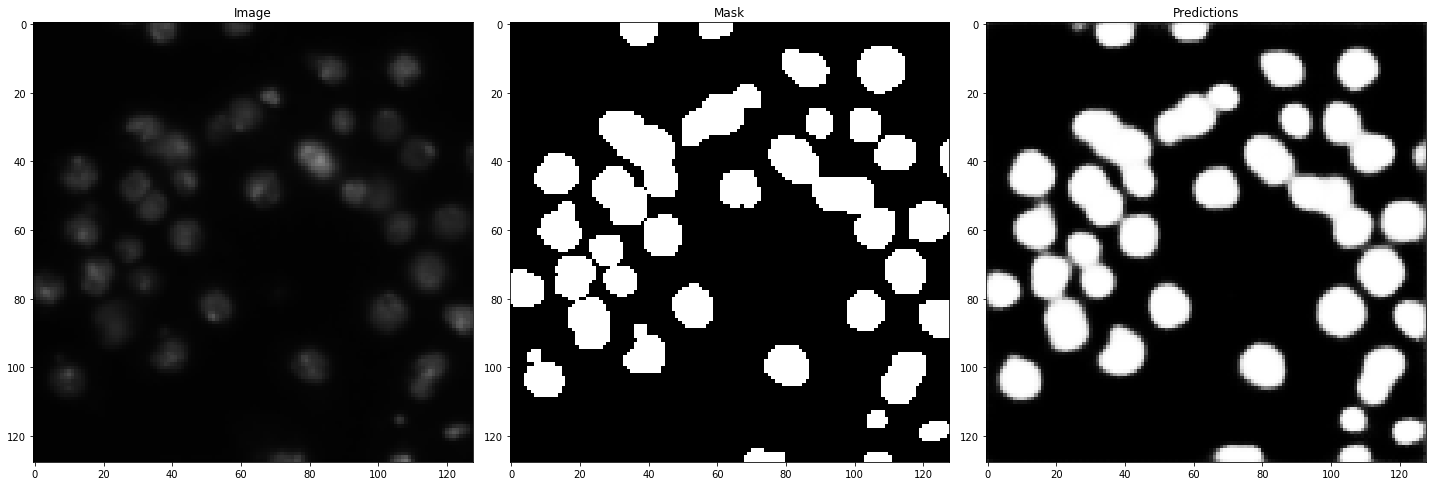

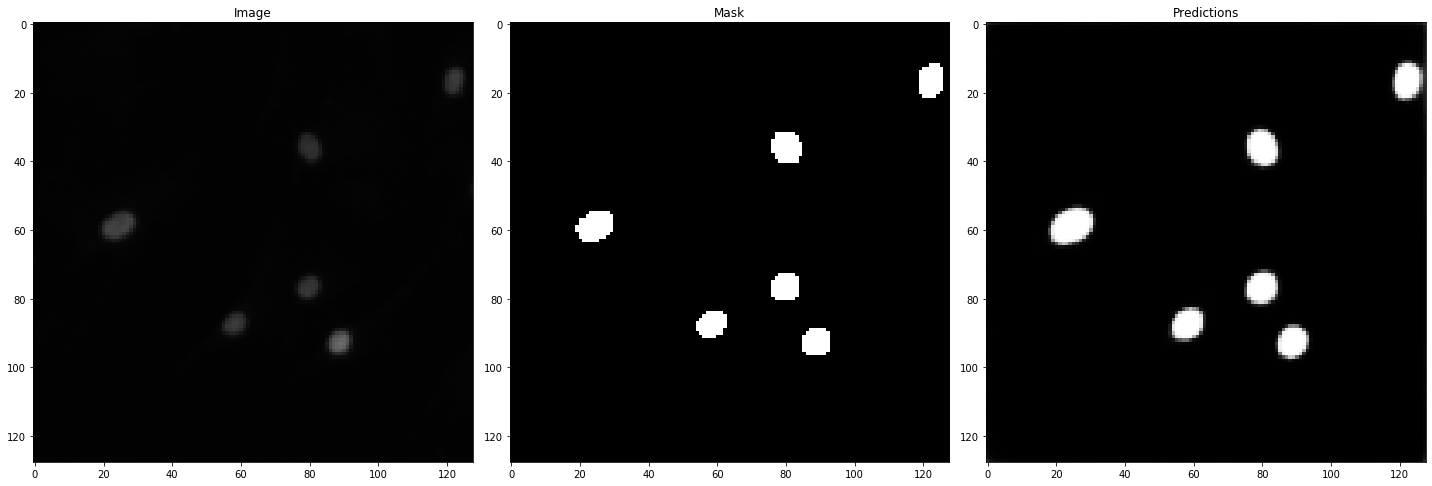

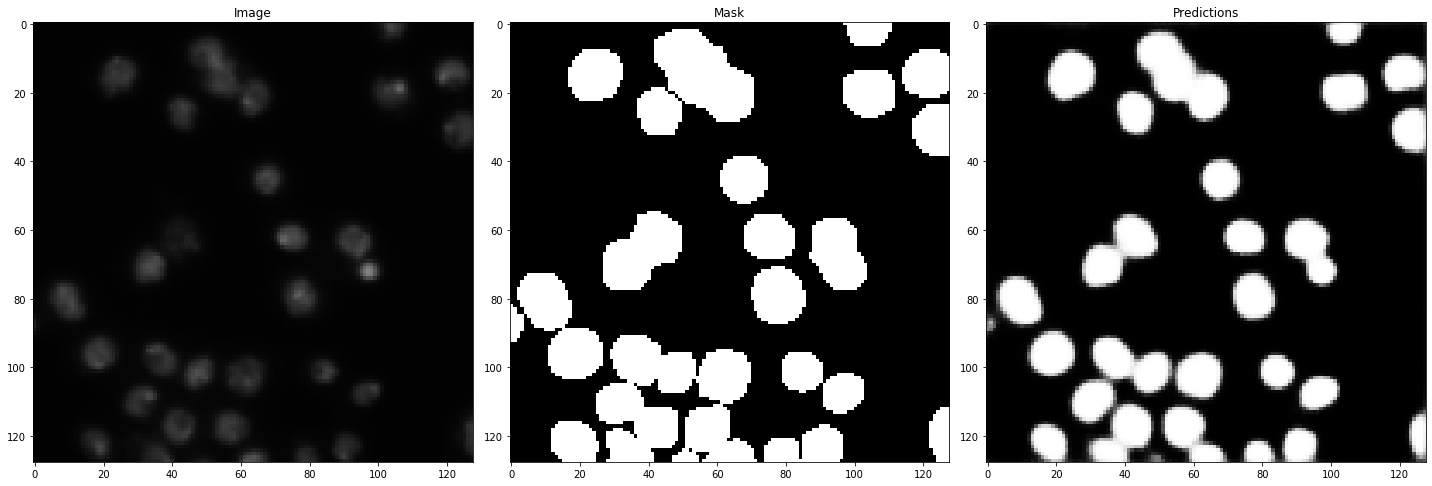

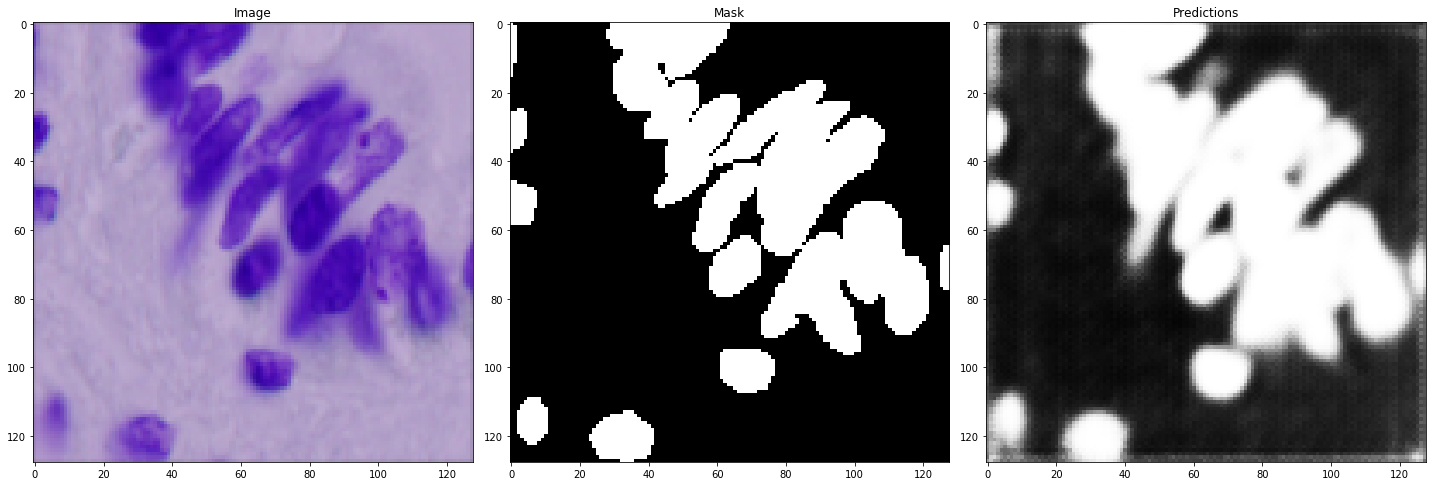

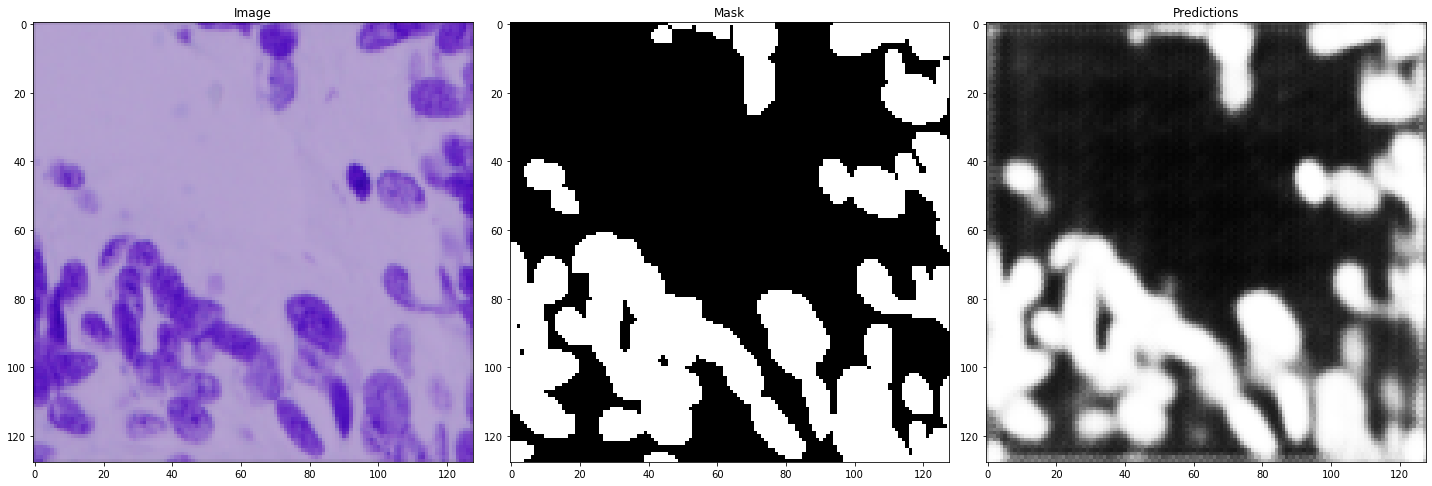

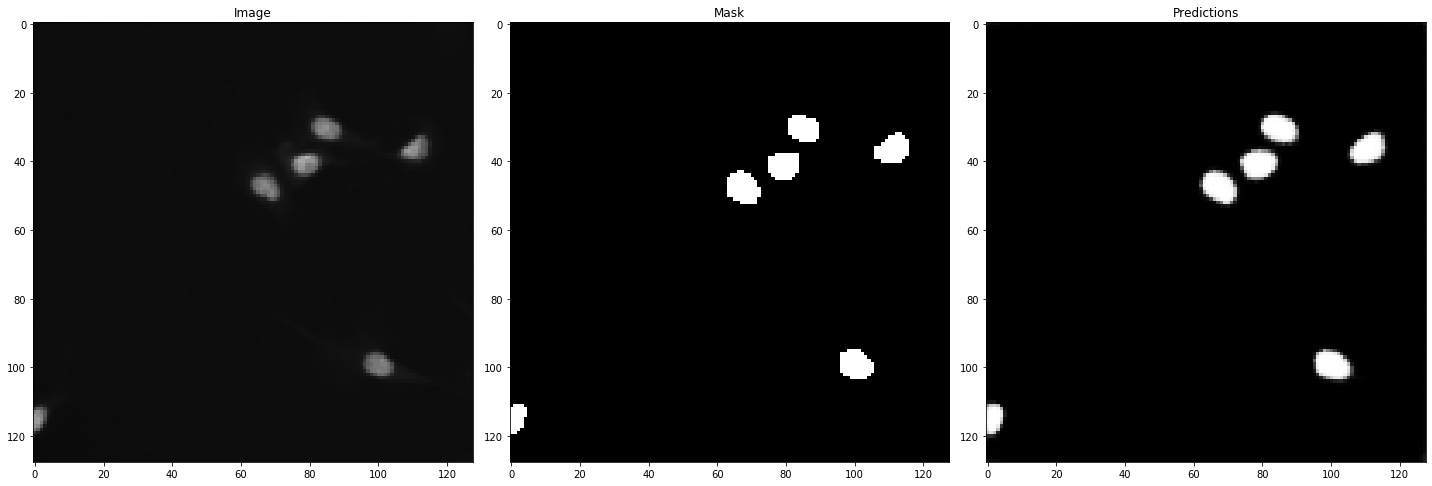

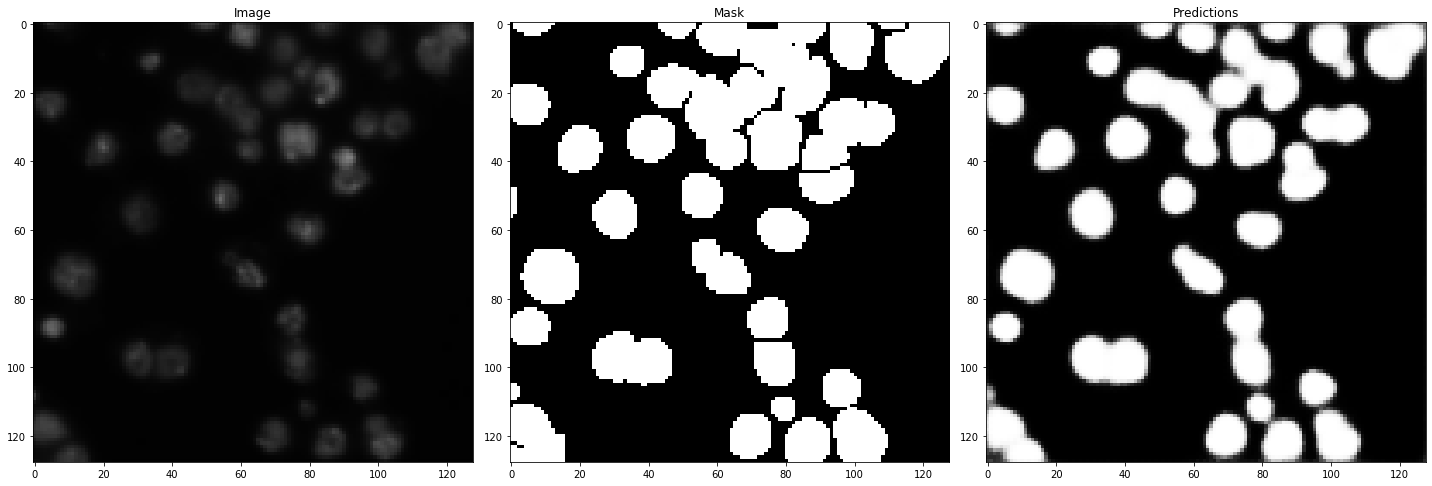

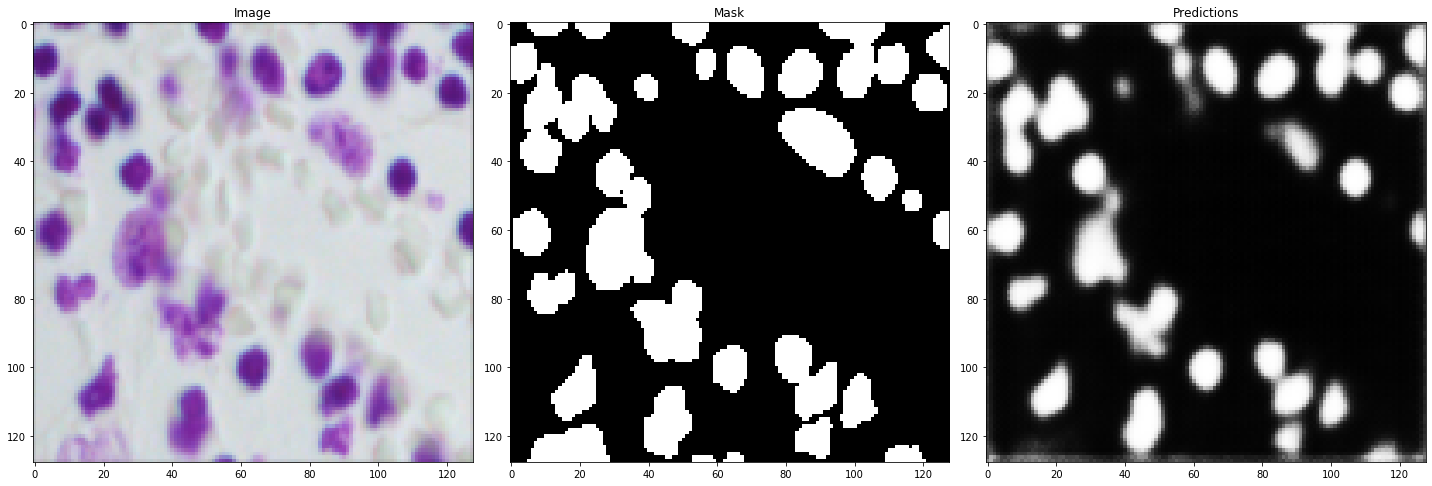

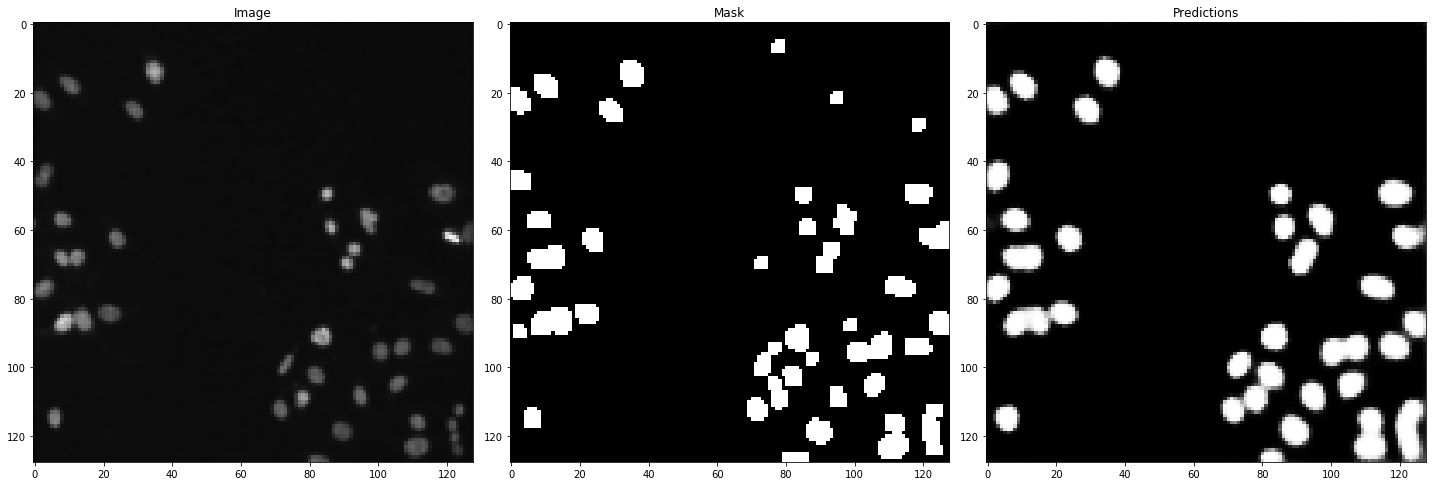

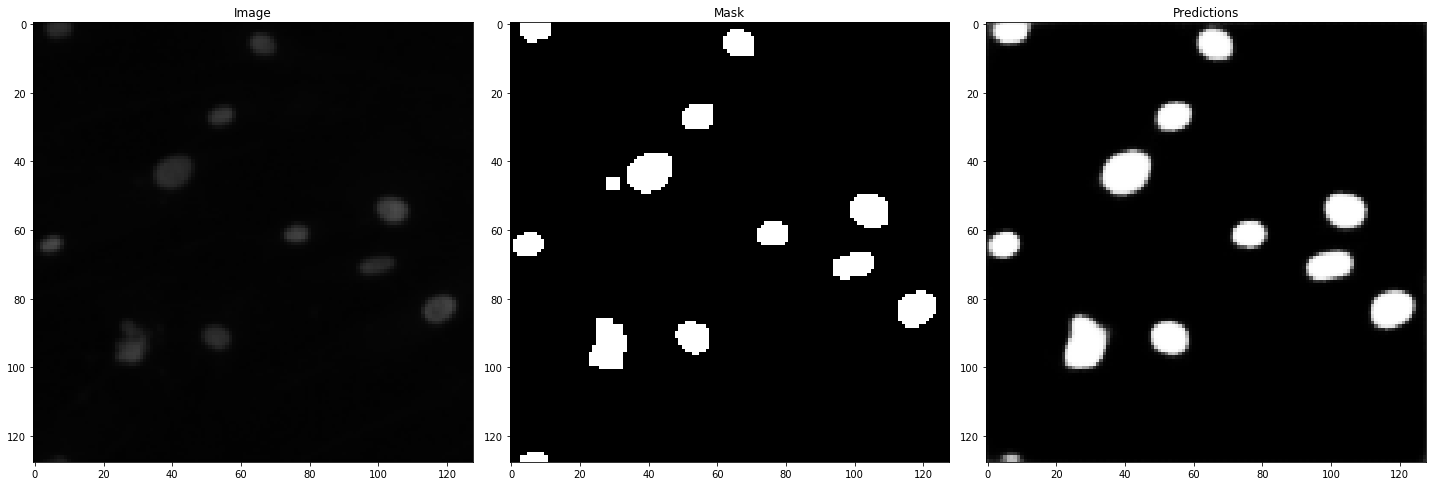

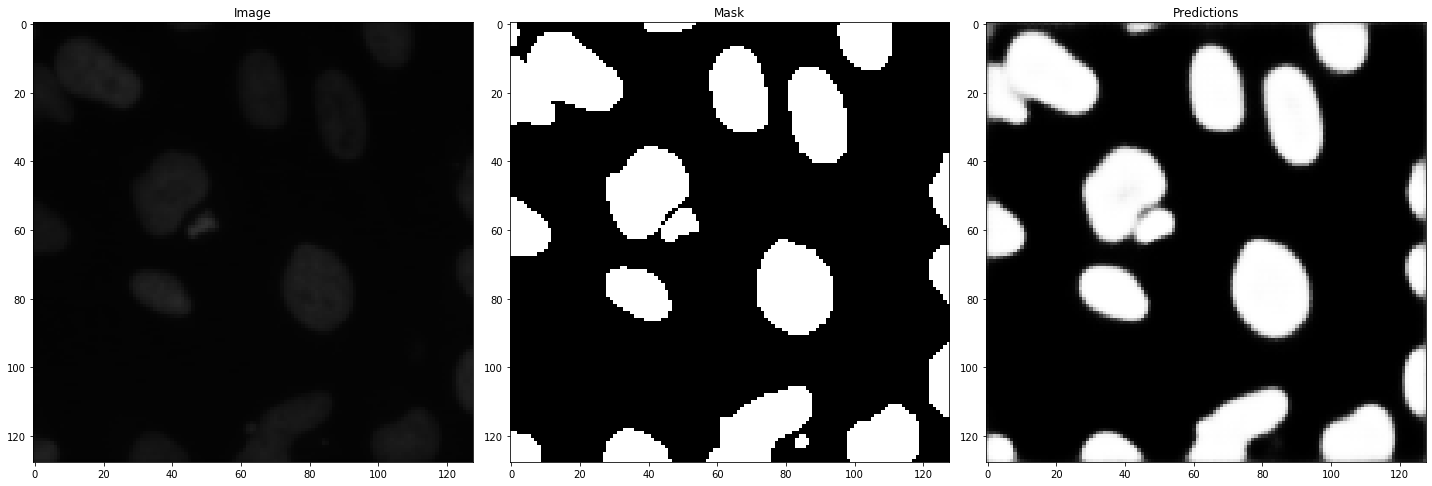

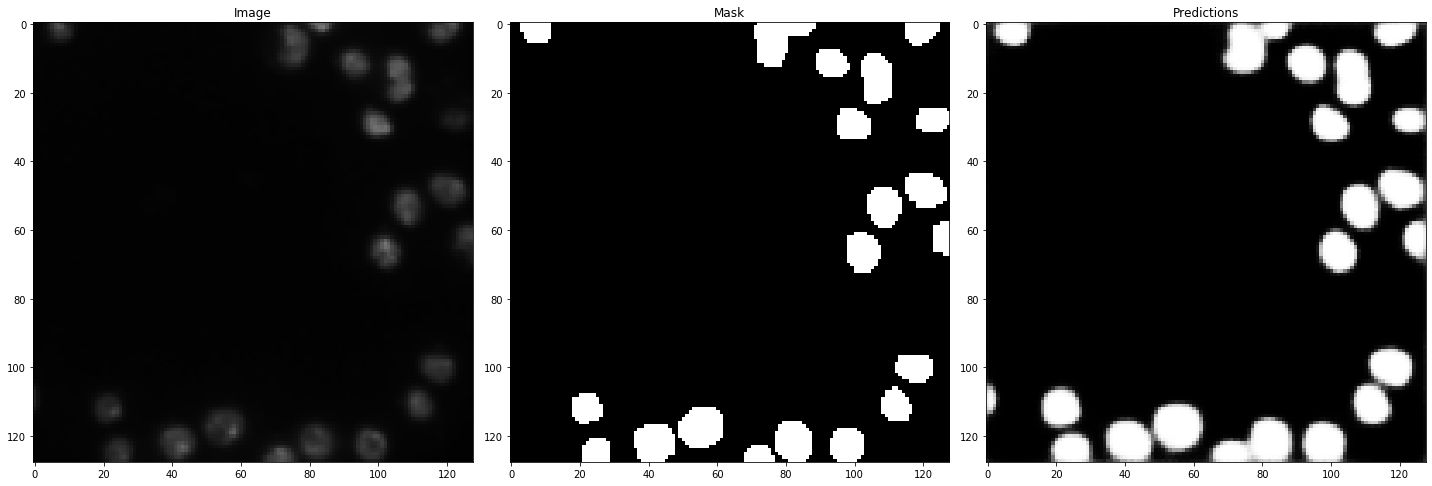

In [41]:

i=0

while(i<100):
    
    ix = random.randint(0, 602)
    plt.figure(figsize=(20,20))

    plt.subplot(131)
    imshow(x_train[ix])
    plt.title("Image")

    plt.subplot(132)
    imshow(np.squeeze(y_train[ix]))
    plt.title("Mask")

    plt.subplot(133)
    imshow(np.squeeze(preds_train[ix]))
    plt.title("Predictions")
    plt.show()
    
    i+=1;
    
    


In [42]:
print("THANK YOU!")

THANK YOU!


In [43]:
import cv2

In [44]:
import numpy as np

In [49]:
x=np.squeeze(x_train[1])

In [50]:
x

array([[[ 3,  3,  3],
        [ 3,  3,  3],
        [ 4,  4,  4],
        ...,
        [ 3,  3,  3],
        [ 3,  3,  3],
        [ 2,  2,  2]],

       [[ 4,  4,  4],
        [ 4,  4,  4],
        [ 3,  3,  3],
        ...,
        [ 2,  2,  2],
        [ 3,  3,  3],
        [ 2,  2,  2]],

       [[ 3,  3,  3],
        [ 3,  3,  3],
        [ 3,  3,  3],
        ...,
        [ 3,  3,  3],
        [ 3,  3,  3],
        [ 2,  2,  2]],

       ...,

       [[ 3,  3,  3],
        [ 3,  3,  3],
        [ 3,  3,  3],
        ...,
        [ 4,  4,  4],
        [ 6,  6,  6],
        [ 5,  5,  5]],

       [[ 4,  4,  4],
        [ 4,  4,  4],
        [ 4,  4,  4],
        ...,
        [ 9,  9,  9],
        [11, 11, 11],
        [ 9,  9,  9]],

       [[ 5,  5,  5],
        [ 4,  4,  4],
        [ 4,  4,  4],
        ...,
        [ 6,  6,  6],
        [ 7,  7,  7],
        [ 4,  4,  4]]], dtype=uint8)

In [51]:
x.shape

(128, 128, 3)

In [52]:
x_train[1]

array([[[ 3,  3,  3],
        [ 3,  3,  3],
        [ 4,  4,  4],
        ...,
        [ 3,  3,  3],
        [ 3,  3,  3],
        [ 2,  2,  2]],

       [[ 4,  4,  4],
        [ 4,  4,  4],
        [ 3,  3,  3],
        ...,
        [ 2,  2,  2],
        [ 3,  3,  3],
        [ 2,  2,  2]],

       [[ 3,  3,  3],
        [ 3,  3,  3],
        [ 3,  3,  3],
        ...,
        [ 3,  3,  3],
        [ 3,  3,  3],
        [ 2,  2,  2]],

       ...,

       [[ 3,  3,  3],
        [ 3,  3,  3],
        [ 3,  3,  3],
        ...,
        [ 4,  4,  4],
        [ 6,  6,  6],
        [ 5,  5,  5]],

       [[ 4,  4,  4],
        [ 4,  4,  4],
        [ 4,  4,  4],
        ...,
        [ 9,  9,  9],
        [11, 11, 11],
        [ 9,  9,  9]],

       [[ 5,  5,  5],
        [ 4,  4,  4],
        [ 4,  4,  4],
        ...,
        [ 6,  6,  6],
        [ 7,  7,  7],
        [ 4,  4,  4]]], dtype=uint8)

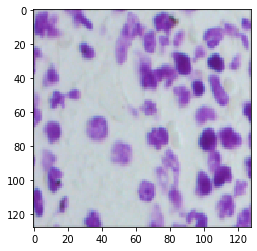

In [56]:
plt.imshow(x_train[3])

In [58]:
preds_train[3].shape

(128, 128, 1)

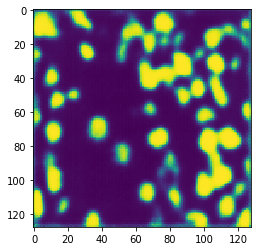

In [63]:
plt.imshow(np.squeeze(preds_train[3]))

In [64]:
np.squeeze(preds_train[3]).shape

(128, 128)

In [181]:
image=preds_train[3]
image=cv2.imshow("hello",preds_train[3])
cv2.waitKey()
cv2.destroyAllWindows()


In [139]:
edged = cv2.Canny(image,10,20)

In [260]:
contours= cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

error: OpenCV(3.4.1) C:\Miniconda3\conda-bld\opencv-suite_1533128839831\work\modules\imgproc\src\contours.cpp:199: error: (-210) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function cvStartFindContours_Impl


In [144]:
contours

(None, [], None)

In [108]:
cv2.imshow("hello",edged)
cv2.waitKey()
cv2.destroyAllWindows()


error: OpenCV(3.4.1) C:\Miniconda3\conda-bld\opencv-suite_1533128839831\work\modules\highgui\src\window.cpp:356: error: (-215) size.width>0 && size.height>0 in function cv::imshow


In [226]:
image=preds_train[5]

In [263]:
cv2.imshow("hello",image)
cv2.waitKey()
cv2.destroyAllWindows()


In [271]:
edged = cv2.Canny(image,-1,0)

error: OpenCV(3.4.1) C:\Miniconda3\conda-bld\opencv-suite_1533128839831\work\modules\imgproc\src\canny.cpp:947: error: (-215) _src.depth() == 0 in function cv::Canny


In [115]:
image.shape

(128, 128, 1)

In [119]:
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

error: OpenCV(3.4.1) C:\Miniconda3\conda-bld\opencv-suite_1533128839831\work\modules\imgproc\src\color.cpp:11109: error: (-215) depth == 0 || depth == 2 || depth == 5 in function cv::cvtColor


In [177]:
image=image.astype(int)

In [261]:

#cv2.imshow("kkkk", image)

# Create our shapening kernel, we don't normalize since the 
# the values in the matrix sum to 1
kernel_sharpening = np.array([[-1,-1,-1], 
                              [-1,9,-1], 
                              [-1,-1,-1]])

# applying different kernels to the input image
sharpened = cv2.filter2D(image, -1, kernel_sharpening)

cv2.imshow('Image Sharpening', sharpened)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [229]:
image=np.squeeze(image)

In [236]:
ret,thresh1 = cv2.threshold(imaget,100, 255, cv2.THRESH_BINARY)


In [272]:
height, width = image.shape

# Extract Sobel Edges
sobel_x = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
sobel_y = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)

cv2.imshow('Original', image)
cv2.waitKey(0)
cv2.imshow('Sobel X', sobel_x)
cv2.waitKey(0)
cv2.imshow('Sobel Y', sobel_y)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [255]:
image.shape

(128, 128, 1)

In [273]:
sobel_OR = cv2.bitwise_and(sobel_x, sobel_y)
cv2.imshow('sobel_OR', sobel_OR)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [190]:
imaget=x_train[5]

In [191]:
imaget.shape

(128, 128, 3)

In [193]:
imaget=cv2.cvtColor(imaget,cv2.COLOR_BGR2GRAY)

In [194]:
imaget.shape

(128, 128)

array([[0.12480274, 0.05802742, 0.05127037, ..., 0.03345397, 0.02810234,
        0.12163314],
       [0.03638792, 0.01121289, 0.01991111, ..., 0.00796252, 0.00896493,
        0.04092547],
       [0.01567799, 0.00422826, 0.00469023, ..., 0.00243536, 0.00453007,
        0.03749987],
       ...,
       [0.00636479, 0.00123051, 0.00109756, ..., 0.00271776, 0.00334698,
        0.03987876],
       [0.00794691, 0.00203839, 0.00225338, ..., 0.00365072, 0.01840422,
        0.08039668],
       [0.04884723, 0.02453348, 0.0096848 , ..., 0.01322922, 0.02706516,
        0.10369951]], dtype=float32)

In [231]:
image

array([[0.12480274, 0.05802742, 0.05127037, ..., 0.03345397, 0.02810234,
        0.12163314],
       [0.03638792, 0.01121289, 0.01991111, ..., 0.00796252, 0.00896493,
        0.04092547],
       [0.01567799, 0.00422826, 0.00469023, ..., 0.00243536, 0.00453007,
        0.03749987],
       ...,
       [0.00636479, 0.00123051, 0.00109756, ..., 0.00271776, 0.00334698,
        0.03987876],
       [0.00794691, 0.00203839, 0.00225338, ..., 0.00365072, 0.01840422,
        0.08039668],
       [0.04884723, 0.02453348, 0.0096848 , ..., 0.01322922, 0.02706516,
        0.10369951]], dtype=float32)

In [213]:
image.shape

(128, 128)

In [237]:
image=thresh1

array([[10, 11, 10, ...,  9,  9,  9],
       [10, 11, 11, ..., 10, 10,  9],
       [10, 11, 11, ..., 11, 10,  9],
       ...,
       [10, 12, 12, ..., 10, 10,  9],
       [10, 12, 12, ...,  9,  9,  9],
       [10, 10, 11, ...,  9,  9,  8]], dtype=uint8)

In [207]:
thresh1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [234]:
image=image*2000

In [235]:
image

array([[49921.098  , 23210.967  , 20508.146  , ..., 13381.588  ,
        11240.936  , 48653.254  ],
       [14555.168  ,  4485.1543 ,  7964.4443 , ...,  3185.01   ,
         3585.9705 , 16370.189  ],
       [ 6271.1953 ,  1691.3057 ,  1876.0919 , ...,   974.1426 ,
         1812.0289 , 14999.95   ],
       ...,
       [ 2545.917  ,   492.20325,   439.024  , ...,  1087.1052 ,
         1338.7919 , 15951.502  ],
       [ 3178.7634 ,   815.3558 ,   901.35333, ...,  1460.2899 ,
         7361.686  , 32158.672  ],
       [19538.89   ,  9813.393  ,  3873.9204 , ...,  5291.6885 ,
        10826.063  , 41479.8    ]], dtype=float32)

In [243]:
image=y_train[1].astype("int")

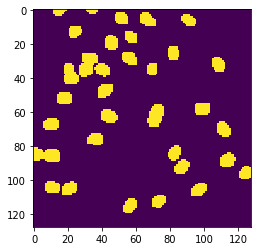

In [249]:
plt.imshow(np.squeeze(image))

In [251]:
image.dtype

dtype('int32')

In [252]:
image=image.astype("float")

In [256]:
image=np.squeeze(image)

In [258]:
image.shape

(128, 128)

In [262]:
image

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])